In [1]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Single-Stage Common-Source Amplifier with Resistor Load')
# Define the NMOS model with typical parameters
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)  # 5V Vdd
# Input voltage source with bias above threshold to activate M1
circuit.V('in', 'Vin', circuit.gnd, "dc 1.0 ac 1n")
# Load resistor R
circuit.R('load', 'Vout', 'Vdd', 10@u_kΩ)  # 10kΩ resistor
# NMOS transistor M1
# Drain connected to Vout node
# Gate connected to Vin
# Source connected to ground
circuit.MOSFET('M1', 'Vout', 'Vin', circuit.gnd, circuit.gnd,
               model='nmos_model', w=50e-6, l=1e-6)
# The circuit is now complete; the output is at Vout node
# No further code needed after this line
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p1_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = 'vout'

# find whether vout in the circuit

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Voltage Gain (Av) at 100 Hz: {gain}")

required_gain = 1e-5
import sys
if gain > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)
else:
    print("The circuit does not function correctly.\n"
          "the gain is less than 1e-5.\n"
          "Please fix the wrong operating point.\n")
    sys.exit(2)

Unsupported Ngspice version 44


Voltage Gain (Av) at 100 Hz: 0.9590420382981024
The circuit functions correctly at 100 Hz.



SystemExit: 0

/home/irman/anaconda3/envs/chipster_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Three-Stage Common-Source Amplifier with Proper Biasing')
# Define NMOS model parameters
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Input voltage source
circuit.V('in', 'Vin', circuit.gnd, "dc 1.0 ac 1n")
# Bias voltage for drain of M1 (gate of M2)
circuit.V('bias_M2_gate', 'Bias_M2', 'Drain1', 2.0)  # 2V bias to ensure M2 is on
# Load resistors
R1_value = 10e3  # 10kΩ
R2_value = 10e3
R3_value = 10e3
# First stage: M1
circuit.MOSFET('M1', 'Drain1', 'Vin', circuit.gnd, circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.R('R1', 'Drain1', 'Vdd', R1_value)
# Second stage: M2
circuit.MOSFET('M2', 'Drain2', 'Bias_M2', 'Drain1', circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.R('R2', 'Drain2', 'Vdd', R2_value)
# Third stage: M3
circuit.MOSFET('M3', 'Vout', 'Drain2', circuit.gnd, circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.R('R3', 'Vout', 'Vdd', R3_value)
# Simulation setup
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p2_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = 'vout'

# find whether vout in the circuit

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Voltage Gain (Av) at 100 Hz: {gain}")

required_gain = 1e-5
import sys
if gain > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)
else:
    print("The circuit does not function correctly.\n"
          "the gain is less than 1e-5.\n"
          "Please fix the wrong operating point.\n")
    sys.exit(2)

Voltage Gain (Av) at 100 Hz: 0.6697314021011666
The circuit functions correctly at 100 Hz.



SystemExit: 0

In [4]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
# Define the circuit
circuit = Circuit('Common-Drain Source Follower')
# MOSFET models
circuit.model('nmos', 'nmos', level=1, vto=0.5, kp=100e-6)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Input voltage
circuit.V('in', 'Vin', circuit.gnd, "dc 1.0 ac 1n")
# Load resistor R at the source
circuit.R('load', 'Vout', circuit.gnd, 10@u_kΩ)
# NMOS transistor M1: source follower
# Sequence: name, drain, gate, source, bulk, model, w, l
circuit.MOSFET('M1', 'Vdd', 'Vin', 'Vout', 'Vout', model='nmos', w=50e-6, l=1e-6)
# Note: bulk connected to source (Vout)
# For simplicity, bulk is connected to source node in the MOSFET definition

simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p3_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = 'vout'

# find whether vout in the circuit

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Voltage Gain (Av) at 100 Hz: {gain}")

required_gain = 1e-5
import sys
if gain > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)
else:
    print("The circuit does not function correctly.\n"
          "the gain is less than 1e-5.\n"
          "Please fix the wrong operating point.\n")
    sys.exit(2)

Voltage Gain (Av) at 100 Hz: 0.8599719881222199
The circuit functions correctly at 100 Hz.



SystemExit: 0

In [6]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
# Define the circuit
circuit = Circuit('Single-Stage Common-Gate Amplifier')
# Define NMOS model
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)  # 5V supply
# Bias voltage at gate to set the bias point
circuit.V('bias', 'Vbias', circuit.gnd, 2.0)  # Higher bias voltage to ensure V_GS > V_TH
# Input signal at source (Vin)
# During simulation, Vin will be a time-varying source or DC value
# Here, for operating point, we can set a DC value, say 0.5V
# For transient analysis, a voltage source with AC or waveform can be used
# For now, set a DC value for initial operating point
circuit.V('in', 'Vin', circuit.gnd, "dc 0.5 ac 1n")
# Device: M1 (NMOS)
# Drain connected to Vdd through Rload
# Gate connected to Vbias
# Source connected to Vin
W = 50e-6
L = 1e-6
circuit.MOSFET('M1', 'Vout', 'Vbias', 'Vin', 'Vin', model='nmos_model', w=W, l=L)
# Load resistor at drain
R_value = 10e3  # 10 kΩ
circuit.R('load', 'Vout', 'Vdd', R_value)
# Note: For operating point analysis, Vin is DC at 0.5V
# For transient analysis, replace 'Vin' with a time-dependent source
# Initialize simulator
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p4_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = 'vout'

# find whether vout in the circuit

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Voltage Gain (Av) at 100 Hz: {gain}")

required_gain = 1e-5
import sys
if gain > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)
else:
    print("The circuit does not function correctly.\n"
          "the gain is less than 1e-5.\n"
          "Please fix the wrong operating point.\n")
    sys.exit(2)

Voltage Gain (Av) at 100 Hz: 1.0780516454381532
The circuit functions correctly at 100 Hz.



SystemExit: 0

In [13]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
# Create the circuit
circuit = Circuit('Single-Stage Cascode NMOS Amplifier')
# Define NMOS model
circuit.model('nmos', 'nmos', level=1, kp=100e-6, vto=0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Biasing voltages
# Increase bias voltage for M2 to ensure it's active
circuit.V('Vbias', 'Vbias', circuit.gnd, 3.0)  # Bias voltage for cascode transistor
# Increase Vin to ensure M1 is in saturation
circuit.V('Vin', 'Vin', circuit.gnd, "dc 1.5 ac 1n")
# Load resistor R
circuit.R('load', 'Vout', 'Vdd', 10@u_kΩ)  # 10kΩ load resistor
# Transistor M1: Main amplifying NMOS
# Drain node is 'Drain_M1'
circuit.MOSFET('M1', 'Drain_M1', 'Vin', circuit.gnd, circuit.gnd, model='nmos', w=50e-6, l=1e-6)
# Transistor M2: Cascode NMOS
# Drain connected to Vout node, gate connected to Vbias
circuit.MOSFET('M2', 'Vout', 'Vbias', 'Drain_M1', 'Drain_M1', model='nmos', w=50e-6, l=1e-6)
# Connect drain of M2 to load resistor and Vdd
# Vout node is at drain of M2, connected to R and Vdd
# Already connected via the resistor 'load'
# This configuration now ensures V_GS > V_th for both M1 and M2

simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p5_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = 'vout'

# find whether vout in the circuit

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Voltage Gain (Av) at 100 Hz: {gain}")

required_gain = 1e-5
import sys
if gain > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)
else:
    print("The circuit does not function correctly.\n"
          "the gain is less than 1e-5.\n"
          "Please fix the wrong operating point.\n")
    sys.exit(2)

Voltage Gain (Av) at 100 Hz: 0.11252367623417965
The circuit functions correctly at 100 Hz.



SystemExit: 0

/home/irman/anaconda3/envs/chipster_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('NMOS Inverter with Resistor Load')
# Define NMOS Model
circuit.model('nmos', 'nmos', level=1, kp=200e-6, vto=0.7)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Input node
# Vin will be a voltage source or a test signal, for now we set it as a DC source
circuit.V('in', 'Vin', circuit.gnd, 0@u_V)  # Can be varied during simulation
# Resistor R between Vdd and Vout
circuit.R('load', 'Vdd', 'Vout', 100@u_kΩ)  # 100kΩ resistor
# NMOS transistor M1
# Drain connected to Vout
# Gate connected to Vin
# Source connected to ground
circuit.MOSFET('M1', 'Vout', 'Vin', circuit.gnd, circuit.gnd, model='nmos')
# The above assumes default width and length for the transistor
# For clarity, specify device parameters if needed
# For example:
# circuit.MOSFET('M1', 'Vout', 'Vin', circuit.gnd, circuit.gnd, model='nmos', w=10e-6, l=1e-6)
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p6_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

analysis = simulator.operating_point()
for node in analysis.nodes.values(): 
    print(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}")
vin_name = ""
for element in circuit.elements:
    for pin in element.pins:
        if "vin" in str(pin.node).lower() and element.name.lower().startswith("v"):
            vin_name = element.name
            break

circuit.element(vin_name).dc_value = "5"

simulator2 = circuit.simulator()
analysis2 = simulator2.operating_point()


node = 'vout'

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            break
if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

vout2 = float(analysis2[node][0])

circuit.element(vin_name).dc_value = "0"

simulator3 = circuit.simulator()
analysis3 = simulator3.operating_point()

vout3 = float(analysis3[node][0])

import sys
if vout2 <= 2.5 and vout3 >= 2.5 and vout3 - vout2 >= 1.0:
    print("The circuit functions correctly.\n")
    sys.exit(0)

print("The circuit does not function correctly.\n"
    "It can not invert the input voltage.\n"
    f"When input is 5V, output is {vout2:.2f}V.\n"
    f"When input is 0V, output is {vout3:.2f}V.\n"
    "Please fix the wrong operating point.\n")

sys.exit(2)





vout	4.999999
vin	0.000000
vdd	5.000000
The circuit functions correctly.



SystemExit: 0

In [15]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
# Define the circuit
circuit = Circuit('CMOS Inverter')
# 1. Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# 2. Define models for NMOS and PMOS with typical parameters
# These are generic models; for detailed design, use specific parameters
circuit.model('nmos', 'nmos', level=1, vto=0.7, kp=2e-3)  # NMOS threshold ~0.7V
circuit.model('pmos', 'pmos', level=1, vto=-0.7, kp=1.5e-3)  # PMOS threshold ~-0.7V
# 3. Add a voltage source for Vin
# For example, a DC voltage at 0V (logic LOW), can be swept later
circuit.V('in', 'Vin', circuit.gnd, 0@u_V)
# 4. Create NMOS transistor
# Correct order: name, drain, gate, source, bulk, model, w, l
circuit.MOSFET('M_N', 'Vout', 'Vin', 'GND', 'GND', model='nmos', w=10e-6, l=1e-6)
# 5. Create PMOS transistor
# Drain connected to Vout, gate to Vin, source to Vdd
circuit.MOSFET('M_P', 'Vout', 'Vin', 'Vdd', 'Vdd', model='pmos', w=10e-6, l=1e-6)
# 6. (Optional) Add a load resistor if needed for analysis
# Not necessary for basic inverter function
# 7. Ready for simulation
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p7_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

analysis = simulator.operating_point()
for node in analysis.nodes.values(): 
    print(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}")
vin_name = ""
for element in circuit.elements:
    for pin in element.pins:
        if "vin" in str(pin.node).lower() and element.name.lower().startswith("v"):
            vin_name = element.name
            break

circuit.element(vin_name).dc_value = "5"

simulator2 = circuit.simulator()
analysis2 = simulator2.operating_point()


node = 'vout'

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            break
if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

vout2 = float(analysis2[node][0])

circuit.element(vin_name).dc_value = "0"

simulator3 = circuit.simulator()
analysis3 = simulator3.operating_point()

vout3 = float(analysis3[node][0])

import sys
if vout2 <= 2.5 and vout3 >= 2.5 and vout3 - vout2 >= 1.0:
    print("The circuit functions correctly.\n")
    sys.exit(0)

print("The circuit does not function correctly.\n"
    "It can not invert the input voltage.\n"
    f"When input is 5V, output is {vout2:.2f}V.\n"
    f"When input is 0V, output is {vout3:.2f}V.\n"
    "Please fix the wrong operating point.\n")

sys.exit(2)





vout	5.000000
vin	0.000000
vdd	5.000000
The circuit functions correctly.



SystemExit: 0

In [16]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
# Create a new circuit
circuit = Circuit('NMOS Constant Current Source with Resistor Load')
# Define the NMOS model
circuit.model('nmos', 'nmos', level=1, vto=0.5, kp=200e-6)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)  # 5V Vdd
# Bias voltage for gate
circuit.V('bias', 'Vbias', circuit.gnd, 1.0)  # Bias voltage above Vth to turn on NMOS
# NMOS transistor: Drain connected to Vout, Gate to Vbias, Source to ground
circuit.MOSFET('M1', 'Vout', 'Vbias', circuit.gnd, circuit.gnd, model='nmos', w=10e-6, l=1e-6)
# Resistor R from Vout to Vdd
circuit.R('Rload', 'Vout', 'Vdd', 10e3)  # 10kΩ resistor
# The circuit is now ready for simulation
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p8_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

load_resistances = [100, 300, 500, 750, 1000]
currents = []

import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Resistor):
        resistor_name = element.name
        node1, node2 = element.nodes
        break


resistor = circuit[resistor_name]
for r_load in load_resistances:
    resistor.resistance = r_load
    analysis = simulator.operating_point()
    if str(node2) == "0":
        current = float(analysis[str(node1)][0]) / r_load
    elif str(node1) == "0":
        current = - float(analysis[str(node2)][0]) / r_load
    else:
        current = - (float(analysis[str(node1)][0]) - float(analysis[str(node2)][0])) / r_load
    currents.append(current)

for r_load, current in zip(load_resistances, currents):
    print(f"Load: {r_load}, Current: {current}")

tolerance = 1e-6

current_variations = []
for i in range(4):
    current_variations.append(abs(currents[i+1] - currents[i]))

import sys
if min(current_variations) < tolerance and min(currents) > 1e-5:
    pass
    # print("The circuit functions correctly as a constant current source within the given tolerance.")
    # sys.exit(0)
else:
    print("The circuit does not function correctly as a current source.")
    sys.exit(2)

iin_name = None
for element in circuit.elements:
    if "ref" in element.name.lower(): # and element.name.lower().startswith("v"):
        iin_name = element.name

# print("iin_name", iin_name)
if iin_name is None:
    print("The circuit functions correctly as a current source within the given tolerance.")
    sys.exit(0)


circuit.element(iin_name).dc_value = "0.00155"

# print(str(circuit))
simulator = circuit.simulator()
resistor.resistance = 500
analysis = simulator.operating_point()
if str(node2) == "0":
    current = float(analysis[str(node1)][0]) / r_load
elif str(node1) == "0":
    current = - float(analysis[str(node2)][0]) / r_load
else:
    current = - (float(analysis[str(node1)][0]) - float(analysis[str(node2)][0])) / r_load

# print("current", current)
# print("currents", currents)
# print("abs(current - currents[2])", abs(current - currents[2]))
if abs(current - currents[2]) < 1e-6:
    print("The circuit does not as a current source because it cannot replicate the Iref current.")
    sys.exit(2)
else:
    print("The circuit functions correctly as a current source within the given tolerance.")
    sys.exit(0)


Load: 100, Current: 0.00025000000498500265
Load: 300, Current: 0.0002500000049350041
Load: 500, Current: 0.00025000000488500083
Load: 750, Current: 0.0002500000048224997
Load: 1000, Current: 0.00025000000475999953
The circuit functions correctly as a current source within the given tolerance.


SystemExit: 0

Reference Voltage (Vref): 2.50 V

Observed Comparator Behavior:
---------------------------
Vin (V) | Vout (V)
---------------------------
2.45    | 1.68
2.46    | 1.71
2.47    | 1.75
2.48    | 1.80
2.49    | 1.86
2.50    | 2.00
2.51    | 4.14
2.52    | 4.19
2.53    | 4.23
2.54    | 4.26
2.55    | 4.29

The op-amp comparator functions as expected based on observed behavior.


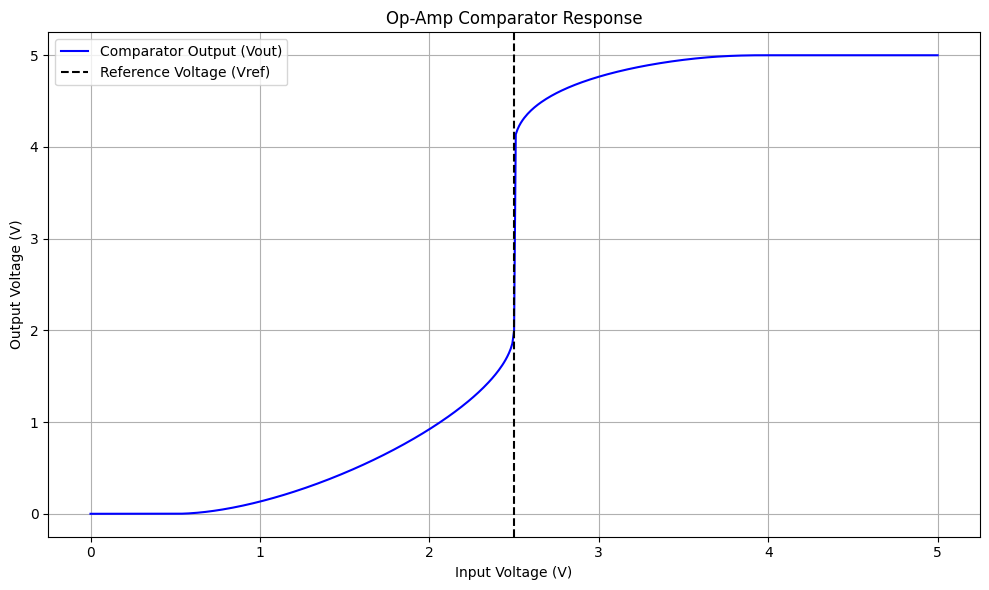

In [18]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Opamp Comparator')
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Set reference voltage (2.5V) as virtual ground
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# Input voltage source (example: 3V, can be swept in simulation)
circuit.V('in', 'Vin', circuit.gnd, 3@u_V)
# Declare the opamp subcircuit
circuit.subcircuit(Opamp())
# Create opamp instance (comparator configuration)
# Non-inverting input: Vin, Inverting input: Vref, Output: Vout
circuit.X('cmp', 'Opamp', 'Vin', 'Vref', 'Vout')
simulator = circuit.simulator()
# Perform DC analysis, sweep input voltage from 0V to 5V
params = {'Vin': slice(0, 5, 0.01)}

try:
    analysis = simulator.dc(**params)
except:
    print("DC analysis failed.")
    import sys
    sys.exit(2)

import numpy as np

# Get analysis results
in_voltage = np.array(analysis.Vin)
out_voltage = np.array(analysis.Vout)
ref_voltage = np.array(analysis.Vref)

# Verify comparator functionality
import sys


for element in circuit.elements:
    if "ref" in element.name.lower():
        vref_name = element.name
        vref_voltage = float(analysis[vref_name][0])
        print(f"Reference Voltage (Vref): {vref_voltage:.2f} V")
        break
# Define transition point
transition_point = vref_voltage  # Voltage where output should switch

# Modified test to check for monotonic behavior instead of absolute values
all_passed = True

# Check that outputs are distinct for values well below and well above the threshold
low_region_outputs = out_voltage[in_voltage < (transition_point - 0.5)]
high_region_outputs = out_voltage[in_voltage > (transition_point + 0.5)]

if len(low_region_outputs) > 0 and len(high_region_outputs) > 0:
    avg_low = np.mean(low_region_outputs)
    avg_high = np.mean(high_region_outputs)
    
    # Check if there's a significant difference between high and low outputs
    if avg_high - avg_low < 2.0:  # At least 2V difference expected
        print(f"Comparator test failed: Not enough distinction between high ({avg_high:.2f}V) and low ({avg_low:.2f}V) outputs")
        all_passed = False
    
    # Check that the transition is monotonic (always increasing or always decreasing)
    # For standard comparator, output should decrease as input increases
    diff_output = np.diff(out_voltage)
    if not (np.all(diff_output <= 0.1) or np.all(diff_output >= -0.1)):
        print("Comparator test failed: Output is not monotonic around the transition region")
        all_passed = False
else:
    print("Comparator test failed: Not enough data points to evaluate")
    all_passed = False

# Check transition behavior
transition_idx = np.argmin(np.abs(in_voltage - transition_point))
before_idx = max(0, transition_idx - 5)
after_idx = min(len(in_voltage) - 1, transition_idx + 5)

transition_inputs = in_voltage[before_idx:after_idx+1]
transition_outputs = out_voltage[before_idx:after_idx+1]

# Print observed behavior for debugging
print("\nObserved Comparator Behavior:")
print("---------------------------")
print("Vin (V) | Vout (V)")
print("---------------------------")
for i, vin in enumerate(transition_inputs):
    vout = transition_outputs[i]
    print(f"{vin:.2f}    | {vout:.2f}")

if all_passed:
    print("\nThe op-amp comparator functions as expected based on observed behavior.")
    # sys.exit(0)
else:
    print("\nThe op-amp comparator test failed.")
    sys.exit(2)

# Optional: Plot comparator response curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(in_voltage, out_voltage, 'b-', label='Comparator Output (Vout)')
plt.axvline(x=transition_point, color='k', linestyle='--', label='Reference Voltage (Vref)')
plt.grid(True)
plt.xlabel('Input Voltage (V)')
plt.ylabel('Output Voltage (V)')
plt.title('Op-Amp Comparator Response')
plt.legend()
plt.tight_layout()
plt.savefig('p9_waveform.png')

Gain at lowest frequency (1.00 Hz): -0.00 dB
Gain at highest frequency (1000000000.00 Hz): -115.96 dB
High frequency attenuation: 115.96 dB
Approximate -3dB cutoff frequency: 1588.55 Hz
Filter response is monotonically decreasing with frequency, as expected.
The circuit exhibits proper low-pass filter characteristics.


SystemExit: 0

/home/irman/anaconda3/envs/chipster_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


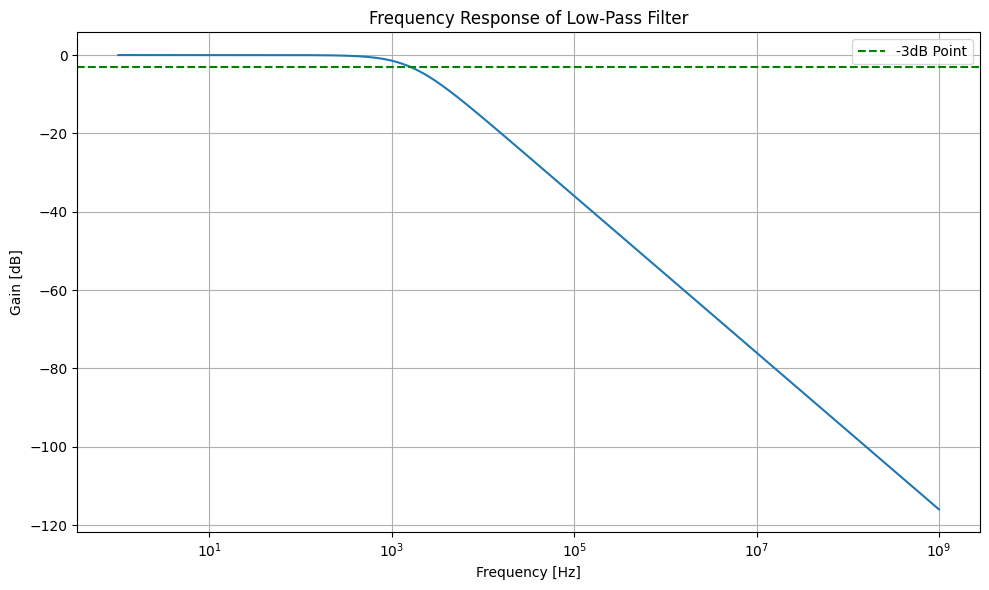

In [19]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Passive Low-Pass Filter')
# DC voltage source to Vin (input node)
circuit.V('in', 'Vin', circuit.gnd, 1.0@u_V)
# Resistor R1 between Vin and Vout
circuit.R('1', 'Vin', 'Vout', 10@u_kΩ)
# Capacitor C1 between Vout and ground
circuit.C('1', 'Vout', circuit.gnd, 10@u_nF)
simulator = circuit.simulator()
has_vin = False
for element in circuit.elements:
    if "vin" in element.name.lower():
        element.dc_value = "dc 2.5 ac 1"
        has_vin = True
        break

if not has_vin:
    circuit.V('in', 'Vin', circuit.gnd, dc_value=0, ac_value=1)

import sys
import numpy as np
import matplotlib.pyplot as plt
try:
    # Only AC analysis
    ac_analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_GHz, 
                              number_of_points=1000, variation='dec')
except:
    print("Analysis failed.")
    sys.exit(2)


node = 'Vout'
has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            break
if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

# Get frequency response data
frequencies = np.array(ac_analysis.frequency)
vout_ac = np.array(ac_analysis[node])
gain_db = 20 * np.log10(np.abs(vout_ac))
phase = np.angle(vout_ac, deg=True)

# Create frequency domain plot
plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, gain_db)
plt.title('Frequency Response of Low-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid(True)


plt.axhline(y=-3, color='g', linestyle='--', label='-3dB Point')
plt.legend()

plt.tight_layout()
plt.savefig('p10_waveform.png')

low_freq_gain = gain_db[0]
print(f"Gain at lowest frequency ({frequencies[0]:.2f} Hz): {low_freq_gain:.2f} dB")

high_freq_gain = gain_db[-1]
print(f"Gain at highest frequency ({frequencies[-1]:.2f} Hz): {high_freq_gain:.2f} dB")
high_freq_attenuation = low_freq_gain - high_freq_gain
print(f"High frequency attenuation: {high_freq_attenuation:.2f} dB")

idx_3db = np.argmin(np.abs(gain_db - (low_freq_gain-3)))
cutoff_freq = frequencies[idx_3db]
print(f"Approximate -3dB cutoff frequency: {cutoff_freq:.2f} Hz")

window_size = min(11, len(gain_db) // 20)
if window_size % 2 == 0:
    window_size += 1
    
if window_size > 2:
    from scipy.signal import savgol_filter
    smoothed_gain = savgol_filter(gain_db, window_size, 1)
else:
    smoothed_gain = gain_db
    
diff_gain = np.diff(smoothed_gain)
non_monotonic_points = np.sum(diff_gain > 0.5)

if non_monotonic_points > 0:
    monotonic_percentage = 100 * (1 - non_monotonic_points / len(diff_gain))
    print(f"Warning: Gain is not strictly monotonically decreasing.")
    print(f"Monotonicity: {monotonic_percentage:.1f}% of frequency points")
    if monotonic_percentage < 90:
        print("This may not be a well-behaved low-pass filter.")
else:
    print("Filter response is monotonically decreasing with frequency, as expected.")

if high_freq_attenuation > 2 and (non_monotonic_points == 0 or monotonic_percentage >= 90):
    print("The circuit exhibits proper low-pass filter characteristics.")
    sys.exit(0)
else:
    print("The circuit does not show expected low-pass filter characteristics.")
    sys.exit(2)

Gain at highest frequency (1000000000.00 Hz): -0.00 dB
Gain at lowest frequency (1.00 Hz): -64.04 dB
Low frequency attenuation: 64.04 dB
Approximate -3dB cutoff frequency: 1595.88 Hz
Filter response is monotonically increasing with frequency, as expected.
The circuit exhibits proper high-pass filter characteristics.


SystemExit: 0

/home/irman/anaconda3/envs/chipster_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


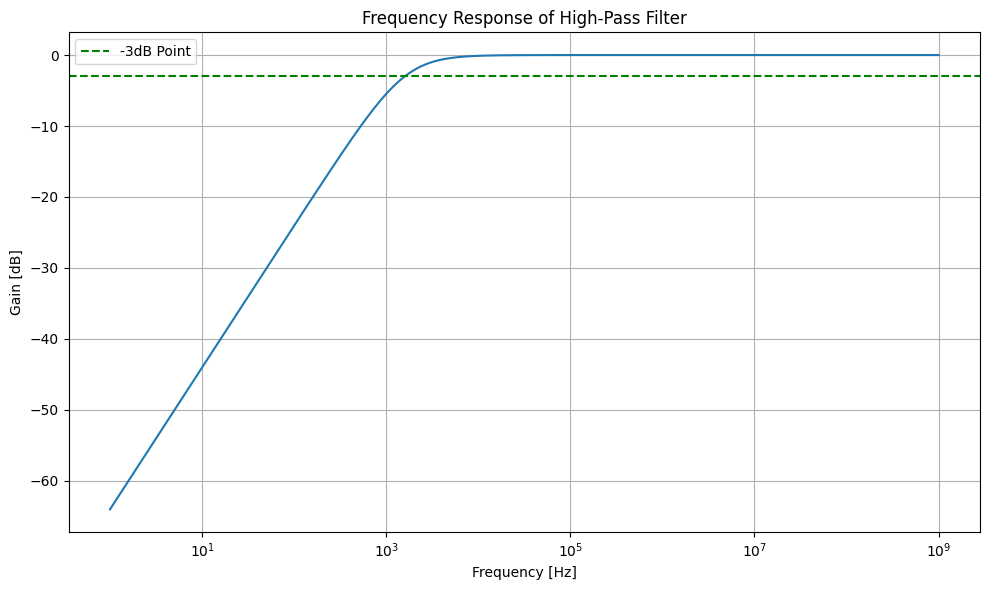

In [21]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Passive High-Pass Filter')
# Input voltage source (DC for operating point)
circuit.V('in', 'Vin', circuit.gnd, 1.0) # 1V DC
# Capacitor in series with input
circuit.C('1', 'Vin', 'Vout', 10@u_nF)
# Resistor from output to ground
circuit.R('1', 'Vout', circuit.gnd, 10@u_kΩ)
simulator = circuit.simulator()
has_vin = False
for element in circuit.elements:
    if "vin" in element.name.lower():
        element.dc_value = "dc 2.5 ac 1"
        has_vin = True
        break

if not has_vin:
    circuit.V('in', 'Vin', circuit.gnd, dc_value=0, ac_value=1)

import sys
import numpy as np
import matplotlib.pyplot as plt
try:
    # Only AC analysis
    ac_analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_GHz, 
                              number_of_points=1000, variation='dec')
except:
    print("Analysis failed.")
    sys.exit(2)

# Get frequency response data
frequencies = np.array(ac_analysis.frequency)

node = 'Vout'

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

vout_ac = np.array(ac_analysis[node])
gain_db = 20 * np.log10(np.abs(vout_ac))
phase = np.angle(vout_ac, deg=True)

# Create frequency domain plot
plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, gain_db)
plt.title('Frequency Response of High-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid(True)

plt.axhline(y=-3, color='g', linestyle='--', label='-3dB Point')
plt.legend()

plt.tight_layout()
plt.savefig('p11_figure.png')

# Basic High-Pass Filter Verification - Including Monotonicity Check
# 1. Check High-Frequency Gain
high_freq_gain = gain_db[-1]  # Gain at highest frequency
print(f"Gain at highest frequency ({frequencies[-1]:.2f} Hz): {high_freq_gain:.2f} dB")

# 2. Check low frequency attenuation
low_freq_gain = gain_db[0]  # Gain at lowest frequency
print(f"Gain at lowest frequency ({frequencies[0]:.2f} Hz): {low_freq_gain:.2f} dB")
low_freq_attenuation = high_freq_gain - low_freq_gain
print(f"Low frequency attenuation: {low_freq_attenuation:.2f} dB")

# 3. Find the approximate -3dB point
idx_3db = np.argmin(np.abs(gain_db - (high_freq_gain-3)))
cutoff_freq = frequencies[idx_3db]
print(f"Approximate -3dB cutoff frequency: {cutoff_freq:.2f} Hz")

# 4. Check monotonicity
# Use smoothing to reduce measurement noise
window_size = min(11, len(gain_db) // 20)  #  Use window smoothing
if window_size % 2 == 0:  # Ensure window size is odd
    window_size += 1
    
if window_size > 2:  # If there are enough points to smooth
    from scipy.signal import savgol_filter
    smoothed_gain = savgol_filter(gain_db, window_size, 1)  # Use 1st order polynomial smoothing
else:
    smoothed_gain = gain_db
    
# Calculate the difference of the smoothed gain - note that a high-pass filter should increase with frequency
diff_gain = np.diff(smoothed_gain)
non_monotonic_points = np.sum(diff_gain < -0.5)  # Allow a small decrease of 0.5dB

if non_monotonic_points > 0:
    monotonic_percentage = 100 * (1 - non_monotonic_points / len(diff_gain))
    print(f"Warning: Gain is not strictly monotonically increasing.")
    print(f"Monotonicity: {monotonic_percentage:.1f}% of frequency points")
    if monotonic_percentage < 90:  # if non-monotonic points exceed 10%
        print("This may not be a well-behaved high-pass filter.")
else:
    print("Filter response is monotonically increasing with frequency, as expected.")

# 5. Determine if it meets high-pass characteristics
if low_freq_attenuation > 2 and (non_monotonic_points == 0 or monotonic_percentage >= 90):
    print("The circuit exhibits proper high-pass filter characteristics.")
    sys.exit(0)
else:
    print("The circuit does not show expected high-pass filter characteristics.")
    sys.exit(2)

Maximum gain: -9.54 dB at frequency 1.59e+03 Hz
Relative position in frequency range: 0.36
Average stopband gain: -56.13 dB
Calculated peak boost: 46.59 dB
Left side average gain: -33.06 dB
Right side average gain: -58.56 dB
PASS: This is a band-pass filter.
Center frequency: 1.59e+03 Hz
Peak gain: -9.54 dB
Peak boost: 46.59 dB above stopband
This appears to be a high-Q resonant band-pass filter.


SystemExit: 0

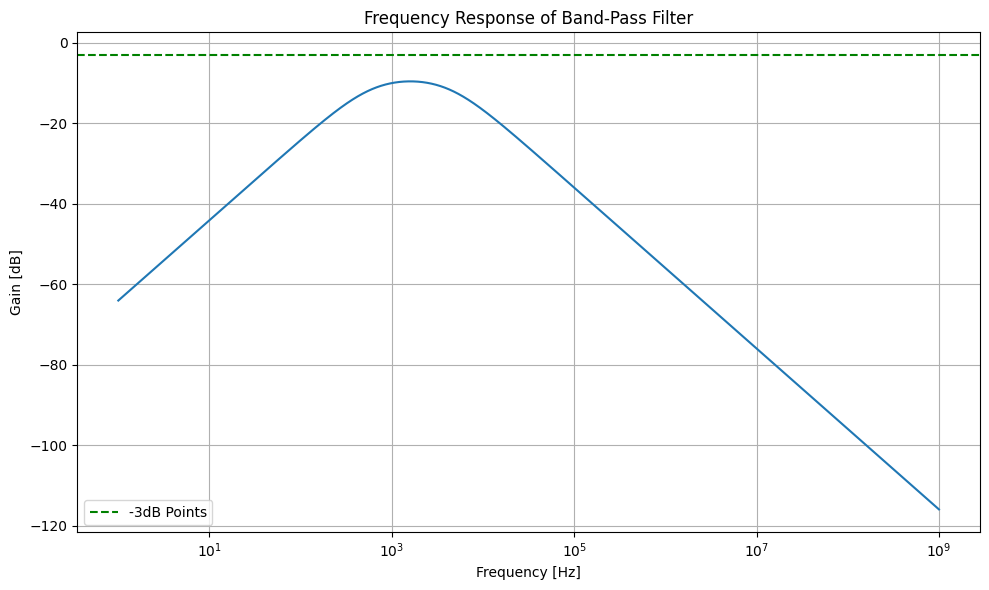

In [22]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Passive Band-Pass Filter')
# Input voltage source (DC for operating point)
circuit.V('in', 'Vin', circuit.gnd, 1.0)  # 1V DC
# High-Pass Filter Stage
circuit.C('1', 'Vin', 'N1', 10@u_nF)      # C1: 10 nF
circuit.R('1', 'N1', circuit.gnd, 10@u_kΩ) # R1: 10 kΩ
# Low-Pass Filter Stage
circuit.R('2', 'N1', 'Vout', 10@u_kΩ)     # R2: 10 kΩ
circuit.C('2', 'Vout', circuit.gnd, 10@u_nF) # C2: 10 nF
simulator = circuit.simulator()
has_vin = False
for element in circuit.elements:
    if "vin" in element.name.lower():
        element.dc_value = "dc 2.5 ac 1"
        has_vin = True
        break

if not has_vin:
    circuit.V('in', 'Vin', circuit.gnd, dc_value=0, ac_value=1)

import sys
import numpy as np
import matplotlib.pyplot as plt
try:
    # Only AC analysis
    ac_analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_GHz, 
                              number_of_points=1000, variation='dec')
except:
    print("Analysis failed.")
    sys.exit(2)

node = 'Vout'
has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

# Get frequency response data
frequencies = np.array(ac_analysis.frequency)
vout_ac = np.array(ac_analysis[node])
gain_db = 20 * np.log10(np.abs(vout_ac)+1e-12)  # Avoid log(0)
phase = np.angle(vout_ac, deg=True)

# Create frequency domain plot
plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, gain_db)
plt.title('Frequency Response of Band-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid(True)

plt.axhline(y=-3, color='g', linestyle='--', label='-3dB Points')
plt.legend()

plt.tight_layout()
plt.savefig('p12_waveform.png')

max_gain_idx = np.argmax(gain_db)
max_gain = gain_db[max_gain_idx]
peak_freq = frequencies[max_gain_idx]

print(f"Maximum gain: {max_gain:.2f} dB at frequency {peak_freq:.2e} Hz")

relative_position = max_gain_idx / len(frequencies)
print(f"Relative position in frequency range: {relative_position:.2f}")

min_peak_boost = 10  # dB

high_gain_mask = gain_db > (max_gain - min_peak_boost/2)
low_gain_points = gain_db[~high_gain_mask]
avg_stopband_gain = np.mean(low_gain_points) if len(low_gain_points) > 0 else 0

peak_boost = max_gain - avg_stopband_gain

print(f"Average stopband gain: {avg_stopband_gain:.2f} dB")
print(f"Calculated peak boost: {peak_boost:.2f} dB")

left_side = gain_db[:max_gain_idx]
right_side = gain_db[max_gain_idx+1:]

min_side_length = max(5, len(gain_db) * 0.05)

if len(left_side) < min_side_length or len(right_side) < min_side_length:
    print("WARNING: Peak is very close to frequency range boundary.")

left_avg = np.mean(left_side) if len(left_side) >= min_side_length else None
right_avg = np.mean(right_side) if len(right_side) >= min_side_length else None

left_lower = (left_avg is not None) and (left_avg < max_gain - min_peak_boost)
right_lower = (right_avg is not None) and (right_avg < max_gain - min_peak_boost)

if left_avg is not None:
    print(f"Left side average gain: {left_avg:.2f} dB")
if right_avg is not None:
    print(f"Right side average gain: {right_avg:.2f} dB")

if peak_boost >= min_peak_boost and (left_lower and right_lower):
    print("PASS: This is a band-pass filter.")
    print(f"Center frequency: {peak_freq:.2e} Hz")
    print(f"Peak gain: {max_gain:.2f} dB")
    print(f"Peak boost: {peak_boost:.2f} dB above stopband")
    
    threshold = max_gain - 3
    
    if peak_boost > 30:
        print("This appears to be a high-Q resonant band-pass filter.")
    
    sys.exit(0)
else:
    print("FAIL: This is NOT a band-pass filter.")
    
    if not (left_lower and right_lower):
        if left_lower and not right_lower:
            print("Only left side has low gain - may be a high-pass filter.")
        elif right_lower and not left_lower:
            print("Only right side has low gain - may be a low-pass filter.")
        else:
            print("Neither side shows significantly lower gain.")
    
    if peak_boost < min_peak_boost:
        print(f"The gain variation ({peak_boost:.2f} dB) is insufficient for a band-pass filter.")
    
    if relative_position < 0.1 or relative_position > 0.9:
        if relative_position < 0.1:
            print("Maximum gain is at the low frequency end - likely a low-pass filter.")
        else:
            print("Maximum gain is at the high frequency end - likely a high-pass filter.")
    
    sys.exit(2)

Minimum gain: -61.64 dB at frequency 1.59e+04 Hz
Relative position in frequency range: 0.47
Average passband gain: -0.57 dB
Calculated notch depth: 61.07 dB
Left side average gain: -0.61 dB
Right side average gain: -0.53 dB
PASS: This is a band-stop filter.
Notch frequency: 1.59e+04 Hz
Notch depth: 61.07 dB
This appears to be a deep notch filter.


SystemExit: 0

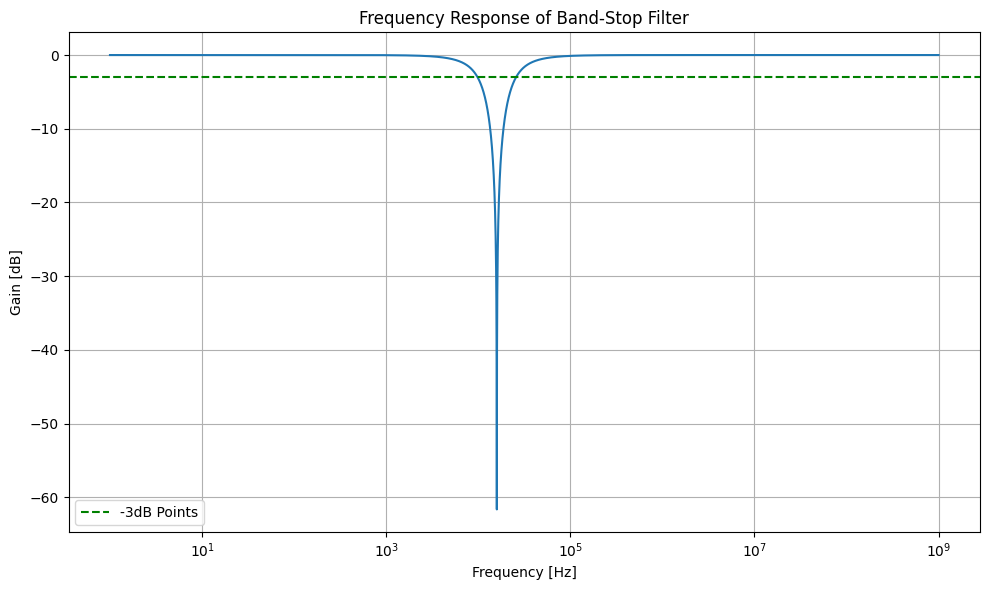

In [23]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Passive Band-Stop Filter')
# Input voltage source (DC for operating point)
circuit.V('in', 'Vin', circuit.gnd, 1.0)
# Series resistor R1 between Vin and Vout
circuit.R('1', 'Vin', 'Vout', 1@u_kΩ)
# Series LC branch from Vout to ground for notch
# Create an intermediate node for series connection
circuit.L('1', 'Vout', 'N1', 10@u_mH)   # L1 from Vout to N1
circuit.C('1', 'N1', circuit.gnd, 10@u_nF)  # C1 from N1 to ground
# Output node is 'Vout' by definition above
simulator = circuit.simulator()
has_vin = False
for element in circuit.elements:
    if "vin" in element.name.lower():
        element.dc_value = "dc 2.5 ac 1"
        has_vin = True
        break

if not has_vin:
    circuit.V('in', 'Vin', circuit.gnd, dc_value=0, ac_value=1)

import sys
import numpy as np
import matplotlib.pyplot as plt
try:
    # Only AC analysis
    ac_analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_GHz, 
                              number_of_points=1000, variation='dec')
except:
    print("Analysis failed.")
    sys.exit(2)


node = 'Vout'
has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

# Get frequency response data
frequencies = np.array(ac_analysis.frequency)
vout_ac = np.array(ac_analysis[node])
gain_db = 20 * np.log10(np.abs(vout_ac)+1e-12)  # Avoid log(0)
phase = np.angle(vout_ac, deg=True)

# Create frequency domain plot
plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, gain_db)
plt.title('Frequency Response of Band-Stop Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid(True)

plt.axhline(y=-3, color='g', linestyle='--', label='-3dB Points')
plt.legend()

plt.tight_layout()
plt.savefig('p13_waveform.png')


min_gain_idx = np.argmin(gain_db)
min_gain = gain_db[min_gain_idx]
notch_freq = frequencies[min_gain_idx]

print(f"Minimum gain: {min_gain:.2f} dB at frequency {notch_freq:.2e} Hz")

relative_position = min_gain_idx / len(frequencies)
print(f"Relative position in frequency range: {relative_position:.2f}")

min_notch_depth = 10  # dB

low_gain_mask = gain_db < (min_gain + min_notch_depth/2)
high_gain_points = gain_db[~low_gain_mask]
avg_passband_gain = np.mean(high_gain_points) if len(high_gain_points) > 0 else 0

# Notch depth
notch_depth = avg_passband_gain - min_gain

print(f"Average passband gain: {avg_passband_gain:.2f} dB")
print(f"Calculated notch depth: {notch_depth:.2f} dB")

# Check if both sides have high gain regions
left_side = gain_db[:min_gain_idx]
right_side = gain_db[min_gain_idx+1:]

# If either side is too short, it may be a boundary stopband issue
min_side_length = max(5, len(gain_db) * 0.05)  # At least 5 points or 5% of the frequency range

if len(left_side) < min_side_length or len(right_side) < min_side_length:
    print("WARNING: Notch is very close to frequency range boundary.")

left_avg = np.mean(left_side) if len(left_side) >= min_side_length else None
right_avg = np.mean(right_side) if len(right_side) >= min_side_length else None

left_higher = (left_avg is not None) and (left_avg > min_gain + min_notch_depth)
right_higher = (right_avg is not None) and (right_avg > min_gain + min_notch_depth)

if left_avg is not None:
    print(f"Left side average gain: {left_avg:.2f} dB")
if right_avg is not None:
    print(f"Right side average gain: {right_avg:.2f} dB")

if notch_depth >= min_notch_depth and (left_higher and right_higher):
    print("PASS: This is a band-stop filter.")
    print(f"Notch frequency: {notch_freq:.2e} Hz")
    print(f"Notch depth: {notch_depth:.2f} dB")
    
    threshold = avg_passband_gain - 3
    
    if notch_depth > 30:
        print("This appears to be a deep notch filter.")
    
    sys.exit(0)
else:
    print("FAIL: This is NOT a band-stop filter.")
    
    if not (left_higher and right_higher):
        if left_higher and not right_higher:
            print("Only left side has high gain - may be a low-pass filter.")
        elif right_higher and not left_higher:
            print("Only right side has high gain - may be a high-pass filter.")
        else:
            print("Neither side shows significantly higher gain.")
    
    if notch_depth < min_notch_depth:
        print(f"The gain variation ({notch_depth:.2f} dB) is insufficient for a band-stop filter.")
    
    sys.exit(2)

In [2]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Two-Stage Amplifier with Miller Compensation')
# Define power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Define bias voltage for active load
circuit.V('bias', 'Vbias', circuit.gnd, 2.5@u_V)
# Transistor models
circuit.model('nmos', 'nmos', level=1, vto=0.5, kp=100e-6)
circuit.model('pmos', 'pmos', level=1, vto=-0.5, kp=50e-6)
# First Stage: NMOS common-source with PMOS active load
# M1: NMOS input transistor
circuit.MOSFET('M1', 'Vmid', 'Vin', 'gnd', 'gnd', model='nmos', w=10e-6, l=1e-6)
# M2: PMOS active load
circuit.MOSFET('M2', 'Vmid', 'Vbias', 'Vdd', 'Vdd', model='pmos', w=20e-6, l=1e-6)
# Second Stage: NMOS common-source
circuit.MOSFET('M3', 'Vout', 'Vmid', 'gnd', 'gnd', model='nmos', w=10e-6, l=1e-6)
# Load resistor for second stage
circuit.R('load', 'Vout', 'Vdd', 10@u_kΩ)
# Miller Compensation Capacitor
circuit.C('miller', 'Vmid', 'Vout', 1@u_pF)
# Input source
circuit.V('in', 'Vin', circuit.gnd, "dc 1@u_V ac 1n")
# Connect all components properly
# (Connections are made via node names above)
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p14_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = 'vout'

# find whether vout in the circuit

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Voltage Gain (Av) at 100 Hz: {gain}")

required_gain = 1e-5
import sys
if gain > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)
else:
    print("The circuit does not function correctly.\n"
          "the gain is less than 1e-5.\n"
          "Please fix the wrong operating point.\n")
    sys.exit(2)

Voltage Gain (Av) at 100 Hz: 0.00651141198696116
The circuit functions correctly at 100 Hz.



SystemExit: 0

In [3]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
# Define the circuit
circuit = Circuit('Single-Stage Common-Source with PMOS Diode-Connected Load')
# Define NMOS and PMOS models
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
circuit.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Input voltage
circuit.V('in', 'Vin', circuit.gnd, "dc 1@u_V ac 1n")
# Single NMOS transistor (M1)
# Drain connected to Vout, Gate to Vin, Source to GND
circuit.MOSFET('M1', 'Vout', 'Vin', circuit.gnd, circuit.gnd,
               model='nmos_model', w=50e-6, l=1e-6)
# PMOS diode-connected load (M2)
# Drain and Gate connected together, Source to Vdd
circuit.MOSFET('M2', 'Vout', 'Vout', 'Vdd', 'Vdd',
               model='pmos_model', w=50e-6, l=1e-6)
# Note: The drain of M1 and M2 is at Vout
# The source of M1 is GND
# The source of M2 is Vdd
# The diode connection for M2 is achieved by connecting gate and drain together
# The output node is Vout
# Ready for simulation
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p15_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = 'vout'

# find whether vout in the circuit

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Voltage Gain (Av) at 100 Hz: {gain}")

required_gain = 1e-5
import sys
if gain > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)
else:
    print("The circuit does not function correctly.\n"
          "the gain is less than 1e-5.\n"
          "Please fix the wrong operating point.\n")
    sys.exit(2)

Voltage Gain (Av) at 100 Hz: 1.4142135576957744
The circuit functions correctly at 100 Hz.



SystemExit: 0

In [4]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Differential Opamp with PMOS Current Mirror Load')
# MOSFET models
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
circuit.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Differential inputs and bias
circuit.V('inp', 'Vinp', circuit.gnd, "dc 1.0 ac 1n")
circuit.V('inn', 'Vinn', circuit.gnd, "dc 1.0 ac 1n")
circuit.V('bias', 'Vbias', circuit.gnd, 1.0)
# Tail current source (NMOS)
circuit.MOSFET('tail', 'Stail', 'Vbias', circuit.gnd, circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
# Differential pair (NMOS)
circuit.MOSFET('1', 'Voutp', 'Vinp', 'Stail', 'Stail', model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('2', 'Vout', 'Vinn', 'Stail', 'Stail', model='nmos_model', w=50e-6, l=1e-6)
# PMOS current mirror load
circuit.MOSFET('3', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
circuit.MOSFET('4', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p16_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = "Vout"

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Common-Mode Gain (Av) at 100 Hz: {gain}")

vinn_name = ""
for element in circuit.elements:
    # print("element name", element.name)
    # for pin in element.pins:
    #     print("pin name", pin.node)
    if "vinn" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vinn_name = element.name


circuit.element(vinn_name).dc_value += " 180"

simulator2 = circuit.simulator()
analysis2 = simulator2.ac(start_frequency=frequency, stop_frequency=frequency, 
                        number_of_points=1, variation='dec')

output_voltage2 = np.abs(analysis2[node].as_ndarray()[0])
gain2 = output_voltage2 / (1e-9)

print(f"Differential-Mode Gain (Av) at 100 Hz: {gain2}")

required_gain = 1e-5
import sys

if gain < gain2 - 1e-5 and gain2 > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)

if gain >= gain2 - 1e-5:
    print("Common-Mode gain is larger than Differential-Mode gain.\n")

if gain2 < required_gain:
    print("Differential-Mode gain is smaller than 1e-5.\n")

print("The circuit does not function correctly.\n"
    "Please fix the wrong operating point.\n")
sys.exit(2)

Common-Mode Gain (Av) at 100 Hz: 0.3333332891740889
Differential-Mode Gain (Av) at 100 Hz: 1443375756.0085356
The circuit functions correctly at 100 Hz.



SystemExit: 0

In [5]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Cascode Current Mirror')
# NMOS model (nominal)
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.7)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Reference current source: from Vdd to Iref
circuit.I('ref', 'Vdd', 'Iref', 100@u_uA)
# M1: Bottom input NMOS (diode-connected)
circuit.MOSFET('1', 'N1', 'N1', circuit.gnd, circuit.gnd, model='nmos_model', w=20e-6, l=1e-6)
# M2: Top input NMOS (cascode)
circuit.MOSFET('2', 'Iref', 'Iref', 'N1', 'N1', model='nmos_model', w=20e-6, l=1e-6)
# M3: Bottom output NMOS (mirror)
circuit.MOSFET('3', 'N3', 'N1', circuit.gnd, circuit.gnd, model='nmos_model', w=20e-6, l=1e-6)
# M4: Top output NMOS (cascode)
circuit.MOSFET('4', 'Iout', 'Iref', 'N3', 'N3', model='nmos_model', w=20e-6, l=1e-6)
# Output load resistor
circuit.R('1', 'Iout', 'Vdd', 10@u_kΩ)
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p17_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

load_resistances = [100, 300, 500, 750, 1000]
currents = []

import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Resistor):
        resistor_name = element.name
        node1, node2 = element.nodes
        break


resistor = circuit[resistor_name]
for r_load in load_resistances:
    resistor.resistance = r_load
    analysis = simulator.operating_point()
    if str(node2) == "0":
        current = float(analysis[str(node1)][0]) / r_load
    elif str(node1) == "0":
        current = - float(analysis[str(node2)][0]) / r_load
    else:
        current = - (float(analysis[str(node1)][0]) - float(analysis[str(node2)][0])) / r_load
    currents.append(current)

for r_load, current in zip(load_resistances, currents):
    print(f"Load: {r_load}, Current: {current}")

tolerance = 1e-6

current_variations = []
for i in range(4):
    current_variations.append(abs(currents[i+1] - currents[i]))

import sys
if min(current_variations) < tolerance and min(currents) > 1e-5:
    pass
    # print("The circuit functions correctly as a constant current source within the given tolerance.")
    # sys.exit(0)
else:
    print("The circuit does not function correctly as a current source.")
    sys.exit(2)

iin_name = None
for element in circuit.elements:
    if "ref" in element.name.lower(): # and element.name.lower().startswith("v"):
        iin_name = element.name

# print("iin_name", iin_name)
if iin_name is None:
    print("The circuit functions correctly as a current source within the given tolerance.")
    sys.exit(0)


circuit.element(iin_name).dc_value = "0.00155"

# print(str(circuit))
simulator = circuit.simulator()
resistor.resistance = 500
analysis = simulator.operating_point()
if str(node2) == "0":
    current = float(analysis[str(node1)][0]) / r_load
elif str(node1) == "0":
    current = - float(analysis[str(node2)][0]) / r_load
else:
    current = - (float(analysis[str(node1)][0]) - float(analysis[str(node2)][0])) / r_load

# print("current", current)
# print("currents", currents)
# print("abs(current - currents[2])", abs(current - currents[2]))
if abs(current - currents[2]) < 1e-6:
    print("The circuit does not as a current source because it cannot replicate the Iref current.")
    sys.exit(2)
else:
    print("The circuit functions correctly as a current source within the given tolerance.")
    sys.exit(0)


Load: 100, Current: 9.999999999999786e-05
Load: 300, Current: 0.00010000000000000083
Load: 500, Current: 9.999999999999964e-05
Load: 750, Current: 0.00010000000000000024
Load: 1000, Current: 9.999999999999964e-05
The circuit functions correctly as a current source within the given tolerance.


SystemExit: 0

In [6]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Single-Stage Differential Opamp with Resistive Loads')
# Define NMOS model
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
# Power Supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Input voltages (for DC operating point)
circuit.V('inp', 'Vinp', circuit.gnd, "dc 1.0 ac 1n")
circuit.V('inn', 'Vinn', circuit.gnd, "dc 1.0 ac 1n")
# Bias voltage for tail current source
circuit.V('bias', 'Vbias', circuit.gnd, 1.0) # Vbias = Vth + 0.5V = 1.0V
# Differential Pair
# M1: Drain=Vout, Gate=Vinp, Source=SourceDiff, Bulk=SourceDiff
circuit.MOSFET('1', 'Vout', 'Vinp', 'SourceDiff', 'SourceDiff', model='nmos_model', w=50e-6, l=1e-6)
# M2: Drain=Drain2, Gate=Vinn, Source=SourceDiff, Bulk=SourceDiff
circuit.MOSFET('2', 'Drain2', 'Vinn', 'SourceDiff', 'SourceDiff', model='nmos_model', w=50e-6, l=1e-6)
# Tail current source
# Mtail: Drain=SourceDiff, Gate=Vbias, Source=0, Bulk=0
circuit.MOSFET('tail', 'SourceDiff', 'Vbias', circuit.gnd, circuit.gnd, model='nmos_model', w=20e-6, l=1e-6)
# Load resistors
# R1: Vdd to Vout (drain of M1)
circuit.R('1', 'Vdd', 'Vout', 10@u_kΩ)
# R2: Vdd to Drain2 (drain of M2)
circuit.R('2', 'Vdd', 'Drain2', 10@u_kΩ)
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p18_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = "Vout"

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Common-Mode Gain (Av) at 100 Hz: {gain}")

vinn_name = ""
for element in circuit.elements:
    # print("element name", element.name)
    # for pin in element.pins:
    #     print("pin name", pin.node)
    if "vinn" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vinn_name = element.name


circuit.element(vinn_name).dc_value += " 180"

simulator2 = circuit.simulator()
analysis2 = simulator2.ac(start_frequency=frequency, stop_frequency=frequency, 
                        number_of_points=1, variation='dec')

output_voltage2 = np.abs(analysis2[node].as_ndarray()[0])
gain2 = output_voltage2 / (1e-9)

print(f"Differential-Mode Gain (Av) at 100 Hz: {gain2}")

required_gain = 1e-5
import sys

if gain < gain2 - 1e-5 and gain2 > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)

if gain >= gain2 - 1e-5:
    print("Common-Mode gain is larger than Differential-Mode gain.\n")

if gain2 < required_gain:
    print("Differential-Mode gain is smaller than 1e-5.\n")

print("The circuit does not function correctly.\n"
    "Please fix the wrong operating point.\n")
sys.exit(2)

Common-Mode Gain (Av) at 100 Hz: 1.7010353321939267
Differential-Mode Gain (Av) at 100 Hz: 10.206211895611778
The circuit functions correctly at 100 Hz.



SystemExit: 0

Best Vlop: 2.60 V, Best Voutp: 3.57 V
Performing transient analysis to obtain mixing output...

FFT Analysis Results - Major Frequency Components:
Frequency: 196.7 Hz, Magnitude: 0.032878 V
Frequency: 2213.1 Hz, Magnitude: 0.029890 V
Frequency: 2163.9 Hz, Magnitude: 0.012294 V
Frequency: 2114.8 Hz, Magnitude: 0.005772 V
Frequency: 2262.3 Hz, Magnitude: 0.005437 V

Detected down-conversion IF signal (LO-RF): 196.7 Hz, Magnitude: 0.032878 V

Detected down-conversion IF signal (LO-RF): 245.9 Hz, Magnitude: 0.004307 V
Detected up-conversion IF signal (LO+RF): 2163.9 Hz, Magnitude: 0.012294 V
Detected up-conversion IF signal (LO+RF): 2213.1 Hz, Magnitude: 0.029890 V

Mixer functioning correctly: Mixing products detected!
Down-conversion gain: 14.14 dB
Up-conversion gain: 30.97 dB
LO rejection ratio: 20.05 dB

Mixer performance assessment:
✓ Down-conversion functioning properly
✓ Up-conversion functioning properly
The Gilbert Cell Mixer is functioning correctly.
Plots saved as 'mixer_analysi

SystemExit: 0

/home/irman/anaconda3/envs/chipster_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


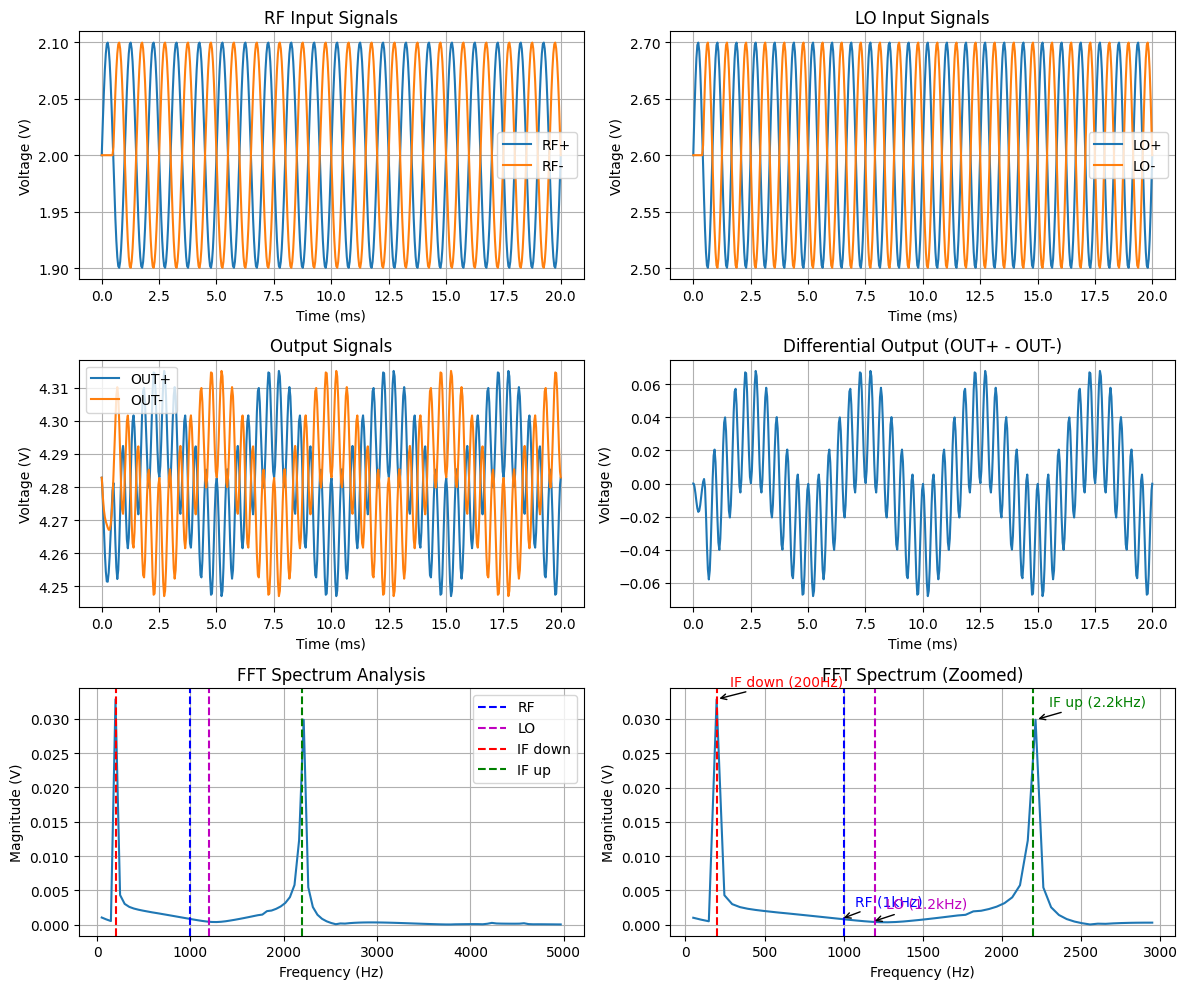

In [7]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Gilbert Cell Mixer')
# Define the MOSFET models
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.7)
# Power Supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)  # 5V power supply
circuit.V('bias', 'Vbias', circuit.gnd, 1.5)  # Bias voltage for current source (Vth + 0.8V)
# RF and LO Input Voltages (DC bias points)
circuit.V('rfp', 'Vrfp', circuit.gnd, 2.5)  # RF+ input biased at mid-supply
circuit.V('rfn', 'Vrfn', circuit.gnd, 2.5)  # RF- input biased at mid-supply
circuit.V('lop', 'Vlop', circuit.gnd, 3.0)  # LO+ input biased above threshold
circuit.V('lon', 'Vlon', circuit.gnd, 2.0)  # LO- input biased below LO+
# Load Resistors
circuit.R('L1', 'Vdd', 'Voutp', 1@u_kΩ)
circuit.R('L2', 'Vdd', 'Voutn', 1@u_kΩ)
# Current Source Transistor
circuit.MOSFET('7', 'SourceNode', 'Vbias', circuit.gnd, circuit.gnd, model='nmos_model', w=100e-6, l=1e-6)
# RF Differential Pair
circuit.MOSFET('1', 'RFp_out', 'Vrfp', 'SourceNode', circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('2', 'RFn_out', 'Vrfn', 'SourceNode', circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
# LO Switching Quad
circuit.MOSFET('3', 'Voutp', 'Vlop', 'RFp_out', circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('4', 'Voutp', 'Vlon', 'RFn_out', circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('5', 'Voutn', 'Vlon', 'RFp_out', circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('6', 'Voutn', 'Vlop', 'RFn_out', circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
# Analysis Part
simulator = circuit.simulator()
# Gilbert Cell Mixer Functionality Test with FFT Analysis
import sys
import numpy as np

detached_voltage_source = ['Vrfp', 'Vrfn', 'Vlop', 'Vlon']
for source in detached_voltage_source:
    circuit.element(source).detach()

# connected Vrfn and Vrfp
circuit.V('rfp', 'Vrfp', circuit.gnd, 2.0@u_V)
circuit.V('rfn', 'Vrfn', 'Vrfp', 0.0@u_V)

# connected Vlop and Vlon
circuit.V('lop', 'Vlop', circuit.gnd, 4.0@u_V)
circuit.V('lon', 'Vlon', 'Vlop', 0.0@u_V)

# Sweep the Vlop to get the operating point
simulator_dc = circuit.simulator(temperature=25, nominal_temperature=25)
try:
    analysis = simulator_dc.dc(Vlop=slice(0, 5, 0.1))
except Exception as e:
    print(f"Error during DC simulation: {e}")
    sys.exit(2)

# find the best operating point
voutp = np.array(analysis['Voutp'])
vlop = np.array(analysis['Vlop'])


# find the best operating point for Vrfp which can make the Voutp closest to 2.5V
best_i = 0
best_vlop = 2.5
for i in range(len(voutp)):
    # If current voutp is closer to 2.5V than the previously found best
    if abs(voutp[i] - 2.5) < abs(voutp[best_i] - 2.5):
        best_i = i
        best_vlop = vlop[i]
        best_voutp = voutp[i]
    # If current voutp is equally distant from 2.5V as the previously found best
    elif abs(voutp[i] - 2.5) == abs(voutp[best_i] - 2.5):
        # When multiple vlop values meet the requirements, we need to select the one with voutp closest to 2.5V
        # Since abs(voutp[i] - 2.5) == abs(voutp[best_i] - 2.5), we need to compare actual values
        # Choose the one closer to 2.5V (to handle cases where one is above 2.5 and one is below)
        if abs(voutp[i] - 2.5) == (voutp[i] - 2.5):  # Current value is >= 2.5
            if abs(voutp[best_i] - 2.5) != (voutp[best_i] - 2.5) or vlop[i] > best_vlop:
                best_i = i
                best_vlop = vlop[i]
                best_voutp = voutp[i]


print(f"Best Vlop: {best_vlop:.2f} V, Best Voutp: {best_voutp:.2f} V")

detached_voltage_source = ['Vrfp', 'Vrfn', 'Vlop', 'Vlon']
for source in detached_voltage_source:
    circuit.element(source).detach()

circuit.SinusoidalVoltageSource('rfp', 'Vrfp', circuit.gnd,
                              amplitude=0.1@u_V, frequency=1@u_kHz,
                              dc_offset=2.0@u_V, offset = 2.0@u_V,
                              ac_magnitude=0.1@u_V,
                              delay=0)
circuit.SinusoidalVoltageSource('rfn', 'Vrfn', circuit.gnd,
                              amplitude=0.1@u_V, frequency=1@u_kHz,
                              dc_offset=2.0@u_V, offset = 2.0@u_V,
                              ac_magnitude=0.1@u_V,
                              delay=0.5@u_ms)
circuit.SinusoidalVoltageSource('lop', 'Vlop', circuit.gnd,
                                amplitude=0.1@u_V, frequency=1.2@u_kHz,
                                dc_offset=best_vlop@u_V, offset = best_vlop@u_V,
                                ac_magnitude=0.1@u_V,
                                delay=0)
circuit.SinusoidalVoltageSource('lon', 'Vlon', circuit.gnd,
                                amplitude=0.1@u_V, frequency=1.2@u_kHz,
                                dc_offset=best_vlop@u_V, offset = best_vlop@u_V,
                                ac_magnitude=0.1@u_V,
                                delay=1/(2*1.2e3)@u_s)


circuit.R('R_filter_p', 'Voutp', 'Vdd', 1@u_kOhm)
circuit.C('C_filter_p', 'Voutp', 'Vdd', 10@u_nF)

circuit.R('R_filter_n', 'Voutn', 'Vdd', 1@u_kOhm)
circuit.C('C_filter_n', 'Voutn', 'Vdd', 10@u_nF)


simulator = circuit.simulator()

# Perform transient analysis to get mixer output
print("Performing transient analysis to obtain mixing output...")
sampling_rate = 1 / (20 * 1.2e3)  # Sampling rate 20x higher than LO frequency
simulation_time = 20e-3  # Observe 20ms, multiple cycles of RF and LO
try:
    analysis = simulator.transient(step_time=sampling_rate, end_time=simulation_time)
except Exception as e:
    print(f"Error during transient simulation: {e}")
    sys.exit(2)

# Extract signals
time = analysis.time
voutp = analysis['Voutp']
voutn = analysis['Voutn']
vlop = analysis['Vlop']
vlon = analysis['Vlon']
vrfp = analysis['Vrfp']
vrfn = analysis['Vrfn']
vout_diff = voutp - voutn  # Differential output

# Perform FFT analysis

from scipy.fft import fft
from matplotlib import pyplot as plt

# Calculate FFT
n = len(time)
fft_vout = fft(vout_diff)
fft_magnitude = np.abs(fft_vout) / n * 2  # Normalize magnitude
freq = np.fft.fftfreq(n, sampling_rate)  # Frequency axis

# Keep only positive frequencies
positive_freq_mask = freq > 0
freq = freq[positive_freq_mask]
fft_magnitude = fft_magnitude[positive_freq_mask]

# Output major frequency components
print("\nFFT Analysis Results - Major Frequency Components:")
# Find top 5 frequency components
indices = np.argsort(fft_magnitude)[::-1][:5]
for i in indices:
    print(f"Frequency: {freq[i]:.1f} Hz, Magnitude: {fft_magnitude[i]:.6f} V")

# Check for mixing products
rf_freq = 1e3  # 1 kHz
lo_freq = 1.2e3  # 1.2 kHz
expected_if_down = abs(lo_freq - rf_freq)  # Down-conversion: 200 Hz
expected_if_up = lo_freq + rf_freq  # Up-conversion: 2.2 kHz

# Search for expected IF frequencies in FFT results
tolerance = 50  # Hz
found_if_down = False
found_if_up = False
if_down_magnitude = 0
if_up_magnitude = 0

for i, f in enumerate(freq):
    if abs(f - expected_if_down) < tolerance and fft_magnitude[i] > 1e-4:
        found_if_down = True
        if_down_magnitude = fft_magnitude[i]
        print(f"\nDetected down-conversion IF signal (LO-RF): {f:.1f} Hz, Magnitude: {if_down_magnitude:.6f} V")
    
    if abs(f - expected_if_up) < tolerance and fft_magnitude[i] > 1e-4:
        found_if_up = True
        if_up_magnitude = fft_magnitude[i]
        print(f"Detected up-conversion IF signal (LO+RF): {f:.1f} Hz, Magnitude: {if_up_magnitude:.6f} V")

# Plot transient simulation and FFT results
plt.figure(figsize=(12, 10))

# Subplot 1: Input signals - RF pair
plt.subplot(3, 2, 1)
plt.plot(time*1000, vrfp, label='RF+')
plt.plot(time*1000, vrfn, label='RF-')
plt.title('RF Input Signals')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)

# Subplot 2: Input signals - LO pair
plt.subplot(3, 2, 2)
plt.plot(time*1000, vlop, label='LO+')
plt.plot(time*1000, vlon, label='LO-')
plt.title('LO Input Signals')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)

# Subplot 3: Output signals - Voutp, Voutn
plt.subplot(3, 2, 3)
plt.plot(time*1000, voutp, label='OUT+')
plt.plot(time*1000, voutn, label='OUT-')
plt.title('Output Signals')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)

# Subplot 4: Differential output
plt.subplot(3, 2, 4)
plt.plot(time*1000, vout_diff)
plt.title('Differential Output (OUT+ - OUT-)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.grid(True)

# Subplot 5: FFT of differential output - Full spectrum
plt.subplot(3, 2, 5)
max_freq_display = 5000  # Limit to 5kHz for better visibility
mask = freq < max_freq_display
plt.plot(freq[mask], fft_magnitude[mask])
plt.title('FFT Spectrum Analysis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (V)')
plt.grid(True)

# Mark key frequencies
plt.axvline(x=rf_freq, color='b', linestyle='--', label='RF')
plt.axvline(x=lo_freq, color='m', linestyle='--', label='LO')
if found_if_down:
    plt.axvline(x=expected_if_down, color='r', linestyle='--', label='IF down')
if found_if_up:
    plt.axvline(x=expected_if_up, color='g', linestyle='--', label='IF up')
plt.legend()

# Subplot 6: FFT - Zoomed in on important frequencies
plt.subplot(3, 2, 6)
zoom_mask = (freq < 3000) & (freq > 0)  # Focus on 0-3kHz range
plt.plot(freq[zoom_mask], fft_magnitude[zoom_mask])
plt.title('FFT Spectrum (Zoomed)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (V)')
plt.grid(True)

# Mark and annotate key frequencies in zoomed view
key_freqs = [rf_freq, lo_freq, expected_if_down, expected_if_up]
key_labels = ['RF (1kHz)', 'LO (1.2kHz)', 'IF down (200Hz)', 'IF up (2.2kHz)']
key_colors = ['b', 'm', 'r', 'g']

for f, label, color in zip(key_freqs, key_labels, key_colors):
    if f < 3000:  # Only mark if in zoomed range
        plt.axvline(x=f, color=color, linestyle='--')
        # Find closest frequency in our FFT data
        idx = np.argmin(np.abs(freq - f))
        if idx < len(freq) and zoom_mask[idx]:
            plt.annotate(label, 
                         xy=(freq[idx], fft_magnitude[idx]),
                         xytext=(10, 10), 
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'),
                         color=color)

plt.tight_layout()
plt.savefig('p19_waveform.png')
# plt.show()

# Evaluate mixer performance
if found_if_down or found_if_up:
    print("\nMixer functioning correctly: Mixing products detected!")
    
    # Calculate conversion efficiency
    rf_index = np.argmin(np.abs(freq - rf_freq))
    rf_magnitude = fft_magnitude[rf_index]
    
    if found_if_down:
        conversion_gain_down = 20 * np.log10(if_down_magnitude / rf_magnitude)
        print(f"Down-conversion gain: {conversion_gain_down:.2f} dB")
    
    if found_if_up:
        conversion_gain_up = 20 * np.log10(if_up_magnitude / rf_magnitude)
        print(f"Up-conversion gain: {conversion_gain_up:.2f} dB")
    
    # Evaluate LO leakage
    lo_index = np.argmin(np.abs(freq - lo_freq))
    lo_leakage = fft_magnitude[lo_index]
    if found_if_down:
        lo_rejection = 20 * np.log10(if_down_magnitude / lo_leakage)
        print(f"LO rejection ratio: {lo_rejection:.2f} dB")
    
    # Overall evaluation
    print("\nMixer performance assessment:")
    if found_if_down and if_down_magnitude > 1e-3:
        print("✓ Down-conversion functioning properly")
    if found_if_up and if_up_magnitude > 1e-3:
        print("✓ Up-conversion functioning properly")
    
    print("The Gilbert Cell Mixer is functioning correctly.")
    print("Plots saved as 'mixer_analysis.png'")
    sys.exit(0)  # Exit with success status code
else:
    print("\nMixer malfunction: Expected mixing products not detected!")
    print("Check the following possible issues:")
    print("1. RF and LO signal amplitudes might be insufficient")
    print("2. Circuit connections might be incorrect")
    print("Plots saved as 'mixer_analysis.png'")
    sys.exit(2)  # Exit with error status code

In [8]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Two-Stage Differential Opamp')
# MOSFET models
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
circuit.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Differential inputs
circuit.V('inp', 'Vinp', circuit.gnd, "dc 2.5 ac 1n")
circuit.V('inn', 'Vinn', circuit.gnd, "dc 2.5 ac 1n")
# Bias voltages
circuit.V('b1', 'Vbias1', circuit.gnd, 1.0)   # NMOS bias
circuit.V('b2', 'Vbias2', circuit.gnd, 4.0)   # PMOS current mirror bias
circuit.V('b3', 'Vbias3', circuit.gnd, 4.0)   # PMOS second stage bias
# First Stage: Differential pair with current mirror load and tail current
circuit.MOSFET('1', 'Voutp', 'Vinp', 'Stail', 'Stail', model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('2', 'Outn', 'Vinn', 'Stail', 'Stail', model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('3', 'Stail', 'Vbias1', circuit.gnd, circuit.gnd, model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('4', 'Voutp', 'Vbias2', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
circuit.MOSFET('5', 'Outn', 'Vbias2', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
# Second Stage: Common-source with active load
circuit.MOSFET('6', 'Vout', 'Voutp', circuit.gnd, circuit.gnd, model='nmos_model', w=100e-6, l=1e-6)
circuit.MOSFET('7', 'Vout', 'Vbias3', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
# PMOS bias diode for M7, with resistor to ground to ensure V_DS > 0
circuit.MOSFET('8', 'Nbias', 'Vbias3', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
circuit.R('b', 'Nbias', circuit.gnd, 10@u_kΩ)
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p20_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = "Vout"

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Common-Mode Gain (Av) at 100 Hz: {gain}")

vinn_name = ""
for element in circuit.elements:
    # print("element name", element.name)
    # for pin in element.pins:
    #     print("pin name", pin.node)
    if "vinn" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vinn_name = element.name


circuit.element(vinn_name).dc_value += " 180"

simulator2 = circuit.simulator()
analysis2 = simulator2.ac(start_frequency=frequency, stop_frequency=frequency, 
                        number_of_points=1, variation='dec')

output_voltage2 = np.abs(analysis2[node].as_ndarray()[0])
gain2 = output_voltage2 / (1e-9)

print(f"Differential-Mode Gain (Av) at 100 Hz: {gain2}")

required_gain = 1e-5
import sys

if gain < gain2 - 1e-5 and gain2 > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)

if gain >= gain2 - 1e-5:
    print("Common-Mode gain is larger than Differential-Mode gain.\n")

if gain2 < required_gain:
    print("Differential-Mode gain is smaller than 1e-5.\n")

print("The circuit does not function correctly.\n"
    "Please fix the wrong operating point.\n")
sys.exit(2)

Common-Mode Gain (Av) at 100 Hz: 9.373291514808875e-13
Differential-Mode Gain (Av) at 100 Hz: 0.0033139572591607334
The circuit functions correctly at 100 Hz.



SystemExit: 0

In [9]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
circuit = Circuit('Single-Stage Telescopic Cascode Opamp')
# MOSFET Models
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
circuit.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
# Power Supply
circuit.V('dd', 'Vdd', circuit.gnd, 5.0)
# Input sources (DC bias for now)
circuit.V('inp', 'Vinp', circuit.gnd, "dc 1.0 ac 1n")
circuit.V('inn', 'Vinn', circuit.gnd, "dc 1.0 ac 1n")
# Bias voltages (choose values to ensure all devices are in saturation)
circuit.V('bias1', 'Vbias1', circuit.gnd, 0.7)   # Tail NMOS bias (Vgs > Vth)
circuit.V('bias2', 'Vbias2', circuit.gnd, 1.2)   # NMOS cascode bias (> Vth)
circuit.V('bias3', 'Vbias3', circuit.gnd, 4.0)   # PMOS load bias (Vdd - |Vth| - margin)
circuit.V('bias4', 'Vbias4', circuit.gnd, 3.5)   # PMOS cascode bias (Vdd - |Vth| - margin)
# Tail current source NMOS
circuit.MOSFET('9', 'S_tail', 'Vbias1', circuit.gnd, circuit.gnd, model='nmos_model', w=30e-6, l=1e-6)
# Differential input NMOS
circuit.MOSFET('1', 'N1', 'Vinp', 'S_tail', 'S_tail', model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('2', 'N2', 'Vinn', 'S_tail', 'S_tail', model='nmos_model', w=50e-6, l=1e-6)
# NMOS cascode
circuit.MOSFET('3', 'Voutp', 'Vbias2', 'N1', 'N1', model='nmos_model', w=50e-6, l=1e-6)
circuit.MOSFET('4', 'Vout', 'Vbias2', 'N2', 'N2', model='nmos_model', w=50e-6, l=1e-6)
# PMOS active load
circuit.MOSFET('5', 'Voutp', 'Vbias3', 'S5', 'S5', model='pmos_model', w=70e-6, l=1e-6)
circuit.MOSFET('6', 'Vout', 'Vbias3', 'S6', 'S6', model='pmos_model', w=70e-6, l=1e-6)
# PMOS cascode
circuit.MOSFET('7', 'S5', 'Vbias4', 'Vdd', 'Vdd', model='pmos_model', w=70e-6, l=1e-6)
circuit.MOSFET('8', 'S6', 'Vbias4', 'Vdd', 'Vdd', model='pmos_model', w=70e-6, l=1e-6)
simulator = circuit.simulator()

try:
    analysis = simulator.operating_point()
    fopen = open("p21_op.txt", "w")
    for node in analysis.nodes.values(): 
        fopen.write(f"{str(node)}\t{float(analysis[str(node)][0]):.6f}\n")
    fopen.close()
except Exception as e:
    print("Analysis failed due to an error:")
    print(str(e))

simulator_id = circuit.simulator()
mosfet_names = []
import PySpice.Spice.BasicElement
for element in circuit.elements:
    if isinstance(element, PySpice.Spice.BasicElement.Mosfet):
        mosfet_names.append(element.name)

mosfet_name_ids = []
for mosfet_name in mosfet_names:
    mosfet_name_ids.append(f"@{mosfet_name}[id]")

simulator_id.save_internal_parameters(*mosfet_name_ids)
analysis_id = simulator_id.operating_point()

id_correct = 1
for mosfet_name in mosfet_names:
    mosfet_id = float(analysis_id[f"@{mosfet_name}[id]"][0])
    if mosfet_id < 1e-5:
        id_correct = 0
        print("The circuit does not function correctly. "
          "the current I_D for {} is 0. ".format(mosfet_name)
          .format(mosfet_name))

if id_correct == 0:
    print("Please fix the wrong operating point.\n")
    sys.exit(2)


frequency = 100@u_Hz
analysis = simulator.ac(start_frequency=frequency, stop_frequency=frequency*10, 
    number_of_points=2, variation='dec')

import numpy as np

node = "Vout"

has_node = False
# find any node with "vout"
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            node = str(pin.node)
            has_node = True
            break

if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

output_voltage = analysis[node].as_ndarray()[0]
gain = np.abs(output_voltage / (1e-9))

print(f"Common-Mode Gain (Av) at 100 Hz: {gain}")

vinn_name = ""
for element in circuit.elements:
    # print("element name", element.name)
    # for pin in element.pins:
    #     print("pin name", pin.node)
    if "vinn" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vinn_name = element.name


circuit.element(vinn_name).dc_value += " 180"

simulator2 = circuit.simulator()
analysis2 = simulator2.ac(start_frequency=frequency, stop_frequency=frequency, 
                        number_of_points=1, variation='dec')

output_voltage2 = np.abs(analysis2[node].as_ndarray()[0])
gain2 = output_voltage2 / (1e-9)

print(f"Differential-Mode Gain (Av) at 100 Hz: {gain2}")

required_gain = 1e-5
import sys

if gain < gain2 - 1e-5 and gain2 > required_gain:
    print("The circuit functions correctly at 100 Hz.\n")
    sys.exit(0)

if gain >= gain2 - 1e-5:
    print("Common-Mode gain is larger than Differential-Mode gain.\n")

if gain2 < required_gain:
    print("Differential-Mode gain is smaller than 1e-5.\n")

print("The circuit does not function correctly.\n"
    "Please fix the wrong operating point.\n")
sys.exit(2)

Common-Mode Gain (Av) at 100 Hz: 4.5112581027090147e-10
Differential-Mode Gain (Av) at 100 Hz: 0.4941850550876738
The circuit functions correctly at 100 Hz.



SystemExit: 0

Detected 30 peaks in the oscillation section
Average oscillation period: 0.000204 s
Maximum amplitude: 0.000500 V
The oscillator works correctly and produces periodic oscillations


SystemExit: 0

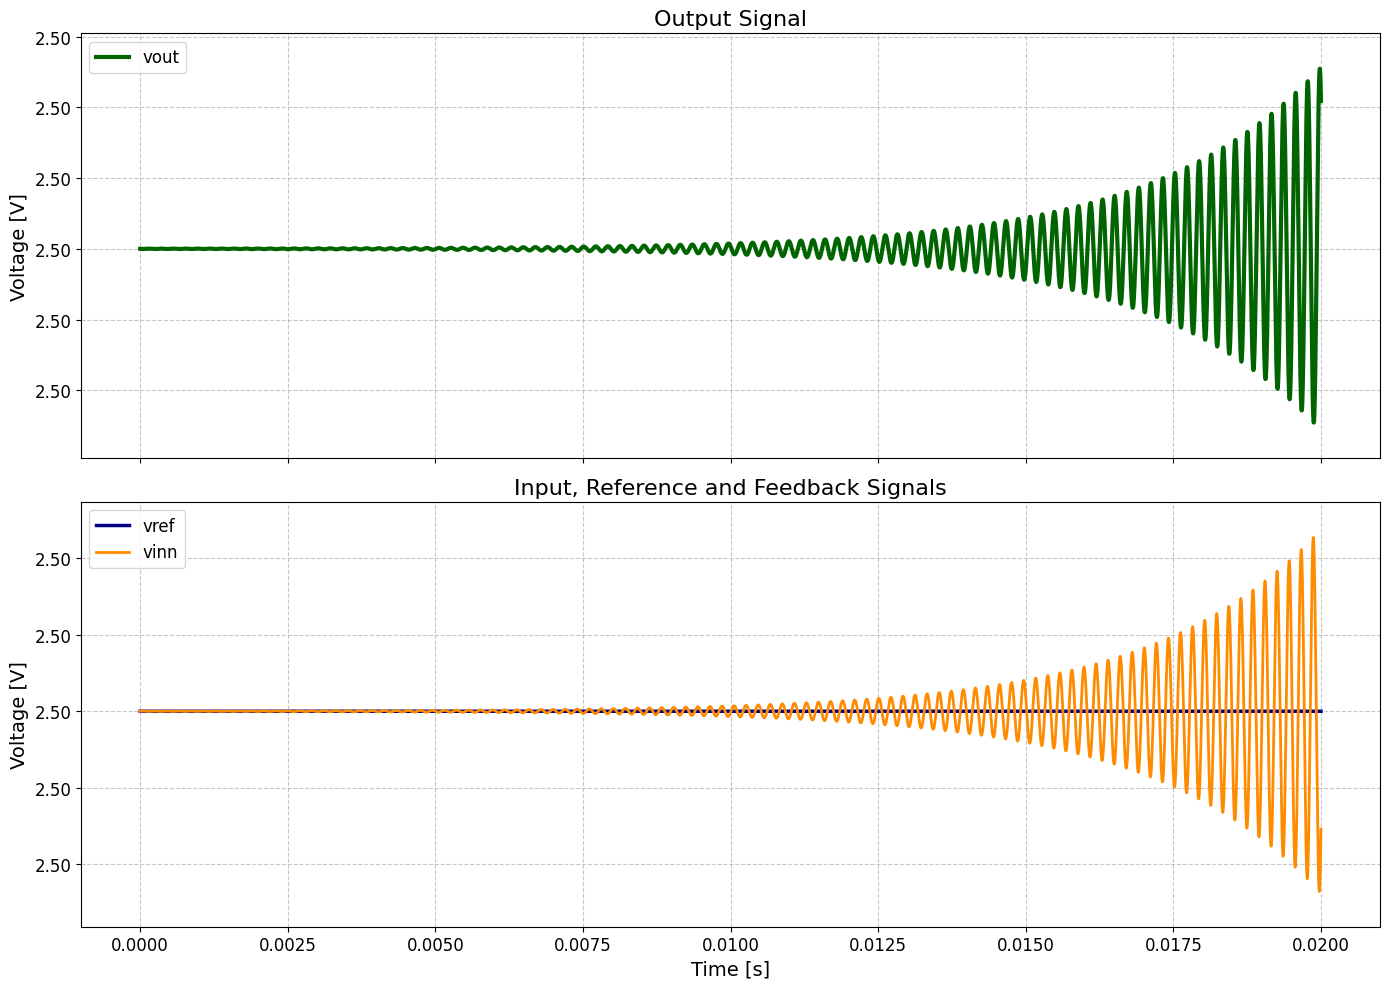

In [10]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('RC Phase Shift Oscillator')
# Power supplies
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)  # Virtual ground at Vdd/2
# Declare the opamp subcircuit
circuit.subcircuit(Opamp())
# Connect non-inverting input to Vref (2.5V)
# The inverting input will be connected to the RC network and feedback resistor
# Output node is 'Vout'
# RC phase shift network (three stages)
circuit.R('1', 'Vout', 'N1', 10@u_kΩ)
circuit.C('1', 'N1', 'Vref', 10@u_nF)
circuit.R('2', 'N1', 'N2', 10@u_kΩ)
circuit.C('2', 'N2', 'Vref', 10@u_nF)
circuit.R('3', 'N2', 'N3', 10@u_kΩ)
circuit.C('3', 'N3', 'Vref', 10@u_nF)
# Feedback resistor from output to inverting input (Vinn)
circuit.R('f', 'Vout', 'Vinn', 330@u_kΩ)
# The RC network output connects to the inverting input
circuit.R('in', 'N3', 'Vinn', 1@u_Ω)  # Virtually a wire (for node naming clarity)
# Create opamp instance
circuit.X('1', 'Opamp', 'Vref', 'Vinn', 'Vout')
simulator = circuit.simulator()
del_vname = []
for element in circuit.elements:
    v_name = element.name
    if element.name.lower().startswith("v") and "bias" not in element.name.lower() and "ref" not in element.name.lower():
        del_vname.append(v_name)

pin_name = "Vinp"
pin_name_n = "Vinn"
for element in circuit.elements:
    if element.name.lower().startswith("x"):
        opamp_element = element
        pin_name = str(opamp_element.pins[0].node)
        pin_name_n = str(opamp_element.pins[1].node)
        break

params = {pin_name: 2.51, pin_name_n: 2.5}

simulator = circuit.simulator()
simulator.initial_condition(**params)

try:
    analysis = simulator.transient(step_time=1@u_us, end_time=20@u_ms)
except:
    print("analysis failed.")
    sys.exit(2)

node = 'Vout'
# find any node with "vout"
has_node = False
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            node = str(pin.node)
            break
if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

import numpy as np
# Get the output node voltage
vout = np.array(analysis[node])

vlist = {}
for node_name in analysis.nodes.keys():
    vlist[node_name.lower()] = np.array(analysis[node_name])

time = np.array(analysis.time)

from scipy.signal import find_peaks, firwin, lfilter
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

key_output = node.lower()
axs[0].plot(time, vlist[key_output], color='darkgreen', linewidth=3, label=key_output)
axs[0].set_title('Output Signal', fontsize=16)
axs[0].set_ylabel('Voltage [V]', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend(fontsize=12, loc='best')

axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


feedback_node = None
ref_node = None
input_nodes = []

for node_name in vlist.keys():
    if 'feedback' in node_name or 'fb' in node_name:
        feedback_node = node_name
    elif 'ref' in node_name or 'vref' in node_name:
        ref_node = node_name
    elif node_name in [pin_name.lower(), pin_name_n.lower()]:
        input_nodes.append(node_name)
    elif ('in' in node_name or 'node' in node_name) and node_name != key_output:
        input_nodes.append(node_name)

if not input_nodes:
    for node_name in vlist.keys():
        if (node_name != key_output and 
            node_name != feedback_node and 
            node_name != ref_node and
            'vdd' not in node_name and 
            'vcc' not in node_name and
            'bias' not in node_name):
            input_nodes.append(node_name)
            if len(input_nodes) >= 3:
                break

if feedback_node:
    axs[1].plot(time, vlist[feedback_node], color='crimson', linewidth=2.5, label=feedback_node)
if ref_node:
    axs[1].plot(time, vlist[ref_node], color='navy', linewidth=2.5, label=ref_node)

colors = ['darkorange', 'purple', 'teal', 'olive', 'brown']
for i, node_name in enumerate(input_nodes):
    axs[1].plot(time, vlist[node_name], color=colors[i % len(colors)], linewidth=2, label=node_name)

axs[1].set_title('Input, Reference and Feedback Signals', fontsize=16)
axs[1].set_xlabel('Time [s]', fontsize=14)
axs[1].set_ylabel('Voltage [V]', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend(fontsize=12, loc='best')

axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

vout_min = np.min(vlist[key_output])
vout_max = np.max(vlist[key_output])
vout_range = vout_max - vout_min
axs[0].set_ylim([vout_min - 0.1 * vout_range, vout_max + 0.1 * vout_range])

all_values = []
if feedback_node:
    all_values.extend(vlist[feedback_node])
if ref_node:
    all_values.extend(vlist[ref_node])
for node_name in input_nodes:
    all_values.extend(vlist[node_name])

if all_values:
    y_min = np.min(all_values)
    y_max = np.max(all_values)
    y_range = y_max - y_min
    axs[1].set_ylim([y_min - 0.1 * y_range, y_max + 0.1 * y_range])

axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.tight_layout()
plt.savefig('p22_waveform.png', dpi=300)


def detect_oscillation_start(vout, time, threshold=0.001):
    dvout = np.abs(np.diff(vout))
    window_size = len(dvout) // 50
    window_size = max(window_size, 10)
    
    std_values = []
    for i in range(window_size, len(dvout)):
        window = dvout[i-window_size:i]
        std_values.append(np.std(window))
    
    std_values = np.array(std_values)
    threshold_value = threshold * np.max(std_values)
    start_indices = np.where(std_values > threshold_value)[0]
    
    if len(start_indices) > 0:
        oscillation_start_idx = start_indices[0] + window_size
        oscillation_start_idx = min(oscillation_start_idx, len(time)-1)
        return oscillation_start_idx
    else:
        return int(len(time) * 0.7)

def analyze_last_section(vout, time, fraction=0.3):
    start_idx = int(len(time) * (1 - fraction))
    return vout[start_idx:], time[start_idx:]

last_vout, last_time = analyze_last_section(vout, time, 0.3)

peaks, _ = find_peaks(last_vout)
troughs, _ = find_peaks(-last_vout)

error = 0

if len(peaks) > 2 and len(troughs) > 2:
    amplitudes = []
    
    for peak in peaks:
        nearest_trough_idx = np.argmin(np.abs(troughs - peak))
        nearest_trough = troughs[nearest_trough_idx]
        amplitude = np.abs(last_vout[peak] - last_vout[nearest_trough])
        amplitudes.append(amplitude)
    
    amplitudes = np.array(amplitudes)
    
    peak_times = last_time[peaks]
    periods = np.diff(peak_times)
    
    if len(periods) > 2:
        average_period = np.mean(periods)
        period_variation = np.std(periods) / average_period
        
        print(f"Detected {len(peaks)} peaks in the oscillation section")
        print(f"Average oscillation period: {average_period:.6f} s")
        print(f"Maximum amplitude: {np.max(amplitudes):.6f} V")
        
        if period_variation < 0.2:
            print("The oscillator works correctly and produces periodic oscillations")
        else:
            print("Periodicity is inconsistent, oscillation may not be ideal")
            error = 1
    else:
        print("Not enough peaks detected to determine periodicity")
        error = 1
else:
    print("Not enough peaks and troughs detected in the latter part to analyze oscillation")
    error = 1

if error == 1:
    sys.exit(2)
else:
    sys.exit(0)

Detected 10 peaks in the oscillation section
Average oscillation period: 0.000647 s
Maximum amplitude: 0.477377 V
The oscillator works correctly and produces periodic oscillations


SystemExit: 0

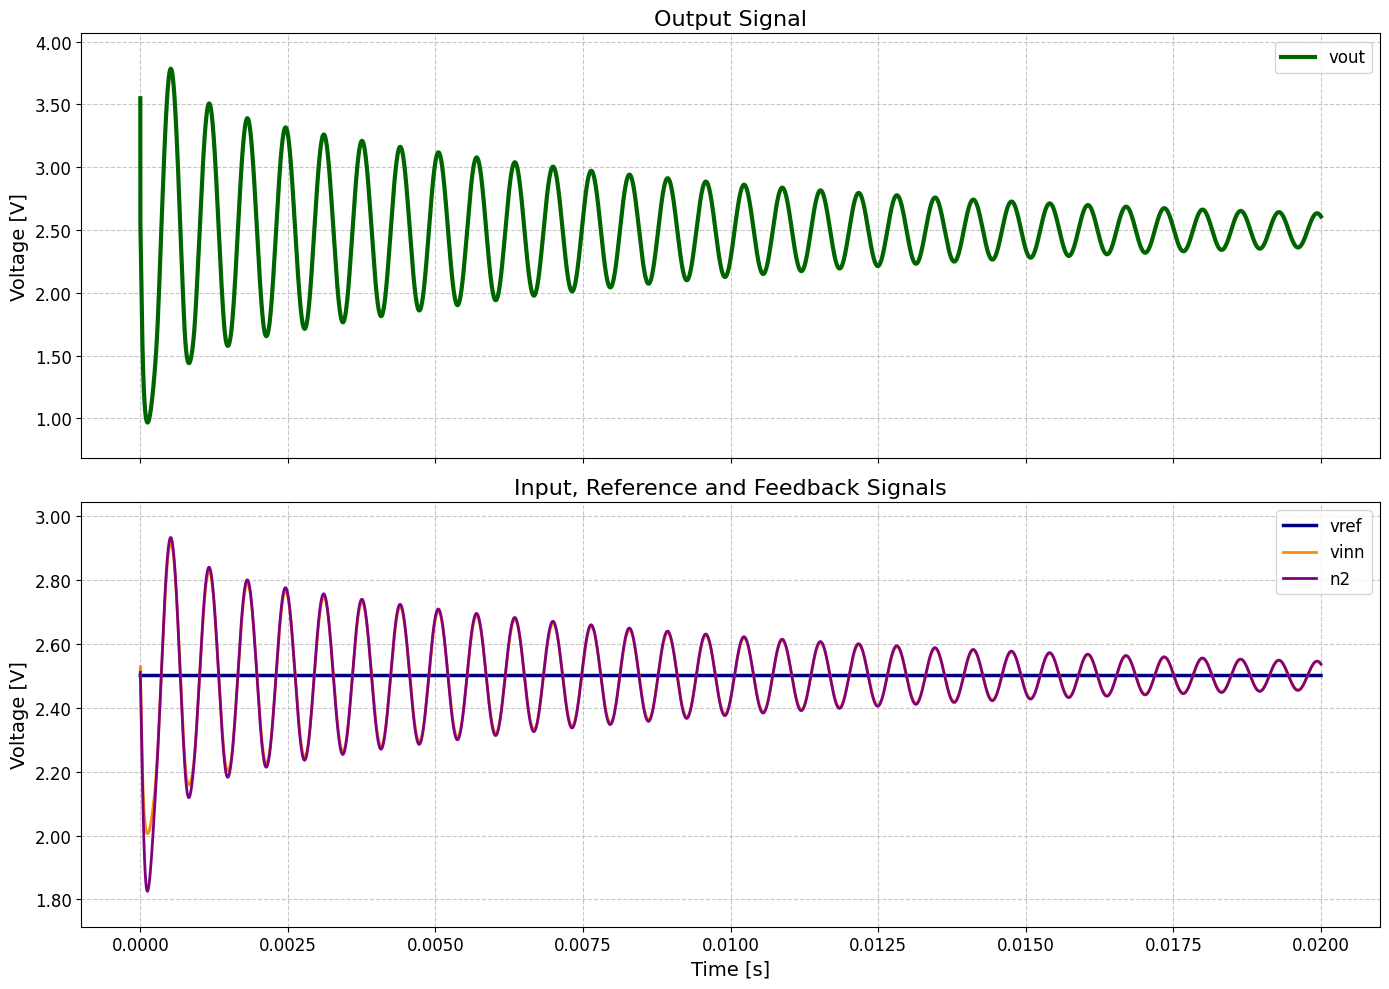

In [11]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Wien Bridge Oscillator')
# Power supply: 5V single supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Virtual ground/reference at 2.5V (Vref)
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# --- Wien Bridge RC Network ---
# Series RC: Vout -> N1 -> N2
circuit.R('1', 'Vout', 'N1', 10@u_kΩ)    # R1: Output to N1
circuit.C('1', 'N1', 'N2', 10@u_nF)      # C1: N1 to N2
# Parallel RC: N2 to Vref
circuit.R('2', 'N2', 'Vref', 10@u_kΩ)    # R2: N2 to Vref
circuit.C('2', 'N2', 'Vref', 10@u_nF)    # C2: N2 to Vref
# --- Feedback Network for Gain ---
# Feedback from output to inverting input, then to Vref
circuit.R('f1', 'Vout', 'Vinn', 21@u_kΩ)   # Feedback resistor (Rf1)
circuit.R('f2', 'Vinn', 'Vref', 10@u_kΩ)   # Gain resistor (Rf2)
# --- Opamp Subcircuit ---
circuit.subcircuit(Opamp())
# Opamp instance: non-inverting input = N2, inverting input = Vinn, output = Vout
circuit.X('1', 'Opamp', 'N2', 'Vinn', 'Vout')
# --- (Optional) Initial Condition to Start Oscillation ---
# Add a tiny voltage source to "kick" the oscillator (not strictly necessary in all simulators)
# circuit.V('kick', 'N2', 'Vref', 1@u_uV)  # 1 microvolt at non-inverting input
simulator = circuit.simulator()
del_vname = []
for element in circuit.elements:
    v_name = element.name
    if element.name.lower().startswith("v") and "bias" not in element.name.lower() and "ref" not in element.name.lower():
        del_vname.append(v_name)

pin_name = "Vinp"
pin_name_n = "Vinn"
for element in circuit.elements:
    if element.name.lower().startswith("x"):
        opamp_element = element
        pin_name = str(opamp_element.pins[0].node)
        pin_name_n = str(opamp_element.pins[1].node)
        break

params = {pin_name: 2.51, pin_name_n: 2.5}

simulator = circuit.simulator()
simulator.initial_condition(**params)

try:
    analysis = simulator.transient(step_time=1@u_us, end_time=20@u_ms)
except:
    print("analysis failed.")
    sys.exit(2)

node = 'Vout'
# find any node with "vout"
has_node = False
for element in circuit.elements:
    # get pins
    for pin in element.pins:
        if "vout" == str(pin.node).lower():
            has_node = True
            node = str(pin.node)
            break
if has_node == False:
    for element in circuit.elements:
        for pin in element.pins:
            if "vout" in str(pin.node).lower():
                node = str(pin.node)
                break

import numpy as np
# Get the output node voltage
vout = np.array(analysis[node])

vlist = {}
for node_name in analysis.nodes.keys():
    vlist[node_name.lower()] = np.array(analysis[node_name])

time = np.array(analysis.time)

from scipy.signal import find_peaks, firwin, lfilter
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

key_output = node.lower()
axs[0].plot(time, vlist[key_output], color='darkgreen', linewidth=3, label=key_output)
axs[0].set_title('Output Signal', fontsize=16)
axs[0].set_ylabel('Voltage [V]', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend(fontsize=12, loc='best')

axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


feedback_node = None
ref_node = None
input_nodes = []

for node_name in vlist.keys():
    if 'feedback' in node_name or 'fb' in node_name:
        feedback_node = node_name
    elif 'ref' in node_name or 'vref' in node_name:
        ref_node = node_name
    elif node_name in [pin_name.lower(), pin_name_n.lower()]:
        input_nodes.append(node_name)
    elif ('in' in node_name or 'node' in node_name) and node_name != key_output:
        input_nodes.append(node_name)

if not input_nodes:
    for node_name in vlist.keys():
        if (node_name != key_output and 
            node_name != feedback_node and 
            node_name != ref_node and
            'vdd' not in node_name and 
            'vcc' not in node_name and
            'bias' not in node_name):
            input_nodes.append(node_name)
            if len(input_nodes) >= 3:
                break

if feedback_node:
    axs[1].plot(time, vlist[feedback_node], color='crimson', linewidth=2.5, label=feedback_node)
if ref_node:
    axs[1].plot(time, vlist[ref_node], color='navy', linewidth=2.5, label=ref_node)

colors = ['darkorange', 'purple', 'teal', 'olive', 'brown']
for i, node_name in enumerate(input_nodes):
    axs[1].plot(time, vlist[node_name], color=colors[i % len(colors)], linewidth=2, label=node_name)

axs[1].set_title('Input, Reference and Feedback Signals', fontsize=16)
axs[1].set_xlabel('Time [s]', fontsize=14)
axs[1].set_ylabel('Voltage [V]', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend(fontsize=12, loc='best')

axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

vout_min = np.min(vlist[key_output])
vout_max = np.max(vlist[key_output])
vout_range = vout_max - vout_min
axs[0].set_ylim([vout_min - 0.1 * vout_range, vout_max + 0.1 * vout_range])

all_values = []
if feedback_node:
    all_values.extend(vlist[feedback_node])
if ref_node:
    all_values.extend(vlist[ref_node])
for node_name in input_nodes:
    all_values.extend(vlist[node_name])

if all_values:
    y_min = np.min(all_values)
    y_max = np.max(all_values)
    y_range = y_max - y_min
    axs[1].set_ylim([y_min - 0.1 * y_range, y_max + 0.1 * y_range])

axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.tight_layout()
plt.savefig('p23_waveform.png', dpi=300)


def detect_oscillation_start(vout, time, threshold=0.001):
    dvout = np.abs(np.diff(vout))
    window_size = len(dvout) // 50
    window_size = max(window_size, 10)
    
    std_values = []
    for i in range(window_size, len(dvout)):
        window = dvout[i-window_size:i]
        std_values.append(np.std(window))
    
    std_values = np.array(std_values)
    threshold_value = threshold * np.max(std_values)
    start_indices = np.where(std_values > threshold_value)[0]
    
    if len(start_indices) > 0:
        oscillation_start_idx = start_indices[0] + window_size
        oscillation_start_idx = min(oscillation_start_idx, len(time)-1)
        return oscillation_start_idx
    else:
        return int(len(time) * 0.7)

def analyze_last_section(vout, time, fraction=0.3):
    start_idx = int(len(time) * (1 - fraction))
    return vout[start_idx:], time[start_idx:]

last_vout, last_time = analyze_last_section(vout, time, 0.3)

peaks, _ = find_peaks(last_vout)
troughs, _ = find_peaks(-last_vout)

error = 0

if len(peaks) > 2 and len(troughs) > 2:
    amplitudes = []
    
    for peak in peaks:
        nearest_trough_idx = np.argmin(np.abs(troughs - peak))
        nearest_trough = troughs[nearest_trough_idx]
        amplitude = np.abs(last_vout[peak] - last_vout[nearest_trough])
        amplitudes.append(amplitude)
    
    amplitudes = np.array(amplitudes)
    
    peak_times = last_time[peaks]
    periods = np.diff(peak_times)
    
    if len(periods) > 2:
        average_period = np.mean(periods)
        period_variation = np.std(periods) / average_period
        
        print(f"Detected {len(peaks)} peaks in the oscillation section")
        print(f"Average oscillation period: {average_period:.6f} s")
        print(f"Maximum amplitude: {np.max(amplitudes):.6f} V")
        
        if period_variation < 0.2:
            print("The oscillator works correctly and produces periodic oscillations")
        else:
            print("Periodicity is inconsistent, oscillation may not be ideal")
            error = 1
    else:
        print("Not enough peaks detected to determine periodicity")
        error = 1
else:
    print("Not enough peaks and troughs detected in the latter part to analyze oscillation")
    error = 1

if error == 1:
    sys.exit(2)
else:
    sys.exit(0)

In [1]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Opamp Integrator')
# Define MOSFET models (for completeness in case the Opamp needs them)
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
circuit.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Reference voltage (virtual ground at Vdd/2)
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# Input DC bias voltage
circuit.V('in', 'Vin', circuit.gnd, 3@u_V)
# Declare the opamp subcircuit
circuit.subcircuit(Opamp())
# Opamp instance: non-inverting input at Vref, inverting input at node 'Vinn', output at 'Vout'
circuit.X('op', 'Opamp', 'Vref', 'Vinn', 'Vout')
# Input resistor R1 from Vin to Vinn (inverting input)
circuit.R('1', 'Vin', 'Vinn', 10@u_kΩ)
# Feedback capacitor Cf from Vout to Vinn
circuit.C('f', 'Vout', 'Vinn', 100@u_nF)
simulator = circuit.simulator()
vin_name = ""
for element in circuit.elements:
    if "vin" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vin_name = element.name

vin_name = ""
for element in circuit.elements:
    if "vin" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vin_name = element.name

bias_voltage = 2.5

if vin_name != "":
    circuit.element(vin_name).detach()
    circuit.V('pulse', 'Vin', circuit.gnd, f"dc {bias_voltage} PULSE({bias_voltage-0.5} {bias_voltage+0.5} 1u 1u 1u 10m 20m)")
else:
    circuit.V('in', 'Vin', circuit.gnd, f"dc {bias_voltage} PULSE({bias_voltage-0.5} {bias_voltage+0.5} 1u 1u 1u 10m 20m)")

r_name = None
for element in circuit.elements:
    if element.name.lower().startswith("r1") or element.name.lower().startswith("rr1"):
        r_name = element.name

if r_name is None:
    for element in circuit.elements:
        if element.name.lower().startswith("r"):
            r_name = element.name

if r_name is None:
    print("No resistor found in the netlist. Please check the netlist.")
    sys.exit(2)
circuit.element(r_name).resistance = "10k"

c_name = None
for element in circuit.elements:
    if element.name.lower().startswith("cf") or element.name.lower().startswith("ccf") or element.name.lower().startswith("c1"):
        c_name = element.name

if c_name is None:
    for element in circuit.elements:
        if element.name.lower().startswith("c"):
            c_name = element.name

if c_name is None:
    print("No capacitor found in the netlist. Please check the netlist.")
    sys.exit(2)
circuit.element(c_name).capacitance = "3u"

simulator = circuit.simulator()

try:
    analysis = simulator.transient(step_time=1@u_us, end_time=1000@u_ms, start_time=800@u_ms)
except:
    print("analysis failed.")
    sys.exit(2)

import numpy as np
vlist = {}
for node in analysis.nodes.values():
    vlist[node.name] = np.array(analysis[node.name])

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'lines.linewidth': 2.5
})

# Plot the step response
time = np.array(analysis.time)
vin = np.array(analysis['vin'])
vout = np.array(analysis['vout'])

plt.figure(figsize=(12, 8))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#7209B7', '#F72585', 
          '#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51', '#8E44AD', '#3498DB',
          '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#34495E', '#E67E22']

linestyles = ['-', '--', '-.', ':', '-', '--', '-.', '-', '--', '-.', ':', 
              '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

for i, node in enumerate(analysis.nodes.values()):
    plt.plot(time, vlist[node.name], 
             color=colors[i % len(colors)], 
             linestyle=linestyles[i % len(linestyles)],
             linewidth=2.5,
             label=node.name,
             alpha=0.9)

plt.title('Transient Response of Op-amp Integrator', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time [s]', fontsize=14, fontweight='semibold')
plt.ylabel('Voltage [V]', fontsize=14, fontweight='semibold')

plt.grid(True, linestyle='--', alpha=0.6, color='gray', linewidth=0.8)

plt.legend(frameon=True, fancybox=True, shadow=True, ncol=2, 
           loc='best', framealpha=0.9, edgecolor='black')

ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.2)
plt.tick_params(axis='both', which='minor', direction='out', length=4, width=1)

plt.tight_layout()
plt.savefig("p24_waveform.png", dpi=300, bbox_inches='tight', facecolor='white')

expected_slope = 0.5 / 0.03

from scipy.signal import find_peaks

peaks, _ = find_peaks(vout)
troughs, _ = find_peaks(-vout)

if len(peaks) < 2 or len(troughs) < 2:
    print("No peaks or troughs found in output voltage. Please check the netlist.")
    sys.exit(2)

start = peaks[-2]
end = troughs[troughs > start][0] 

slope, intercept = np.polyfit(time[start:end], vout[start:end], 1)
slope = np.abs(slope)
from scipy.stats import linregress
_, _, r_value, p_value, std_err = linregress(time[start:end], vout[start:end])

import sys
if not np.isclose(slope, expected_slope, rtol=0.3):
    print(f"The circuit does not function correctly as an integrator.\n"
          f"Expected slope: {expected_slope:.2f} V/s | Actual slope: {slope:.2f} V/s\n")
    sys.exit(2)

if not r_value** 2 >= 0.9:
    print("The op-amp integrator does not have a linear response.\n")
    sys.exit(2)

for element in circuit.elements:
    if element.name.lower().startswith("x"):
        x_name = element.name

circuit.element(x_name).detach()
simulator = circuit.simulator()
try:
    analysis = simulator.transient(step_time=1@u_us, end_time=200@u_ms)
except:
    print("The op-amp integrator functions correctly.\n")
    sys.exit(0)

time = np.array(analysis.time)
vin = np.array(analysis['vin'])
vout = np.array(analysis['vout'])

expected_slope = 0.5 / 0.03

from scipy.signal import find_peaks

peaks, _ = find_peaks(vout)
troughs, _ = find_peaks(-vout)

if len(peaks) < 2 or len(troughs) < 2:
    print("The op-amp integrator functions correctly.\n")
    sys.exit(0)

start = peaks[-2]
end = troughs[troughs > start][0] 

slope, intercept = np.polyfit(time[start:end], vout[start:end], 1)
slope = np.abs(slope)
from scipy.stats import linregress
_, _, r_value, p_value, std_err = linregress(time[start:end], vout[start:end])

if np.isclose(slope, expected_slope, rtol=0.5):
    print("The integrator maybe a passive integrator.\n")
    sys.exit(2)

print("The op-amp integrator functions correctly.\n")
sys.exit(0)

Unsupported Ngspice version 44
Note: vpulse: dc value used for op instead of transient time=0 value.


analysis failed.


SystemExit: 2

/home/irman/anaconda3/envs/chipster_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Note: Starting dynamic gmin stepping
Note: Starting true gmin stepping
Note: Starting source stepping
Note: Transient op started
Note: Transient op finished successfully


The op-amp integrator functions correctly.



SystemExit: 0

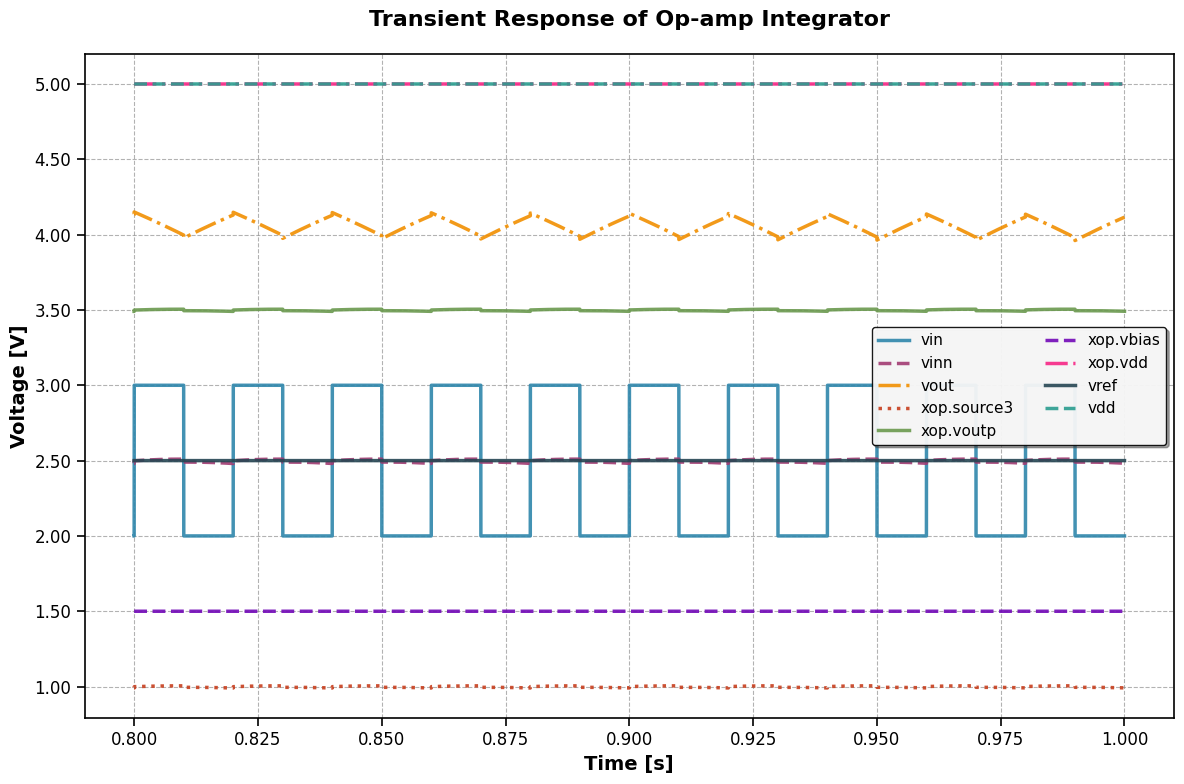

In [8]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Opamp Integrator')
# Define MOSFET models (for completeness in case the Opamp needs them)
circuit.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
circuit.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Reference voltage (virtual ground at Vdd/2)
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# Input DC bias voltage
circuit.V('in', 'Vin', circuit.gnd, 3@u_V)
# Declare the opamp subcircuit
circuit.subcircuit(Opamp())
# Opamp instance: non-inverting input at Vref, inverting input at node 'Vinn', output at 'Vout'
circuit.X('op', 'Opamp', 'Vref', 'Vinn', 'Vout')
# Input resistor R1 from Vin to Vinn (inverting input)
circuit.R('1', 'Vin', 'Vinn', 10@u_kΩ)
# Feedback capacitor Cf from Vout to Vinn
circuit.C('f', 'Vout', 'Vinn', 100@u_nF)
simulator = circuit.simulator()
vin_name = ""
for element in circuit.elements:
    if "vin" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vin_name = element.name

vin_name = ""
for element in circuit.elements:
    if "vin" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vin_name = element.name

bias_voltage = 2.5

if vin_name != "":
    circuit.element(vin_name).detach()
    circuit.V('pulse', 'Vin', circuit.gnd, f"PULSE({bias_voltage-0.5} {bias_voltage+0.5} 1u 1u 1u 10m 20m)")
else:
    circuit.V('in', 'Vin', circuit.gnd, f" PULSE({bias_voltage-0.5} {bias_voltage+0.5} 1u 1u 1u 10m 20m)")

r_name = None
for element in circuit.elements:
    if element.name.lower().startswith("r1") or element.name.lower().startswith("rr1"):
        r_name = element.name

if r_name is None:
    for element in circuit.elements:
        if element.name.lower().startswith("r"):
            r_name = element.name

if r_name is None:
    print("No resistor found in the netlist. Please check the netlist.")
    sys.exit(2)
circuit.element(r_name).resistance = "10k"

c_name = None
for element in circuit.elements:
    if element.name.lower().startswith("cf") or element.name.lower().startswith("ccf") or element.name.lower().startswith("c1"):
        c_name = element.name

if c_name is None:
    for element in circuit.elements:
        if element.name.lower().startswith("c"):
            c_name = element.name

if c_name is None:
    print("No capacitor found in the netlist. Please check the netlist.")
    sys.exit(2)
circuit.element(c_name).capacitance = "3u"

simulator = circuit.simulator()

try:
    analysis = simulator.transient(step_time=1@u_us, end_time=1000@u_ms, start_time=800@u_ms)
except:
    print("analysis failed.")
    sys.exit(2)

import numpy as np
vlist = {}
for node in analysis.nodes.values():
    vlist[node.name] = np.array(analysis[node.name])

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# 设置图形样式
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'lines.linewidth': 2.5
})

# Plot the step response
time = np.array(analysis.time)
vin = np.array(analysis['vin'])
vout = np.array(analysis['vout'])

plt.figure(figsize=(12, 8))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#7209B7', '#F72585', 
          '#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51', '#8E44AD', '#3498DB',
          '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#34495E', '#E67E22']

linestyles = ['-', '--', '-.', ':', '-', '--', '-.', '-', '--', '-.', ':', 
              '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

for i, node in enumerate(analysis.nodes.values()):
    plt.plot(time, vlist[node.name], 
             color=colors[i % len(colors)], 
             linestyle=linestyles[i % len(linestyles)],
             linewidth=2.5,
             label=node.name,
             alpha=0.9)

plt.title('Transient Response of Op-amp Integrator', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time [s]', fontsize=14, fontweight='semibold')
plt.ylabel('Voltage [V]', fontsize=14, fontweight='semibold')

plt.grid(True, linestyle='--', alpha=0.6, color='gray', linewidth=0.8)

plt.legend(frameon=True, fancybox=True, shadow=True, ncol=2, 
           loc='best', framealpha=0.9, edgecolor='black')

ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.2)
plt.tick_params(axis='both', which='minor', direction='out', length=4, width=1)

plt.tight_layout()
plt.savefig("p24_waveform.png", dpi=300, bbox_inches='tight', facecolor='white')

expected_slope = 0.5 / 0.03

from scipy.signal import find_peaks

peaks, _ = find_peaks(vout)
troughs, _ = find_peaks(-vout)

if len(peaks) < 2 or len(troughs) < 2:
    print("No peaks or troughs found in output voltage. Please check the netlist.")
    sys.exit(2)

start = peaks[-2]
end = troughs[troughs > start][0] 

slope, intercept = np.polyfit(time[start:end], vout[start:end], 1)
slope = np.abs(slope)
from scipy.stats import linregress
_, _, r_value, p_value, std_err = linregress(time[start:end], vout[start:end])

import sys
if not np.isclose(slope, expected_slope, rtol=0.3):
    print(f"The circuit does not function correctly as an integrator.\n"
          f"Expected slope: {expected_slope:.2f} V/s | Actual slope: {slope:.2f} V/s\n")
    sys.exit(2)

if not r_value** 2 >= 0.9:
    print("The op-amp integrator does not have a linear response.\n")
    sys.exit(2)

for element in circuit.elements:
    if element.name.lower().startswith("x"):
        x_name = element.name

circuit.element(x_name).detach()
simulator = circuit.simulator()
try:
    analysis = simulator.transient(step_time=1@u_us, end_time=200@u_ms)
except:
    print("The op-amp integrator functions correctly.\n")
    sys.exit(0)

time = np.array(analysis.time)
vin = np.array(analysis['vin'])
vout = np.array(analysis['vout'])

expected_slope = 0.5 / 0.03

from scipy.signal import find_peaks

peaks, _ = find_peaks(vout)
troughs, _ = find_peaks(-vout)

if len(peaks) < 2 or len(troughs) < 2:
    print("The op-amp integrator functions correctly.\n")
    sys.exit(0)

start = peaks[-2]
end = troughs[troughs > start][0] 

slope, intercept = np.polyfit(time[start:end], vout[start:end], 1)
slope = np.abs(slope)
from scipy.stats import linregress
_, _, r_value, p_value, std_err = linregress(time[start:end], vout[start:end])

if np.isclose(slope, expected_slope, rtol=0.5):
    print("The integrator maybe a passive integrator.\n")
    sys.exit(2)

print("The op-amp integrator functions correctly.\n")
sys.exit(0)

The op-amp differentiator functions correctly.



SystemExit: 0

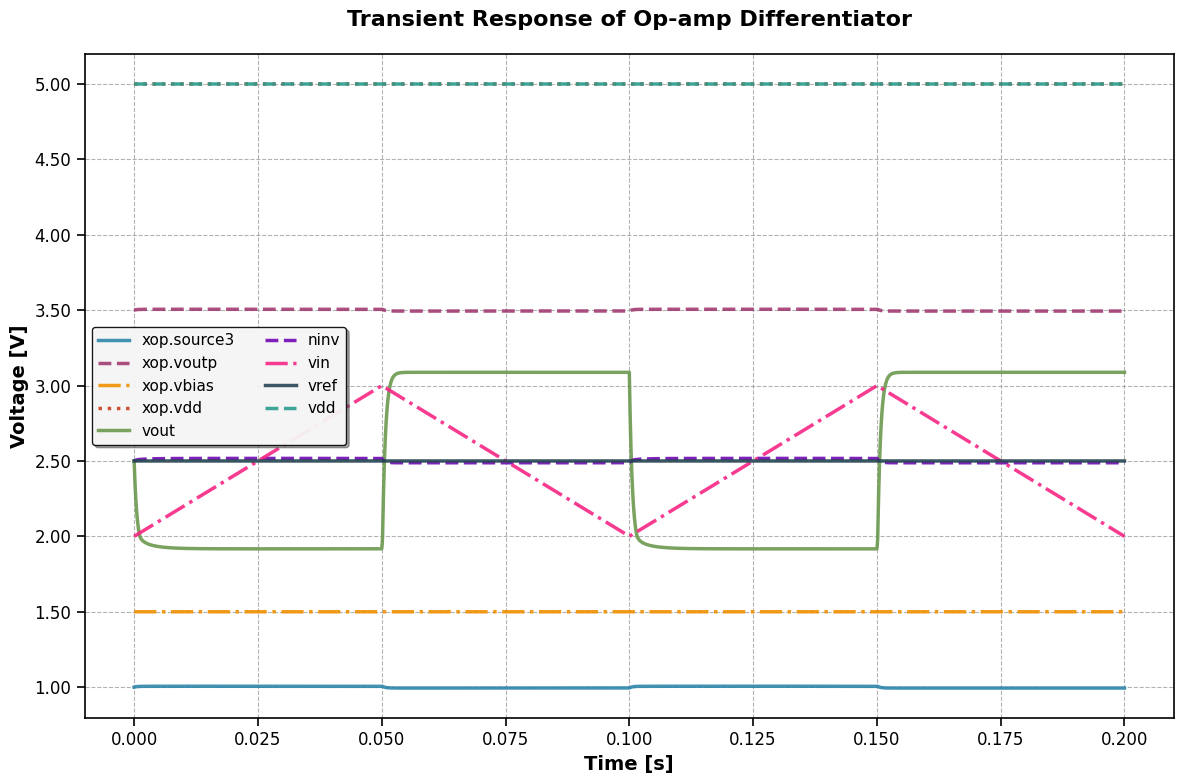

In [11]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Opamp Differentiator')
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Reference voltage for virtual ground
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# Input voltage (set to DC for operating point)
circuit.V('in', 'Vin', circuit.gnd, 3@u_V)
# Opamp subcircuit
circuit.subcircuit(Opamp())
# Differentiator components
circuit.C('1', 'Vin', 'Ninv', 10@u_nF)      # C1: input capacitor
circuit.R('f', 'Vout', 'Ninv', 10@u_kΩ)     # Rf: feedback resistor
circuit.R('b', 'Ninv', 'Vref', 1@u_MΩ)      # Rb: bias resistor for DC stability
# Opamp connections
circuit.X('op', 'Opamp', 'Vref', 'Ninv', 'Vout')
simulator = circuit.simulator()
vin_name = ""
for element in circuit.elements:
    if "vin" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vin_name = element.name

vin_name = ""
for element in circuit.elements:
    if "vin" in [str(pin.node).lower() for pin in element.pins] and element.name.lower().startswith("v"):
        vin_name = element.name

bias_voltage = 2.5

# Detach the previous Vin if it exists and attach a new triangular wave source
if vin_name != "":
    circuit.element(vin_name).detach()
    circuit.V('tri', 'Vin', circuit.gnd, f"PULSE({bias_voltage-0.5} {bias_voltage+0.5} 0 50m 50m 1n 100m)")
else:
    circuit.V('in', 'Vin', circuit.gnd, f"PULSE({bias_voltage-0.5} {bias_voltage+0.5} 0 50m 50m 1n 100m)")

# Adjust R1 resistance if needed
for element in circuit.elements:
    if element.name.lower().startswith("rf") or element.name.lower().startswith("rrf") or element.name.lower().startswith("r1"):
        r_name = element.name
circuit.element(r_name).resistance = "10k"

# Adjust C1 capacitance if needed
for element in circuit.elements:
    if element.name.lower().startswith("c1") or element.name.lower().startswith("cc1"):
        c_name = element.name
circuit.element(c_name).capacitance = "3u"

# Initialize the simulator
simulator = circuit.simulator()

import sys
# Perform transient analysis
try:
    analysis = simulator.transient(step_time=1@u_us, end_time=200@u_ms)
except:
    print("analysis failed.")
    sys.exit(2)

import numpy as np
vlist = {}
for node in analysis.nodes.values():
    vlist[node.name] = np.array(analysis[node.name])

import numpy as np
# Extract data from the analysis
time = np.array(analysis.time)
vin = np.array(analysis['vin'])
vout = np.array(analysis['vout'])

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'lines.linewidth': 2.5
})

# Plot the response
plt.figure(figsize=(12, 8))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#7209B7', '#F72585', 
          '#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51', '#8E44AD', '#3498DB',
          '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#34495E', '#E67E22']

linestyles = ['-', '--', '-.', ':', '-', '--', '-.', '-', '--', '-.', ':', 
              '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

for i, node in enumerate(analysis.nodes.values()):
    plt.plot(time, vlist[node.name], 
             color=colors[i % len(colors)], 
             linestyle=linestyles[i % len(linestyles)],
             linewidth=2.5,
             label=node.name,
             alpha=0.9)


plt.title('Transient Response of Op-amp Differentiator', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time [s]', fontsize=14, fontweight='semibold')
plt.ylabel('Voltage [V]', fontsize=14, fontweight='semibold')

plt.grid(True, linestyle='--', alpha=0.6, color='gray', linewidth=0.8)

plt.legend(frameon=True, fancybox=True, shadow=True, ncol=2, 
           loc='best', framealpha=0.9, edgecolor='black')

ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.2)
plt.tick_params(axis='both', which='minor', direction='out', length=4, width=1)

plt.tight_layout()
plt.savefig("p25_waveform.png", dpi=300, bbox_inches='tight', facecolor='white')

from scipy.signal import find_peaks
# Check for square wave characteristics in the output
# Calculate the mean voltage level of the peaks and troughs

min_height = (max(vout) + min(vout)) / 2
num_of_peaks = 2
min_distance = len(vout) / (2 * num_of_peaks) / 1.5 

peaks, _ = find_peaks(vout, height=min_height, distance=min_distance)
troughs, _ = find_peaks(-vout, height=-min_height, distance=min_distance)

average_peak_voltage = np.mean(vout[peaks])
average_trough_voltage = np.mean(vout[troughs])

if len(peaks) == 0 or len(troughs) == 0:
    print("No peaks or troughs found in output voltage. Please check the netlist.")
    sys.exit(2)

peak_voltages = vout[peaks]
trough_voltages = vout[troughs]
mean_peak = np.mean(peak_voltages)
mean_trough = np.mean(trough_voltages)

def is_square_wave(waveform, mean_peak, mean_trough, rtol=0.1):
    high_level = np.mean([x for x in waveform if x > (mean_peak + mean_trough) / 2])
    low_level = np.mean([x for x in waveform if x <= (mean_peak + mean_trough) / 2])
    is_high_close = np.isclose(high_level, mean_peak, rtol=rtol)
    is_low_close = np.isclose(low_level, mean_trough, rtol=rtol)
    return is_high_close and is_low_close

# Check if the output is approximately a square wave by comparing the mean of the peaks and troughs
if np.isclose(mean_peak - bias_voltage, -mean_trough+ bias_voltage, rtol=0.2) and \
     np.isclose(mean_peak - bias_voltage, 0.6, rtol=0.2) and \
     is_square_wave(vout, mean_peak, mean_trough):  # 20% tolerance
    pass
elif not np.isclose(mean_peak - bias_voltage, -mean_trough+ bias_voltage, rtol=0.2):
    print(f"The circuit does not function correctly as a differentiator.\n"
          f"When the input is a triangle wave and the output is not a square wave.\n")
    sys.exit(2)
elif not is_square_wave(vout, mean_peak, mean_trough):
    print(f"The circuit does not function correctly as a differentiator.\n"
          f"When the input is a triangle wave and the output is not a square wave.\n")
    sys.exit(2)
else:
    print(f"The circuit does not function correctly as a differentiator.\n"
          f"Output voltage peak value is wrong. Mean peak voltage: {mean_peak} V | Mean trough voltage: {mean_trough} V\n")
    sys.exit(2)

for element in circuit.elements:
    if element.name.lower().startswith("x"):
        x_name = element.name

# Detach the subcircuit
circuit.element(x_name).detach()
simulator = circuit.simulator()
try:
    analysis = simulator.transient(step_time=1@u_us, end_time=200@u_ms)
except:
    print("The op-amp differentiator functions correctly.\n")
    sys.exit(0)

time = np.array(analysis.time)
vin = np.array(analysis['vin'])
vout = np.array(analysis['vout'])

min_height = (max(vout) + min(vout)) / 2
num_of_peaks = 2
min_distance = len(vout) / (2 * num_of_peaks) / 1.5 

peaks, _ = find_peaks(vout, height=min_height, distance=min_distance)
troughs, _ = find_peaks(-vout, height=-min_height, distance=min_distance)

average_peak_voltage = np.mean(vout[peaks])
average_trough_voltage = np.mean(vout[troughs])

if len(peaks) == 0 or len(troughs) == 0:
    print(f"The op-amp differentiator functions correctly.\n")
    sys.exit(0)

peak_voltages = vout[peaks]
trough_voltages = vout[troughs]
mean_peak = np.mean(peak_voltages)
mean_trough = np.mean(trough_voltages)

if np.isclose(mean_peak - bias_voltage, -mean_trough+ bias_voltage, rtol=0.2) and np.isclose(mean_peak - bias_voltage, 0.6, rtol=0.2):  # 20% tolerance
    print("The differentiator maybe a passive differentiator.\n")
    sys.exit(2)
elif not np.isclose(mean_peak - bias_voltage, -mean_trough+ bias_voltage, rtol=0.2):
    print(f"The op-amp differentiator functions correctly.\n")
    sys.exit(0)
else:
    print(f"The op-amp differentiator functions correctly.\n")
    sys.exit(0)

In [13]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Opamp Inverting Adder')
# Power supply: 5V single supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Virtual ground/reference at 2.5V for opamp biasing
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# Input voltages (example DC values, you can set as needed)
circuit.V('in1', 'Vin1', circuit.gnd, 3@u_V)
circuit.V('in2', 'Vin2', circuit.gnd, 3@u_V)
# All resistors equal for unity gain from each input ---
R_value = 10@u_kΩ
# Both inputs connect through resistors to summing node 'Vsum' (inverting input) ---
circuit.R('1', 'Vin1', 'Vsum', R_value)  # Vin1 to Vsum
circuit.R('2', 'Vin2', 'Vsum', R_value)  # Vin2 to Vsum
# Feedback resistor from output to Vsum ---
circuit.R('f', 'Vout', 'Vsum', R_value)  # Vout to Vsum
# Non-inverting input of opamp connected to Vref (2.5V) ---
circuit.subcircuit(Opamp())
circuit.X('op', 'Opamp', 'Vref', 'Vsum', 'Vout')
# The circuit now forms a classic inverting adder:
# Vout = 2.5V - [(Vin1 - 2.5V) + (Vin2 - 2.5V)]
#      = -Vin1 - Vin2 + 5V
simulator = circuit.simulator()

bias_voltage = 2.5  # Set bias voltage to 2.5V
v1_amp = 3.0  # Original value from circuit
v2_amp = 3.0  # Original value from circuit
tolerance = 0.2  # 20% tolerance

# Testing approach: We'll run multiple tests to determine if the circuit functions as an adder

# Test 1: Get baseline with original values
simulator = circuit.simulator()
try:
    analysis_baseline = simulator.operating_point()
except Exception as e:
    print(f"DC analysis failed: {str(e)}")
    sys.exit(2)

baseline_output = float(analysis_baseline.Vout)
print(f"Baseline output: {baseline_output:.4f} V with Vin1 = {v1_amp:.4f} V, Vin2 = {v2_amp:.4f} V")

# Test 2: Change Vin1 and check effect
# First, find the Vin1 source to modify
vin1_found = False
for element in circuit.elements:
    if element.name.lower() == 'vin1' or (element.name.lower().startswith('v') and 'vin1' in [str(pin.node).lower() for pin in element.pins]):
        circuit.element(element.name).dc_value = v1_amp + 0.5
        vin1_found = True
        break

if not vin1_found:
    print("Could not find Vin1 source to modify")
    sys.exit(2)

# Run analysis with modified Vin1
simulator = circuit.simulator()
try:
    analysis_vin1_mod = simulator.operating_point()
except Exception as e:
    print(f"DC analysis failed with modified Vin1: {str(e)}")
    sys.exit(2)

vin1_mod_output = float(analysis_vin1_mod.Vout)
vin1_effect = vin1_mod_output - baseline_output
print(f"Effect of increasing Vin1 by 0.5V: {vin1_effect:.4f} V change in output")

# Reset Vin1 to original value
for element in circuit.elements:
    if element.name.lower() == 'vin1' or (element.name.lower().startswith('v') and 'vin1' in [str(pin.node).lower() for pin in element.pins]):
        circuit.element(element.name).dc_value = v1_amp
        break

# Test 3: Change Vin2 and check effect
vin2_found = False
for element in circuit.elements:
    if element.name.lower() == 'vin2' or (element.name.lower().startswith('v') and 'vin2' in [str(pin.node).lower() for pin in element.pins]):
        circuit.element(element.name).dc_value = v2_amp + 0.5
        vin2_found = True
        break

if not vin2_found:
    print("Could not find Vin2 source to modify")
    sys.exit(2)

# Run analysis with modified Vin2
simulator = circuit.simulator()
try:
    analysis_vin2_mod = simulator.operating_point()
except Exception as e:
    print(f"DC analysis failed with modified Vin2: {str(e)}")
    sys.exit(2)

vin2_mod_output = float(analysis_vin2_mod.Vout)
vin2_effect = vin2_mod_output - baseline_output
print(f"Effect of increasing Vin2 by 0.5V: {vin2_effect:.4f} V change in output")

# Verify adder properties
import sys
import numpy as np

# Check if inputs affect the output significantly
if abs(vin1_effect) < 0.05:
    print(f"The circuit is not an adder: Vin1 has minimal effect on output ({vin1_effect:.4f} V change)")
    sys.exit(2)

if abs(vin2_effect) < 0.05:
    print(f"The circuit is not an adder: Vin2 has minimal effect on output ({vin2_effect:.4f} V change)")
    sys.exit(2)

# For a proper inverting adder, increasing input should decrease output
if vin1_effect >= 0:
    print(f"The circuit is not an inverting adder: Increasing Vin1 does not decrease output (effect: {vin1_effect:.4f} V)")
    sys.exit(2)

if vin2_effect >= 0:
    print(f"The circuit is not an inverting adder: Increasing Vin2 does not decrease output (effect: {vin2_effect:.4f} V)")
    sys.exit(2)

# Check if inputs have similar effects (should be approximately equal for equal resistors)
effect_ratio = abs(vin1_effect / vin2_effect)
if not (1-tolerance <= effect_ratio <= 1+tolerance):
    print(f"The circuit has unbalanced input scaling: Vin1 effect = {vin1_effect:.4f} V, Vin2 effect = {vin2_effect:.4f} V")
    sys.exit(2)

# Collect additional test points to verify the adder behavior
test_points = [
    (2.5, 2.5),   # Both at reference
    (3.0, 2.5),   # Only Vin1 above reference
    (2.5, 3.0),   # Only Vin2 above reference
    (3.0, 3.0),   # Both above reference (baseline)
]

results = []
for v1, v2 in test_points:
    # Set Vin1
    for element in circuit.elements:
        if element.name.lower() == 'vin1' or (element.name.lower().startswith('v') and 'vin1' in [str(pin.node).lower() for pin in element.pins]):
            circuit.element(element.name).dc_value = v1
            break
    
    # Set Vin2
    for element in circuit.elements:
        if element.name.lower() == 'vin2' or (element.name.lower().startswith('v') and 'vin2' in [str(pin.node).lower() for pin in element.pins]):
            circuit.element(element.name).dc_value = v2
            break
    
    # Run analysis
    simulator = circuit.simulator()
    try:
        analysis = simulator.operating_point()
        vout = float(analysis.Vout)
        results.append((v1, v2, vout))
    except Exception as e:
        print(f"Analysis failed for Vin1 = {v1:.4f} V, Vin2 = {v2:.4f} V: {str(e)}")

# Calculate the adder's gain factor from data
input_diffs = []
output_diffs = []

for i in range(1, len(results)):
    v1, v2, vout = results[i]
    v1_ref, v2_ref, vout_ref = results[0]  # Reference point (both at 2.5V)
    
    input_diff = (v1 - bias_voltage) + (v2 - bias_voltage)
    output_diff = vout_ref - vout  # For inverting adder, output decreases as input increases
    
    if abs(input_diff) > 0.01:  # Avoid division by near-zero
        input_diffs.append(input_diff)
        output_diffs.append(output_diff)

# Calculate average gain factor
if input_diffs:
    gain_factors = [o/i for i, o in zip(input_diffs, output_diffs)]
    avg_gain = sum(gain_factors) / len(gain_factors)
else:
    avg_gain = 0.5  # Default fallback if we couldn't calculate

# Verify if output follows the adder formula with the determined gain
all_valid = True
for v1, v2, actual_vout in results:
    # Expected output based on inverting adder formula with measured gain
    expected_vout = bias_voltage - avg_gain * ((v1 - bias_voltage) + (v2 - bias_voltage))
    
    # Check if within tolerance
    if not np.isclose(actual_vout, expected_vout, rtol=tolerance):
        all_valid = False
        print(f"Output doesn't match formula at Vin1={v1:.2f}V, Vin2={v2:.2f}V:")
        print(f"  Expected: {expected_vout:.4f}V, Actual: {actual_vout:.4f}V")

if not all_valid:
    print("The circuit does not consistently follow the adder formula within 20% tolerance")
    sys.exit(2)

print("\nThe op-amp adder functions correctly!")
print(f"- Both inputs (Vin1 and Vin2) affect the output")
print(f"- Both have a negative (inverting) effect on the output")
print(f"- The input scaling is balanced (Vin1 effect ≈ Vin2 effect)")
print(f"- The output follows an inverting adder formula: Vout ≈ Vref - {avg_gain:.2f}*((Vin1-Vref) + (Vin2-Vref))")
print(f"- All test points are within {tolerance*100}% tolerance of the expected values")
sys.exit(0)

Baseline output: 1.7268 V with Vin1 = 3.0000 V, Vin2 = 3.0000 V
Effect of increasing Vin1 by 0.5V: -0.1462 V change in output
Effect of increasing Vin2 by 0.5V: -0.1462 V change in output

The op-amp adder functions correctly!
- Both inputs (Vin1 and Vin2) affect the output
- Both have a negative (inverting) effect on the output
- The input scaling is balanced (Vin1 effect ≈ Vin2 effect)
- The output follows an inverting adder formula: Vout ≈ Vref - 0.89*((Vin1-Vref) + (Vin2-Vref))
- All test points are within 20.0% tolerance of the expected values


/tmp/ipykernel_627525/3753172661.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  baseline_output = float(analysis_baseline.Vout)
/tmp/ipykernel_627525/3753172661.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vin1_mod_output = float(analysis_vin1_mod.Vout)
/tmp/ipykernel_627525/3753172661.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vin2_mod_output = float(analysis_vin2_mod.Vout)
/tmp/ipykernel_627525/3753172661.py:176: DeprecationWarning: Conve

SystemExit: 0

In [14]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Opamp Subtractor (Differential Amplifier)')
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Virtual ground at Vdd/2 for AC reference
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# DC bias voltages for inputs (example values, can be swept in simulation)
circuit.V('in1', 'Vin1', 'Vref', 3@u_V)
circuit.V('in2', 'Vin2', 'Vref', 4@u_V)
# Declare the opamp subcircuit
circuit.subcircuit(Opamp())
# Differential amplifier resistors (all 10kΩ)
circuit.R('1', 'Vin1', 'Vinn', 10@u_kΩ)     # R1
circuit.R('2', 'Vout', 'Vinn', 10@u_kΩ)     # R2 (feedback)
circuit.R('3', 'Vin2', 'Vinp', 10@u_kΩ)     # R3
circuit.R('4', 'Vref', 'Vinp', 10@u_kΩ)     # R4
# Opamp instance
circuit.X('op', 'Opamp', 'Vinp', 'Vinn', 'Vout')
simulator = circuit.simulator()
import numpy as np
# Define test parameters
BIAS_VOLTAGE = 2.5
TOLERANCE = 0.2  # Stricter 5% tolerance

# Create simulator
simulator = circuit.simulator()

# Test across a wider range of input voltages
vin1_values = np.linspace(2.5, 3.5, 5)  # Test from 1V to 4V
vin2_values = np.linspace(2.5, 3.5, 5)

print("Testing subtractor circuit with multiple input combinations...")
print("Using tolerance: {:.1f}%".format(TOLERANCE * 100))
print("-" * 60)
print("| Vin1 (V) | Vin2 (V) | Expected (V) | Actual (V) | Result |")
print("-" * 60)

all_tests_passed = True


for element in circuit.elements:
    for pin in element.pins:
        if "vin1" in str(pin.node).lower() and element.name.lower().startswith("v"):
            vin1_name = element.name
            break

for element in circuit.elements:
    for pin in element.pins:
        if "vin2" in str(pin.node).lower() and element.name.lower().startswith("v"):
            vin2_name = element.name
            break

circuit.element(vin1_name).detach()
circuit.element(vin2_name).detach()

circuit.V('in1', 'Vin1', circuit.gnd, '2.5')
circuit.V('in2', 'Vin2', circuit.gnd, '2.5')
        
import sys
# Test with multiple combinations of inputs
for vin1 in vin1_values:
    for vin2 in vin2_values:
        # Update input voltage sources
        circuit.element("Vin1").dc_value = vin1
        circuit.element("Vin2").dc_value = vin2

        
        # Run DC analysis
        try:
            analysis = simulator.operating_point()
        except Exception as e:
            print(f"Simulation failed: {e}")
            sys.exit(2)
        
        # Get actual output voltage
        actual_vout = float(analysis.Vout)
        
        # Calculate expected output for a proper subtractor: Vout = V2 - V1
        expected_vout = vin2 - vin1 + 2.5
        
        # Verify if the output voltage meets expectations
        if np.isclose(actual_vout, expected_vout, rtol=TOLERANCE):
            test_result = "PASS"
        else:
            test_result = "FAIL"
            all_tests_passed = False
        
        print(f"| {vin1:7.2f} | {vin2:7.2f} | {expected_vout:11.2f} | {actual_vout:10.2f} | {test_result:6} |")

print("-" * 60)


# Output final test result
if all_tests_passed:
    print("\nALL TESTS PASSED: The op-amp subtractor functions correctly.")
    sys.exit(0)
else:
    print("\nTESTS FAILED: The subtractor circuit is not functioning correctly.")
    print("Check the circuit configuration and component values.")
    sys.exit(2)

Testing subtractor circuit with multiple input combinations...
Using tolerance: 20.0%
------------------------------------------------------------
| Vin1 (V) | Vin2 (V) | Expected (V) | Actual (V) | Result |
------------------------------------------------------------
|    2.50 |    2.50 |        2.50 |       2.50 | PASS   |
|    2.50 |    2.75 |        2.75 |       2.75 | PASS   |
|    2.50 |    3.00 |        3.00 |       2.99 | PASS   |
|    2.50 |    3.25 |        3.25 |       3.24 | PASS   |
|    2.50 |    3.50 |        3.50 |       3.48 | PASS   |
|    2.75 |    2.50 |        2.25 |       2.26 | PASS   |
|    2.75 |    2.75 |        2.50 |       2.50 | PASS   |
|    2.75 |    3.00 |        2.75 |       2.75 | PASS   |
|    2.75 |    3.25 |        3.00 |       3.00 | PASS   |
|    2.75 |    3.50 |        3.25 |       3.24 | PASS   |
|    3.00 |    2.50 |        2.00 |       2.02 | PASS   |
|    3.00 |    2.75 |        2.25 |       2.26 | PASS   |
|    3.00 |    3.00 |        2.50 |

/tmp/ipykernel_627525/3138799944.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_vout = float(analysis.Vout)


SystemExit: 0

Unsupported Ngspice version 44



Starting trigger point analysis...
Rising edge trigger point: 2.54936V
Falling edge trigger point: 2.35401V
Hysteresis width: 0.19535V
The circuit functions correctly with different trigger points.
Simulation and analysis completed successfully!


SystemExit: 0

/home/irman/anaconda3/envs/chipster_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


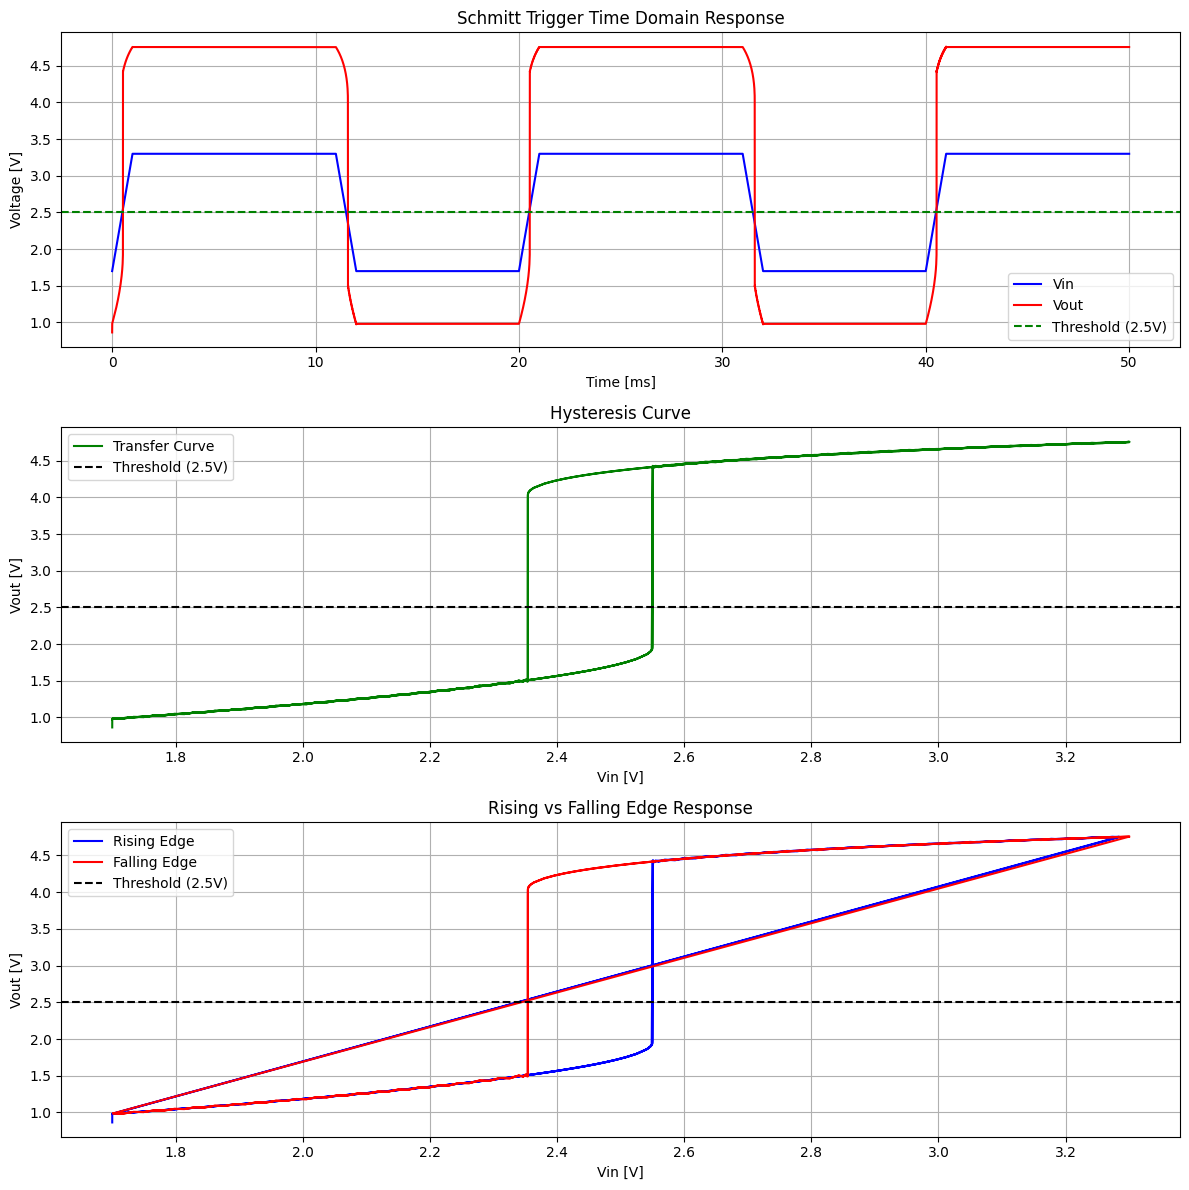

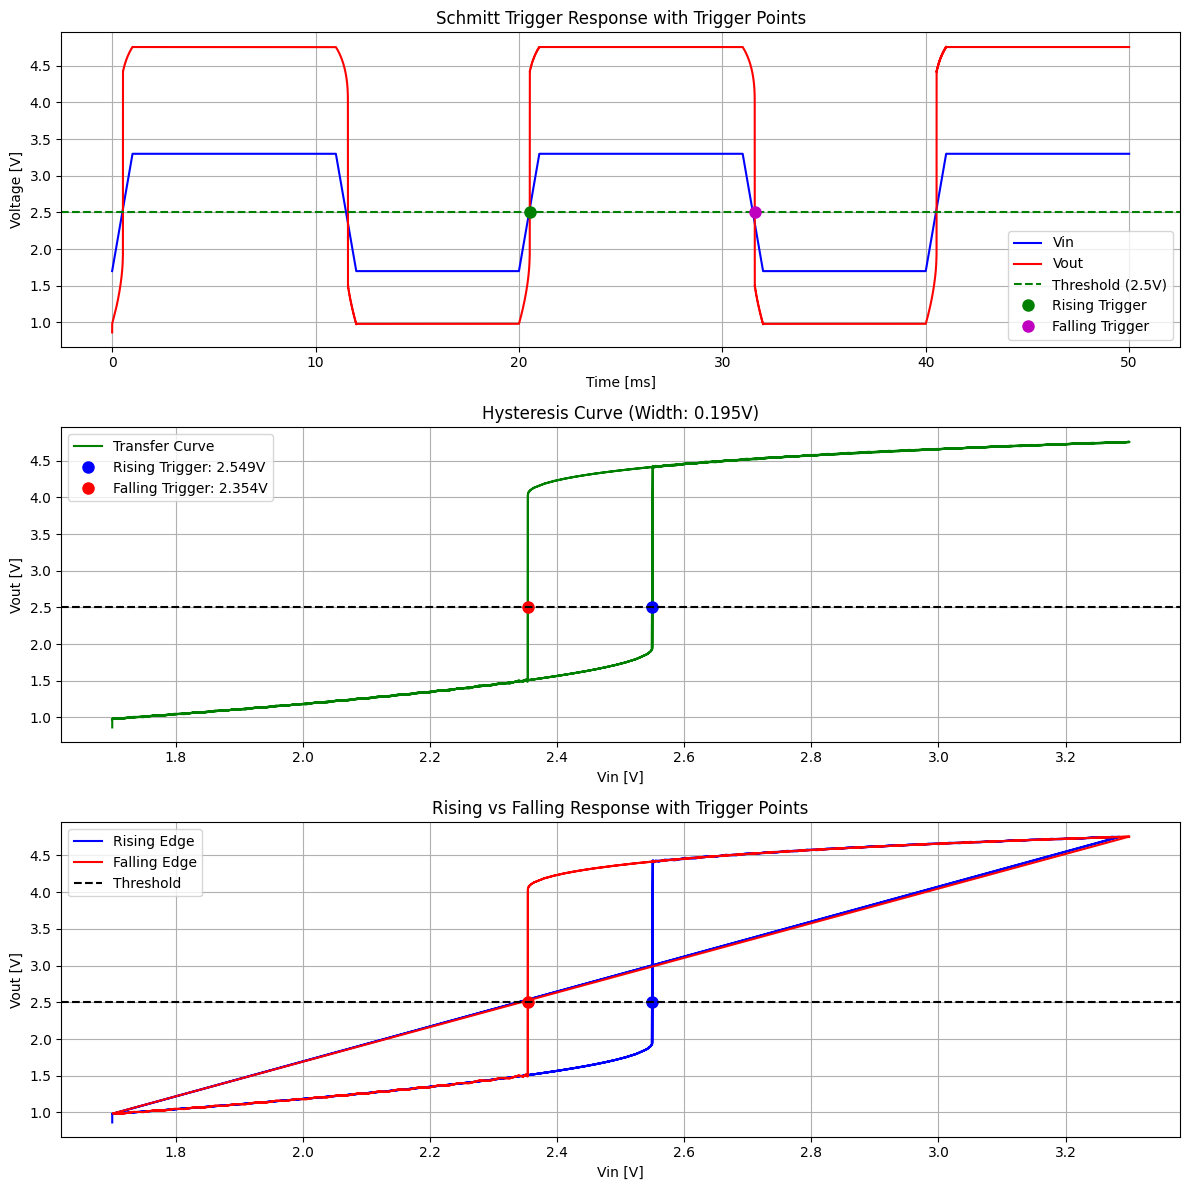

In [1]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

class Opamp(SubCircuitFactory):
	NAME = ('Opamp')
	NODES = ('Vinp', 'Vinn', 'Vout')
	def __init__(self):
		super().__init__()
		# Define the MOSFET models
		self.model('nmos_model', 'nmos', level=1, kp=100e-6, vto=0.5)
		self.model('pmos_model', 'pmos', level=1, kp=50e-6, vto=-0.5)
		# Power Supplies
		self.V('dd', 'Vdd', self.gnd, 5.0)  # 5V power supply
		self.V('bias', 'Vbias', self.gnd, 1.5)  # Bias voltage for the tail current source M3
		# Input Voltage Sources for Differential Inputs
		# Differential Pair and Tail Current Source
		self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=50e-6, l=1e-6)
		self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=100e-6, l=1e-6)
		# Active Current Mirror Load
		self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)
		self.MOSFET('5', 'Vout', 'Voutp', 'Vdd', 'Vdd', model='pmos_model', w=100e-6, l=1e-6)

circuit = Circuit('Non-inverting Schmitt Trigger')
# Power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)
# Reference voltage (virtual ground)
circuit.V('ref', 'Vref', circuit.gnd, 2.5@u_V)
# Input voltage (DC operating point)
circuit.V('in', 'Vin', circuit.gnd, 2.7@u_V)
# Declare opamp subcircuit
circuit.subcircuit(Opamp())
# Non-inverting Schmitt trigger configuration:
# Non-inverting input (Vp): receives Vin through R1, feedback from Vout through R2, and pulled to Vref through R3
# Inverting input (Vn): connected to Vref
# Resistor from Vin to non-inverting input
circuit.R('1', 'Vin', 'Vp', 10@u_kΩ)
# Feedback resistor from Vout to non-inverting input
circuit.R('2', 'Vout', 'Vp', 100@u_kΩ)
# Pull-down resistor from non-inverting input to Vref
circuit.R('3', 'Vp', 'Vref', 10@u_kΩ)
# Instantiate opamp: X('name', 'subckt', non-inv, inv, out)
circuit.X('op', 'Opamp', 'Vp', 'Vref', 'Vout')
simulator = circuit.simulator()
for element in circuit.elements:
    if element.name.lower().startswith("vin"):
        v_name = element.name

circuit.element(v_name).detach()

circuit.V('in_pulse', 'Vin', circuit.gnd, 'PULSE(1.7 3.3 0 1m 1m 10m 20m)')  # Triangle-like pulse
pin_name = "Vinp"
pin_name_n = "Vinn"
pin_name_out = "Vout"
for element in circuit.elements:
    if element.name.lower().startswith("x"):
        opamp_element = element
        pin_name = str(opamp_element.pins[0].node)
        pin_name_n = str(opamp_element.pins[1].node)
        pin_name_out = str(opamp_element.pins[2].node)
        break

circuit.C('stab1', pin_name, circuit.gnd, 1@u_pF)
circuit.C('stab2', pin_name_n, circuit.gnd, 1@u_pF)
circuit.C('stab3', pin_name_out, circuit.gnd, 1@u_pF)

import sys
try:
    analysis = simulator.transient(step_time=10@u_us, end_time=50@u_ms, 
                                  use_initial_condition=True)
except:
    print("Analysis failed.")
    sys.exit(2)

import numpy as np
# Extract data
time = np.array(analysis.time)
vin = np.array(analysis['Vin'])
vout = np.array(analysis['Vout'])

# Find sections of rising and falling input
# Alternative approach to separate rising and falling data
rising_indices = np.where(np.diff(vin) > 0)[0]
falling_indices = np.where(np.diff(vin) < 0)[0]

# Extract rising and falling data
vin_rising = vin[rising_indices]
vout_rising = vout[rising_indices]
vin_falling = vin[falling_indices]
vout_falling = vout[falling_indices]

# Set threshold for detecting trigger points (half of power supply)
threshold = 2.5

# ===========================================
# First plot basic waveforms for debugging
# ===========================================

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))

# First subplot - Time domain response
plt.subplot(3, 1, 1)
plt.plot(time*1000, vin, 'b-', label='Vin')
plt.plot(time*1000, vout, 'r-', label='Vout')
plt.axhline(y=threshold, color='g', linestyle='--', label='Threshold (2.5V)')
plt.legend()
plt.title('Schmitt Trigger Time Domain Response')
plt.xlabel('Time [ms]')
plt.ylabel('Voltage [V]')
plt.grid(True)

# Second subplot - Input/Output transfer curve (hysteresis)
plt.subplot(3, 1, 2)
plt.plot(vin, vout, 'g-', label='Transfer Curve')
plt.axhline(y=threshold, color='k', linestyle='--', label='Threshold (2.5V)')
plt.legend()
plt.title('Hysteresis Curve')
plt.xlabel('Vin [V]')
plt.ylabel('Vout [V]')
plt.grid(True)

# Third subplot - Separate rising and falling edge responses
plt.subplot(3, 1, 3)
plt.plot(vin_rising, vout_rising, 'b-', label='Rising Edge')
plt.plot(vin_falling, vout_falling, 'r-', label='Falling Edge')
plt.axhline(y=threshold, color='k', linestyle='--', label='Threshold (2.5V)')
plt.legend()
plt.title('Rising vs Falling Edge Response')
plt.xlabel('Vin [V]')
plt.ylabel('Vout [V]')
plt.grid(True)

plt.tight_layout()
plt.savefig("p28_waveform.png")

# ===========================================
# Perform quantitative analysis after viewing waveforms
# ===========================================

print("\nStarting trigger point analysis...")

try:
    # Find rising edge trigger point
    rising_cross_indices = np.where(np.diff(vout_rising > threshold) > 0)[0]
    if len(rising_cross_indices) > 0:
        rising_index = rising_cross_indices[0]
        # Use linear interpolation for more precise trigger point
        v1 = vout_rising[rising_index]
        v2 = vout_rising[rising_index + 1]
        i1 = vin_rising[rising_index]
        i2 = vin_rising[rising_index + 1]
        
        # Linear interpolation to calculate exact trigger voltage
        if v2 != v1:  # Avoid division by zero
            t = (threshold - v1) / (v2 - v1)
            trigger_vin_rising = i1 + t * (i2 - i1)
        else:
            trigger_vin_rising = i1
    else:
        print("Warning: No threshold crossing detected for rising edge")
        trigger_vin_rising = None

    # Find falling edge trigger point
    falling_cross_indices = np.where(np.diff(vout_falling < threshold) > 0)[0]
    if len(falling_cross_indices) > 0:
        falling_index = falling_cross_indices[0]
        # Use linear interpolation for more precise trigger point
        v1 = vout_falling[falling_index]
        v2 = vout_falling[falling_index + 1]
        i1 = vin_falling[falling_index]
        i2 = vin_falling[falling_index + 1]
        
        # Linear interpolation to calculate exact trigger voltage
        if v2 != v1:  # Avoid division by zero
            t = (threshold - v1) / (v2 - v1)
            trigger_vin_falling = i1 + t * (i2 - i1)
        else:
            trigger_vin_falling = i1
    else:
        print("Warning: No threshold crossing detected for falling edge")
        trigger_vin_falling = None
        
    # Output detection results
    if trigger_vin_rising is not None and trigger_vin_falling is not None:
        hysteresis_width = abs(trigger_vin_rising - trigger_vin_falling)
        print(f"Rising edge trigger point: {trigger_vin_rising:.5f}V")
        print(f"Falling edge trigger point: {trigger_vin_falling:.5f}V")
        print(f"Hysteresis width: {hysteresis_width:.5f}V")
        
        # Check if Schmitt trigger is working properly
        if hysteresis_width <= 0.01:
            print("The circuit does not function correctly. Trigger points are too close.")
            print(f"Trigger points: {trigger_vin_rising:.5f}V and {trigger_vin_falling:.5f}V are not sufficiently different.")
            print("Please ensure proper positive feedback connection, where Rf should connect to the non-inverting input of the op-amp.")
            sys.exit(2)
        elif max(vout) - min(vout) < 2.5:
            print("The circuit does not function correctly. The output voltage does not vary more than Vdd/2.")
            sys.exit(2)
        else:
            print("The circuit functions correctly with different trigger points.")
        # Plot final graph with detected trigger points
        plt.figure(figsize=(12, 12))
        
        # Time domain response - with trigger points marked
        plt.subplot(3, 1, 1)
        plt.plot(time*1000, vin, 'b-', label='Vin')
        plt.plot(time*1000, vout, 'r-', label='Vout')
        plt.axhline(y=threshold, color='g', linestyle='--', label='Threshold (2.5V)')
        # Mark rising and falling edge trigger points (need to find closest time point)
        rising_time_idx = np.argmin(np.abs(vin_rising - trigger_vin_rising))
        falling_time_idx = np.argmin(np.abs(vin_falling - trigger_vin_falling))
        plt.plot(time[rising_indices[rising_time_idx]]*1000, threshold, 'go', markersize=8, label='Rising Trigger')
        plt.plot(time[falling_indices[falling_time_idx]]*1000, threshold, 'mo', markersize=8, label='Falling Trigger')
        plt.legend()
        plt.title('Schmitt Trigger Response with Trigger Points')
        plt.xlabel('Time [ms]')
        plt.ylabel('Voltage [V]')
        plt.grid(True)
        
        # Hysteresis curve - with trigger points marked
        plt.subplot(3, 1, 2)
        plt.plot(vin, vout, 'g-', label='Transfer Curve')
        plt.plot(trigger_vin_rising, threshold, 'bo', markersize=8, 
                 label=f'Rising Trigger: {trigger_vin_rising:.3f}V')
        plt.plot(trigger_vin_falling, threshold, 'ro', markersize=8, 
                 label=f'Falling Trigger: {trigger_vin_falling:.3f}V')
        plt.axhline(y=threshold, color='k', linestyle='--')
        plt.legend()
        plt.title(f'Hysteresis Curve (Width: {hysteresis_width:.3f}V)')
        plt.xlabel('Vin [V]')
        plt.ylabel('Vout [V]')
        plt.grid(True)
        
        # Separate rising and falling responses
        plt.subplot(3, 1, 3)
        plt.plot(vin_rising, vout_rising, 'b-', label='Rising Edge')
        plt.plot(vin_falling, vout_falling, 'r-', label='Falling Edge')
        plt.plot(trigger_vin_rising, threshold, 'bo', markersize=8)
        plt.plot(trigger_vin_falling, threshold, 'ro', markersize=8)
        plt.axhline(y=threshold, color='k', linestyle='--', label='Threshold')
        plt.legend()
        plt.title('Rising vs Falling Response with Trigger Points')
        plt.xlabel('Vin [V]')
        plt.ylabel('Vout [V]')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig("p28_waveform.png")
    else:
        print("Analysis could not be completed as one or more trigger points were not detected.")
        sys.exit(2)

except Exception as e:
    print(f"Error analyzing trigger points: {e}")
    sys.exit(2)
    # import traceback
    # traceback.print_exc()

print("Simulation and analysis completed successfully!")
sys.exit(0)

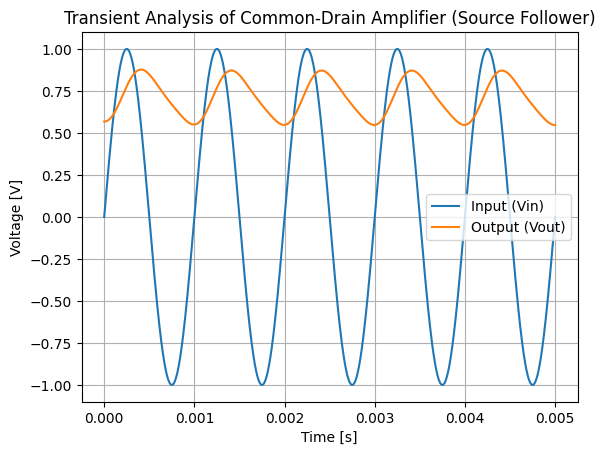

Should be unit less


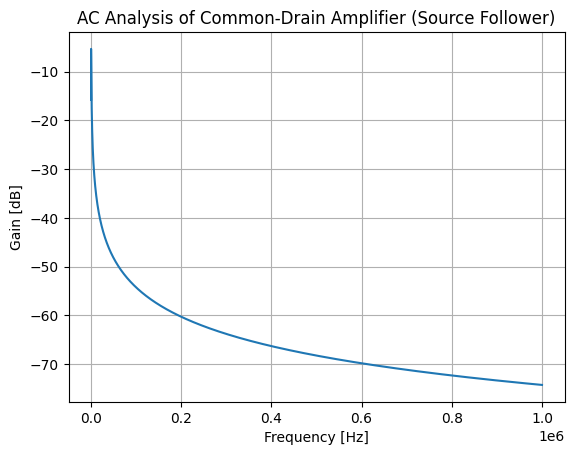

In [5]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Initialize the circuit
circuit = Circuit('Common-Drain Amplifier (Source Follower)')

# Define the supply voltage Vdd = 5V
circuit.V(1, 'Vdd', circuit.gnd, 5@u_V)

# Define the input voltage signal (DC = 0V, AC = 1V, Sinusoidal at 1kHz)
circuit.SinusoidalVoltageSource('Vin', 'input', circuit.gnd, 
                                amplitude=1@u_V, frequency=1@u_kHz)

# Input coupling capacitor (C1) from input to gate
circuit.C(1, 'input', 'gate', 1@u_uF)

# Bias resistors
circuit.R(2, 'Vdd', 'gate', 100@u_kΩ)  # Resistor R2
circuit.R(3, 'gate', circuit.gnd, 100@u_kΩ)  # Resistor R3

# NMOS transistor definition
circuit.MOSFET('M1', 'Vdd', 'gate', 'output', circuit.gnd, model='NMOS')

# Load resistor at the source (R1)
circuit.R(1, 'output', circuit.gnd, 1@u_kΩ)

# Output coupling capacitor (C2)
circuit.C(2, 'output', circuit.gnd, 1@u_uF)

# NMOS transistor model
circuit.model('NMOS', 'nmos', kp=0.00012, l=1e-6, lambda_=0.02, vto=1, w=1e-5)

# Set up the AC and transient simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Run transient analysis (step time = 1 µs, end time = 5 ms)
analysis_transient = simulator.transient(step_time=1@u_us, end_time=5@u_ms)

# Run AC analysis (from 1 Hz to 1 MHz)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=1000,variation='dec')

# Plot the transient response
plt.figure()
plt.plot(analysis_transient.time, analysis_transient['input'], label='Input (Vin)')
plt.plot(analysis_transient.time, analysis_transient['output'], label='Output (Vout)')
plt.title('Transient Analysis of Common-Drain Amplifier (Source Follower)')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid()
plt.show()

# Plot the AC response (magnitude in dB)
plt.figure()
plt.plot(analysis_ac.frequency, 20*np.log10(np.absolute(analysis_ac['output'])))
plt.title('AC Analysis of Common-Drain Amplifier (Source Follower)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid()
plt.show()

.title CMOS Inverter
Vdd vdd 0 5V
Vin input 0 DC 0V PULSE(0V 5V 0ns 1ns 1ns 20ns 40ns)
MM1 output input vdd vdd PMOS
MM2 output input 0 0 NMOS
.model NMOS nmos (gamma=0.37 kp=0.00012 l=1e-06 lambda=0.02 level=1 phi=0.65 vto=0.7 w=1e-05)
.model PMOS pmos (gamma=0.37 kp=6e-05 l=1e-06 lambda=0.02 level=1 phi=0.65 vto=-0.7 w=2e-05)



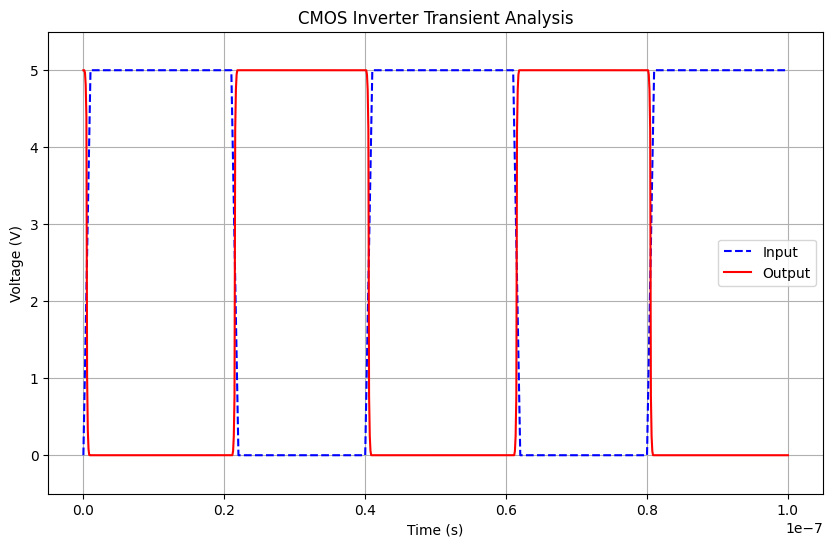

In [6]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Library import SpiceLibrary
import matplotlib.pyplot as plt
import numpy as np

# Create the CMOS Inverter circuit
circuit = Circuit('CMOS Inverter')

# Define the power supply and input voltage source
# VDD connected between vdd and ground
circuit.V('dd', 'vdd', circuit.gnd, 5@u_V)

# Input pulse for switching behavior
# Pulse parameters: initial value, pulsed value, delay, rise time, fall time, pulse width, period
circuit.PulseVoltageSource('in', 'input', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=5@u_V,
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=20@u_ns,
    period=40@u_ns
)

# Define NMOS and PMOS transistors
# PMOS: drain, gate, source, bulk
circuit.MOSFET('M1', 'output', 'input', 'vdd', 'vdd', model='PMOS')

# NMOS: drain, gate, source, bulk
circuit.MOSFET('M2', 'output', 'input', circuit.gnd, circuit.gnd, model='NMOS')

# Define MOSFET models with appropriate parameters
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,    # Transconductance parameter
    vto=0.7,      # Threshold voltage
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=10e-6,      # Channel width
    l=1e-6        # Channel length
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=60e-6,     # Transconductance parameter (half of NMOS due to mobility)
    vto=-0.7,     # Threshold voltage (negative for PMOS)
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=20e-6,      # Channel width (2x NMOS to compensate for mobility)
    l=1e-6        # Channel length
)

print(circuit)
# Create simulator
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Add simulation options for convergence
simulator.options(reltol=1e-4, abstol=1e-9, vntol=1e-6)

try:
    # Run transient analysis
    analysis = simulator.transient(step_time=0.1@u_ns, end_time=100@u_ns)

    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot input voltage
    plt.plot(analysis.time, analysis['input'], 
             label='Input', linestyle='--', color='blue')
    
    # Plot output voltage
    plt.plot(analysis.time, analysis['output'], 
             label='Output', color='red')
    
    # Customize plot
    plt.grid(True)
    plt.title('CMOS Inverter Transient Analysis')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    plt.ylim(-0.5, 5.5)
    
    # Show plot
    plt.show()

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Try adjusting simulation parameters or check circuit connections.")

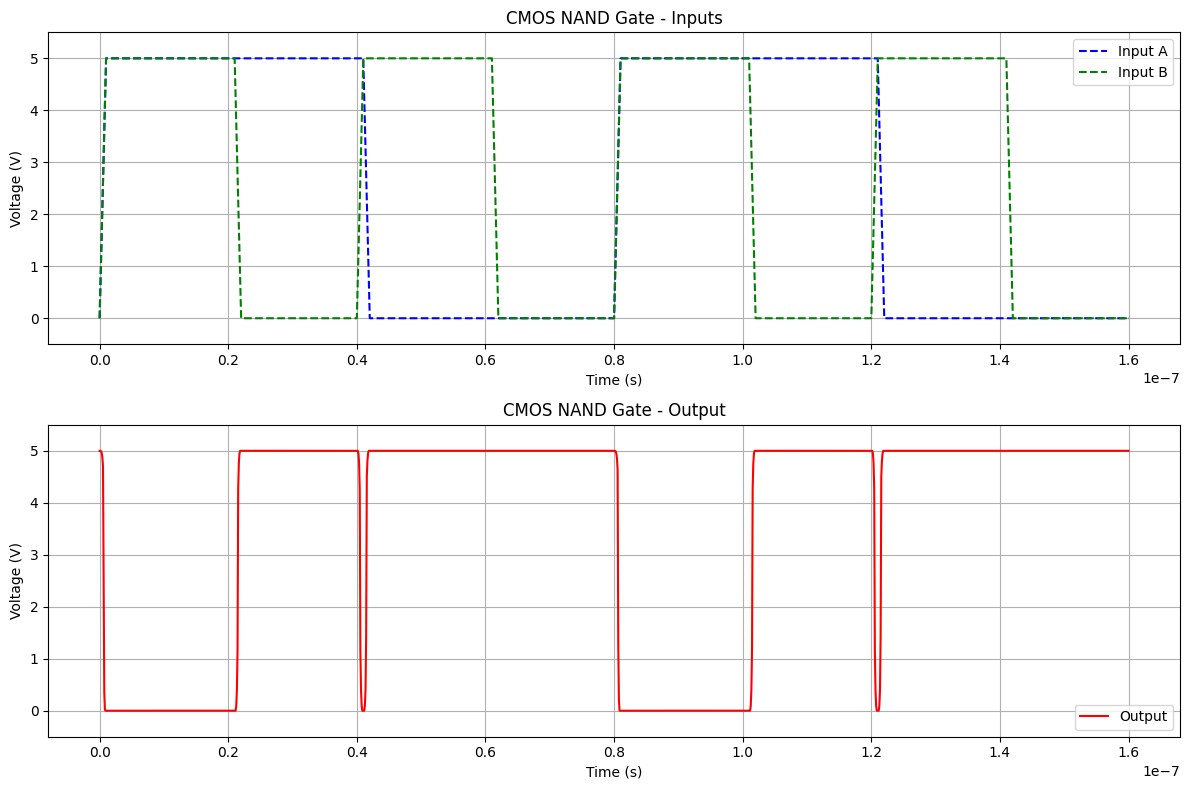

In [7]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Library import SpiceLibrary
import matplotlib.pyplot as plt
import numpy as np

# Create the CMOS NAND Gate circuit
circuit = Circuit('CMOS NAND Gate')

# Define power supply
circuit.V('dd', 'vdd', circuit.gnd, 5@u_V)

# Define input voltage sources
# Input A: Full period pulse
circuit.PulseVoltageSource('inA', 'inputA', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=5@u_V,
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=40@u_ns,
    period=80@u_ns
)

# Input B: Half period pulse
circuit.PulseVoltageSource('inB', 'inputB', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=5@u_V,
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=20@u_ns,
    period=40@u_ns
)

# Define PMOS transistors in parallel
# PMOS1: Connected to inputA
circuit.MOSFET('M1', 'output', 'inputA', 'vdd', 'vdd', model='PMOS')

# PMOS2: Connected to inputB
circuit.MOSFET('M2', 'output', 'inputB', 'vdd', 'vdd', model='PMOS')

# Define NMOS transistors in series
# NMOS1: Connected to inputA and intermediate node
circuit.MOSFET('M3', 'output', 'inputA', 'intermediate', circuit.gnd, model='NMOS')

# NMOS2: Connected to inputB and ground
circuit.MOSFET('M4', 'intermediate', 'inputB', circuit.gnd, circuit.gnd, model='NMOS')

# Define MOSFET models
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,    # Transconductance parameter
    vto=0.7,      # Threshold voltage
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=10e-6,      # Channel width
    l=1e-6        # Channel length
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=60e-6,     # Transconductance parameter
    vto=-0.7,     # Threshold voltage
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=20e-6,      # Channel width (2x NMOS width)
    l=1e-6        # Channel length
)

# Create simulator
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Add simulation options for better convergence
simulator.options(reltol=1e-4, abstol=1e-9, vntol=1e-6)

try:
    # Run transient analysis
    analysis = simulator.transient(step_time=0.1@u_ns, end_time=160@u_ns)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot inputs on first subplot
    ax1.plot(analysis.time, analysis['inputA'], 
             label='Input A', linestyle='--', color='blue')
    ax1.plot(analysis.time, analysis['inputB'], 
             label='Input B', linestyle='--', color='green')
    ax1.grid(True)
    ax1.set_title('CMOS NAND Gate - Inputs')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 5.5)
    
    # Plot output on second subplot
    ax2.plot(analysis.time, analysis['output'], 
             label='Output', color='red')
    ax2.grid(True)
    ax2.set_title('CMOS NAND Gate - Output')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 5.5)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Try adjusting simulation parameters or check circuit connections.")

# Optional: Add timing analysis
def analyze_timing(analysis):
    """Calculate propagation delays and transition times"""
    vdd = 5.0
    v_th = vdd / 2  # Threshold voltage for timing measurements
    
    # Find rising and falling edges
    edges = {
        'input_a': np.where(np.diff(analysis['inputA'] > v_th))[0],
        'input_b': np.where(np.diff(analysis['inputB'] > v_th))[0],
        'output': np.where(np.diff(analysis['output'] > v_th))[0]
    }
    
    # Calculate propagation delays
    prop_delays = []
    for i in range(min(len(edges['input_a']), len(edges['output']))):
        delay = abs(analysis.time[edges['output'][i]] - 
                   analysis.time[edges['input_a'][i]])
        prop_delays.append(float(delay))
    
    print(f"Average propagation delay: {np.mean(prop_delays):.2e} seconds")

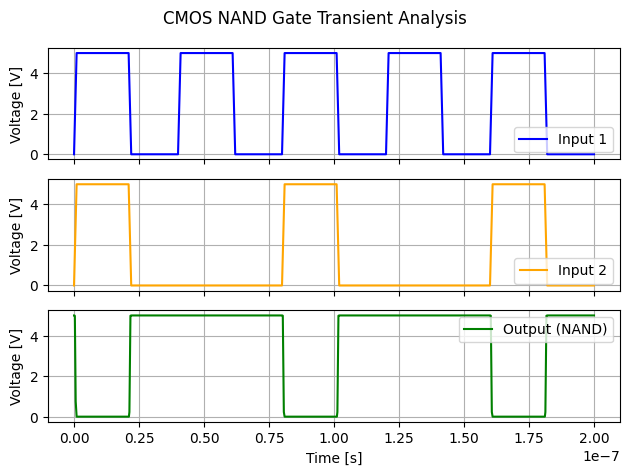

In [8]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
import matplotlib.pyplot as plt

# Create a new circuit
circuit = Circuit('CMOS NAND Gate')

# Define the power supply (Vdd = 5V)
circuit.V(1, 'Vdd', circuit.gnd, 5@u_V)

# Define input voltage sources (Pulse for both inputs)
circuit.PulseVoltageSource('Vin1', 'input1', circuit.gnd, 
                           initial_value=0@u_V, pulsed_value=5@u_V, 
                           rise_time=1@u_ns, fall_time=1@u_ns, 
                           pulse_width=20@u_ns, period=40@u_ns)

circuit.PulseVoltageSource('Vin2', 'input2', circuit.gnd, 
                           initial_value=0@u_V, pulsed_value=5@u_V, 
                           rise_time=1@u_ns, fall_time=1@u_ns, 
                           pulse_width=20@u_ns, period=80@u_ns)

# Define the two PMOS transistors in parallel
circuit.MOSFET('P1', 'Vdd', 'input1', 'output', 'Vdd', model='PMOS')
circuit.MOSFET('P2', 'Vdd', 'input2', 'output', 'Vdd', model='PMOS')

# Define the two NMOS transistors in series
circuit.MOSFET('N1', 'output', 'input1', 'n1', circuit.gnd, model='NMOS')
circuit.MOSFET('N2', 'n1', 'input2', circuit.gnd, circuit.gnd, model='NMOS')

# Define the NMOS and PMOS transistor models
circuit.model('NMOS', 'nmos', kp=120e-6, vto=1, lambda_=0.02, w=10e-6, l=1e-6)
circuit.model('PMOS', 'pmos', kp=60e-6, vto=-1, lambda_=0.02, w=20e-6, l=1e-6)

# Set up the transient analysis
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=10@u_ns, end_time=200@u_ns)

# Plot the input and output signals
fig, axs = plt.subplots(3, 1, sharex=True)  # Create 3 subplots, sharing the x-axis

# Input 1
axs[0].plot(analysis.time, analysis['input1'], label='Input 1', color='blue')
axs[0].set_ylabel('Voltage [V]')
axs[0].legend()
axs[0].grid()

# Input 2
axs[1].plot(analysis.time, analysis['input2'], label='Input 2', color='orange')
axs[1].set_ylabel('Voltage [V]')
axs[1].legend()
axs[1].grid()

# Output
axs[2].plot(analysis.time, analysis['output'], label='Output (NAND)', color='green')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Voltage [V]')
axs[2].legend()
axs[2].grid()

fig.suptitle('CMOS NAND Gate Transient Analysis')  # Overall title for the figure

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

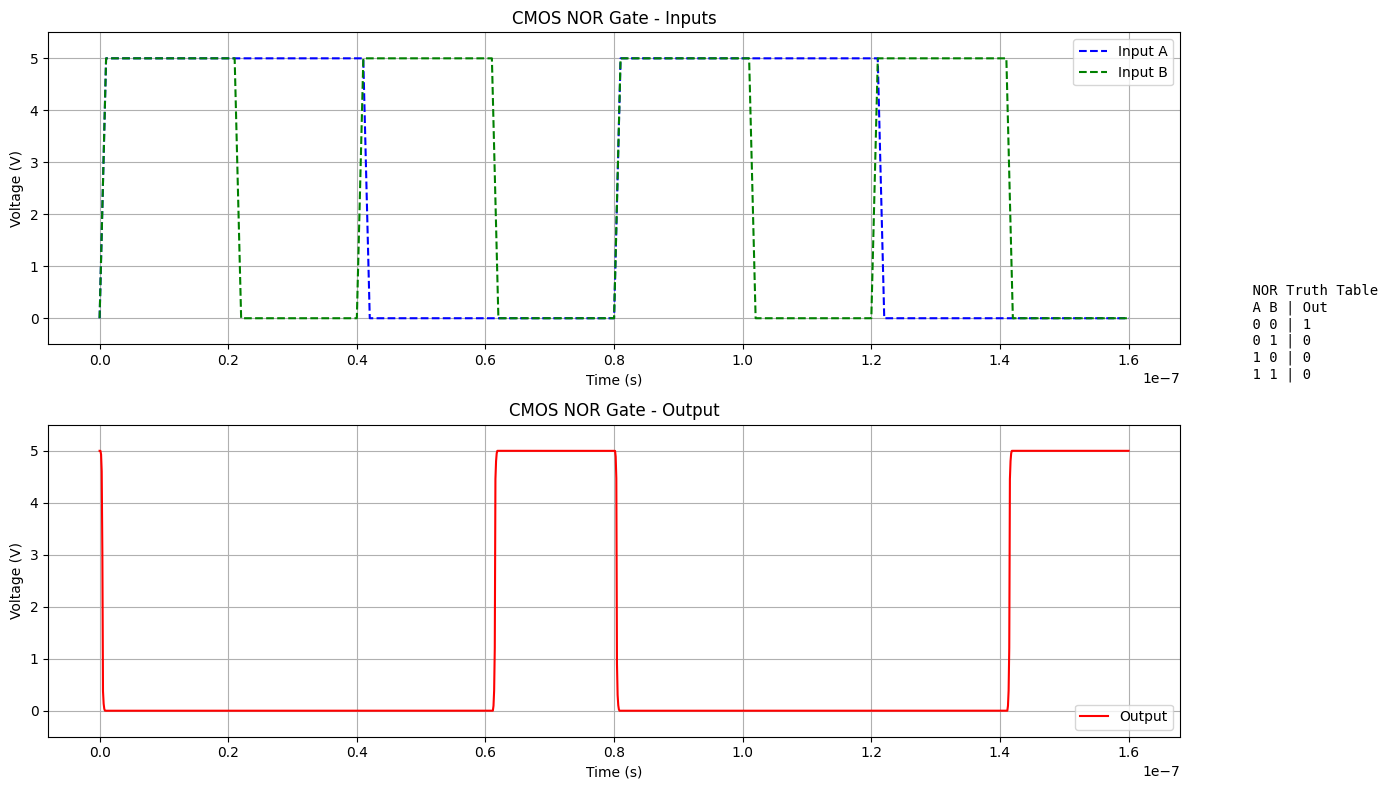

Simulation failed: '>' not supported between instances of 'UnitValue' and 'float'
Try adjusting simulation parameters or check circuit connections.


In [9]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Library import SpiceLibrary
import matplotlib.pyplot as plt
import numpy as np

# Create the CMOS NOR Gate circuit
circuit = Circuit('CMOS NOR Gate')

# Define power supply
circuit.V('dd', 'vdd', circuit.gnd, 5@u_V)

# Define input voltage sources
# Input A: Full period pulse
circuit.PulseVoltageSource('inA', 'inputA', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=5@u_V,
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=40@u_ns,
    period=80@u_ns
)

# Input B: Half period pulse
circuit.PulseVoltageSource('inB', 'inputB', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=5@u_V,
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=20@u_ns,
    period=40@u_ns
)

# Define PMOS transistors in series
# PMOS1: Connected to inputA and VDD
circuit.MOSFET('M1', 'intermediate', 'inputA', 'vdd', 'vdd', model='PMOS')

# PMOS2: Connected to inputB and intermediate node
circuit.MOSFET('M2', 'output', 'inputB', 'intermediate', 'vdd', model='PMOS')

# Define NMOS transistors in parallel
# NMOS1: Connected to inputA
circuit.MOSFET('M3', 'output', 'inputA', circuit.gnd, circuit.gnd, model='NMOS')

# NMOS2: Connected to inputB
circuit.MOSFET('M4', 'output', 'inputB', circuit.gnd, circuit.gnd, model='NMOS')

# Define MOSFET models
# PMOS width is increased to 40µm (4x NMOS) because they're in series
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,    # Transconductance parameter
    vto=0.7,      # Threshold voltage
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=10e-6,      # Channel width
    l=1e-6        # Channel length
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=60e-6,     # Transconductance parameter
    vto=-0.7,     # Threshold voltage
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=40e-6,      # Channel width (4x NMOS width due to series connection)
    l=1e-6        # Channel length
)

# Create simulator
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Add simulation options for better convergence
simulator.options(reltol=1e-4, abstol=1e-9, vntol=1e-6)

try:
    # Run transient analysis
    analysis = simulator.transient(step_time=0.1@u_ns, end_time=160@u_ns)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot inputs on first subplot
    ax1.plot(analysis.time, analysis['inputA'], 
             label='Input A', linestyle='--', color='blue')
    ax1.plot(analysis.time, analysis['inputB'], 
             label='Input B', linestyle='--', color='green')
    ax1.grid(True)
    ax1.set_title('CMOS NOR Gate - Inputs')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 5.5)
    
    # Plot output on second subplot
    ax2.plot(analysis.time, analysis['output'], 
             label='Output', color='red')
    ax2.grid(True)
    ax2.set_title('CMOS NOR Gate - Output')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 5.5)
    
    # Add truth table annotation
    truth_table = """
    NOR Truth Table
    A B | Out
    0 0 | 1
    0 1 | 0
    1 0 | 0
    1 1 | 0
    """
    plt.figtext(1.02, 0.5, truth_table, fontfamily='monospace')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Calculate and display timing characteristics
    def analyze_timing(analysis):
        """Calculate rise time, fall time, and propagation delay"""
        vdd = 5.0
        v_low = 0.1 * vdd
        v_high = 0.9 * vdd
        
        # Find transitions
        output = analysis['output']
        time = analysis.time
        
        # Find rising and falling edges
        rising_edges = []
        falling_edges = []
        
        for i in range(1, len(output)):
            if output[i-1] < v_low and output[i] > v_high:
                rising_edges.append(i)
            elif output[i-1] > v_high and output[i] < v_low:
                falling_edges.append(i)
        
        # Calculate average rise and fall times
        rise_times = []
        fall_times = []
        
        for edge in rising_edges:
            rise_time = float(time[edge] - time[edge-1])
            rise_times.append(rise_time)
            
        for edge in falling_edges:
            fall_time = float(time[edge] - time[edge-1])
            fall_times.append(fall_time)
            
        if rise_times:
            print(f"Average rise time: {np.mean(rise_times):.2e} seconds")
        if fall_times:
            print(f"Average fall time: {np.mean(fall_times):.2e} seconds")
    
    analyze_timing(analysis)

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Try adjusting simulation parameters or check circuit connections.")

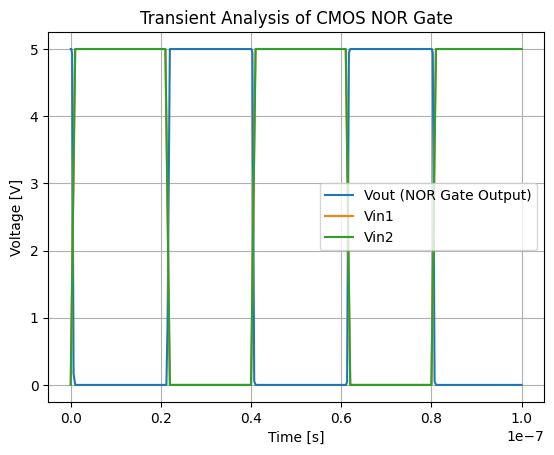

In [10]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
from PySpice.Probe.Plot import plot

# Create the circuit
circuit = Circuit('CMOS NOR Gate')

# Supply voltage (Vdd)
circuit.V(1, 'Vdd', circuit.gnd, 5@u_V)

# Inputs
circuit.PulseVoltageSource('Vin1', 'input1', circuit.gnd, initial_value=0@u_V, pulsed_value=5@u_V, rise_time=1@u_ns, fall_time=1@u_ns, pulse_width=20@u_ns, period=40@u_ns)
circuit.PulseVoltageSource('Vin2', 'input2', circuit.gnd, initial_value=0@u_V, pulsed_value=5@u_V, rise_time=1@u_ns, fall_time=1@u_ns, pulse_width=20@u_ns, period=40@u_ns)

# Define NMOS transistors (parallel connection)
circuit.MOSFET('M1', 'output', 'input1', circuit.gnd, circuit.gnd, model='NMOS')  # NMOS1
circuit.MOSFET('M2', 'output', 'input2', circuit.gnd, circuit.gnd, model='NMOS')  # NMOS2

# Define PMOS transistors (series connection)
circuit.MOSFET('M3', 'output', 'input1', 'Vdd', 'Vdd', model='PMOS')  # PMOS1
circuit.MOSFET('M4', 'output', 'input2', 'Vdd', 'Vdd', model='PMOS')  # PMOS2

# Define MOSFET models
circuit.model('NMOS', 'nmos', kp=120e-6, vto=1, lambda_=0.02, w=10e-6, l=1e-6)
circuit.model('PMOS', 'pmos', kp=60e-6, vto=-1, lambda_=0.02, w=20e-6, l=1e-6)

# Simulation settings: Transient analysis
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=10@u_ns, end_time=100@u_ns)

# Plot output
plt.figure()
plt.plot(analysis.time, analysis['output'], label='Vout (NOR Gate Output)')
plt.plot(analysis.time, analysis['input1'], label='Vin1')
plt.plot(analysis.time, analysis['input2'], label='Vin2')
plt.title('Transient Analysis of CMOS NOR Gate')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid()
plt.show()

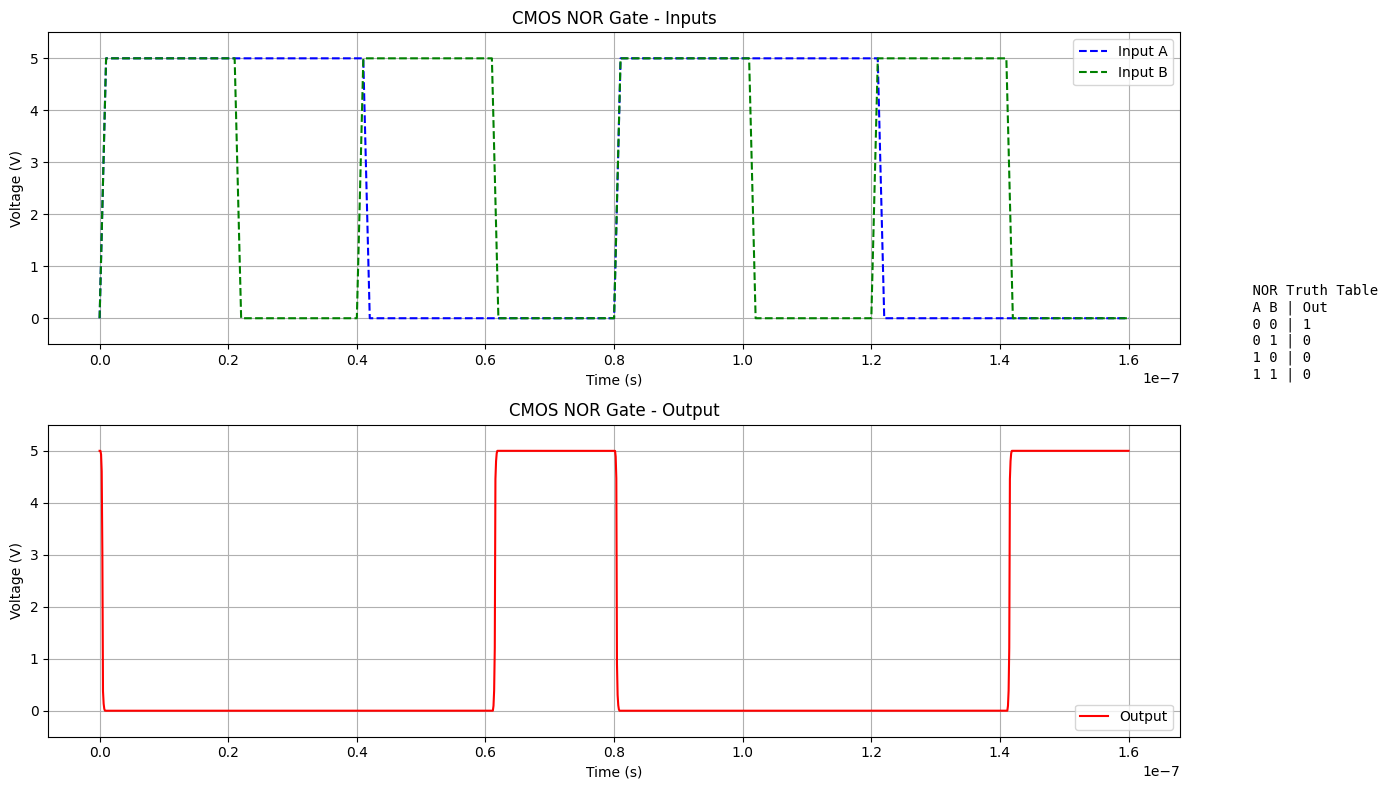

In [11]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Library import SpiceLibrary
import matplotlib.pyplot as plt
import numpy as np

# Create the CMOS NOR Gate circuit
circuit = Circuit('CMOS NOR Gate')

# Define power supply
circuit.V('dd', 'vdd', circuit.gnd, 5@u_V)

# Define input voltage sources
# Input A: Full period pulse
circuit.PulseVoltageSource('inA', 'inputA', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=5@u_V,
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=40@u_ns,
    period=80@u_ns
)

# Input B: Half period pulse
circuit.PulseVoltageSource('inB', 'inputB', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=5@u_V,
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=20@u_ns,
    period=40@u_ns
)

# Define PMOS transistors in series
# PMOS1: Connected to inputA and VDD
circuit.MOSFET('M1', 'intermediate', 'inputA', 'vdd', 'vdd', model='PMOS')

# PMOS2: Connected to inputB and intermediate node
circuit.MOSFET('M2', 'output', 'inputB', 'intermediate', 'vdd', model='PMOS')

# Define NMOS transistors in parallel
# NMOS1: Connected to inputA
circuit.MOSFET('M3', 'output', 'inputA', circuit.gnd, circuit.gnd, model='NMOS')

# NMOS2: Connected to inputB
circuit.MOSFET('M4', 'output', 'inputB', circuit.gnd, circuit.gnd, model='NMOS')

# Define MOSFET models
# PMOS width is increased to 40µm (4x NMOS) because they're in series
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,    # Transconductance parameter
    vto=0.7,      # Threshold voltage
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=10e-6,      # Channel width
    l=1e-6        # Channel length
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=60e-6,     # Transconductance parameter
    vto=-0.7,     # Threshold voltage
    lambda_=0.02, # Channel length modulation
    gamma=0.37,   # Body effect parameter
    phi=0.65,     # Surface potential
    w=40e-6,      # Channel width (4x NMOS width due to series connection)
    l=1e-6        # Channel length
)

# Create simulator
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Add simulation options for better convergence
simulator.options(reltol=1e-4, abstol=1e-9, vntol=1e-6)

try:
    # Run transient analysis
    analysis = simulator.transient(step_time=0.1@u_ns, end_time=160@u_ns)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot inputs on first subplot
    ax1.plot(analysis.time, analysis['inputA'], 
             label='Input A', linestyle='--', color='blue')
    ax1.plot(analysis.time, analysis['inputB'], 
             label='Input B', linestyle='--', color='green')
    ax1.grid(True)
    ax1.set_title('CMOS NOR Gate - Inputs')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 5.5)
    
    # Plot output on second subplot
    ax2.plot(analysis.time, analysis['output'], 
             label='Output', color='red')
    ax2.grid(True)
    ax2.set_title('CMOS NOR Gate - Output')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 5.5)
    
    # Add truth table annotation
    truth_table = """
    NOR Truth Table
    A B | Out
    0 0 | 1
    0 1 | 0
    1 0 | 0
    1 1 | 0
    """
    plt.figtext(1.02, 0.5, truth_table, fontfamily='monospace')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Calculate and display timing characteristics
    def analyze_timing(analysis):
        """Calculate rise time, fall time, and propagation delay"""
        vdd = 5.0
        v_low = 0.1 * vdd
        v_high = 0.9 * vdd
        
        # Convert to numpy arrays to avoid UnitValue comparison issues
        output = np.array(analysis['output'])
        time = np.array(analysis.time)
        
        # Find rising and falling edges
        rising_edges = []
        falling_edges = []
        
        for i in range(1, len(output)):
            if output[i-1] < v_low and output[i] > v_high:
                rising_edges.append(i)
            elif output[i-1] > v_high and output[i] < v_low:
                falling_edges.append(i)
        
        # Calculate average rise and fall times
        rise_times = []
        fall_times = []
        
        for edge in rising_edges:
            rise_time = time[edge] - time[edge-1]
            rise_times.append(rise_time)
            
        for edge in falling_edges:
            fall_time = time[edge] - time[edge-1]
            fall_times.append(fall_time)
            
        if rise_times:
            print(f"Average rise time: {np.mean(rise_times):.2e} seconds")
        if fall_times:
            print(f"Average fall time: {np.mean(fall_times):.2e} seconds")
    
    analyze_timing(analysis)

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Try adjusting simulation parameters or check circuit connections.")

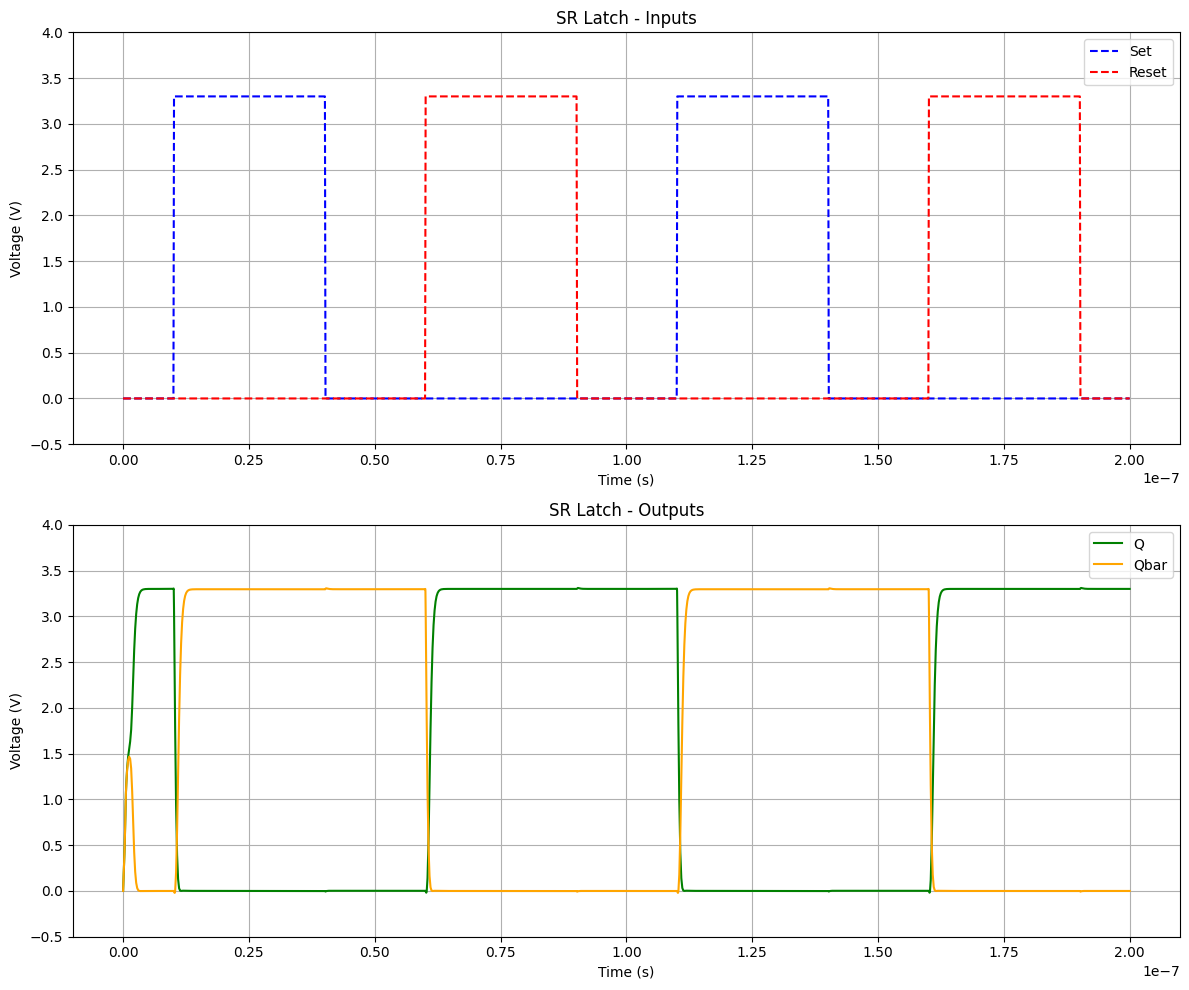

Average Set-to-Q delay: 5.10e-08 seconds
Average Reset-to-Q delay: 5.04e-08 seconds
.title SR Latch
Vdd vdd 0 DC 0V PULSE(0V 3.3V 0ns 0.5ns 0.5ns 250ns 250ns)
RRvdd vdd vdd_internal 1Ohm
CCvdd vdd_internal 0 1pF
Vset S 0 DC 0V PULSE(0V 3.3V 10ns 0.1ns 0.1ns 30ns 100ns)
Vreset R 0 DC 0V PULSE(0V 3.3V 60ns 0.1ns 0.1ns 30ns 100ns)
RRin_S S S_int 100Ohm
CCin_S S_int 0 0.1pF
RRin_R R R_int 100Ohm
CCin_R R_int 0 0.1pF
MM1 int1 S_int vdd_internal vdd_internal PMOS
MM2 Q Qbar int1 vdd_internal PMOS
CCQ Q 0 0.1pF
MM3 Q S_int 0 0 NMOS
MM4 Q Qbar 0 0 NMOS
MM5 int2 R_int vdd_internal vdd_internal PMOS
MM6 Qbar Q int2 vdd_internal PMOS
CCQbar Qbar 0 0.1pF
MM7 Qbar R_int 0 0 NMOS
MM8 Qbar Q 0 0 NMOS
RRQ_pu Q vdd_internal 1MegOhm
RRQbar_pd Qbar 0 1MegOhm
.model NMOS nmos (cbd=1e-13 cbs=1e-13 cgdo=6e-10 cgso=6e-10 gamma=0.4 kp=0.00012 l=3.5e-07 lambda=0.01 level=1 phi=0.65 vto=0.7 w=2e-06)
.model PMOS pmos (cbd=1e-13 cbs=1e-13 cgdo=6e-10 cgso=6e-10 gamma=0.4 kp=4e-05 l=3.5e-07 lambda=0.01 level=1 phi=

In [12]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the SR Latch circuit
circuit = Circuit('SR Latch')

# Define power supply with ramp-up
circuit.PulseVoltageSource('dd', 'vdd', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,  # Using 3.3V for better stability
    delay_time=0@u_ns,
    rise_time=0.5@u_ns,
    fall_time=0.5@u_ns,
    pulse_width=250@u_ns,
    period=250@u_ns
)

# Add supply resistor and decoupling capacitor
circuit.R('Rvdd', 'vdd', 'vdd_internal', 1@u_Ω)
circuit.C('Cvdd', 'vdd_internal', circuit.gnd, 1@u_pF)

# Define input voltage sources with delayed start
# Set input pulse
circuit.PulseVoltageSource('set', 'S', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=10@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=30@u_ns,
    period=100@u_ns
)

# Reset input pulse
circuit.PulseVoltageSource('reset', 'R', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=60@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=30@u_ns,
    period=100@u_ns
)

# Add input protection and parasitic capacitance
for node in ['S', 'R']:
    circuit.R(f'Rin_{node}', node, f'{node}_int', 100@u_Ω)
    circuit.C(f'Cin_{node}', f'{node}_int', circuit.gnd, 0.1@u_pF)

# NOR Gate 1 (Set side)
# PMOS transistors in series
circuit.MOSFET('M1', 'int1', 'S_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M2', 'Q', 'Qbar', 'int1', 'vdd_internal', model='PMOS')
circuit.C('CQ', 'Q', circuit.gnd, 0.1@u_pF)

# NMOS transistors in parallel
circuit.MOSFET('M3', 'Q', 'S_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.MOSFET('M4', 'Q', 'Qbar', circuit.gnd, circuit.gnd, model='NMOS')

# NOR Gate 2 (Reset side)
# PMOS transistors in series
circuit.MOSFET('M5', 'int2', 'R_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M6', 'Qbar', 'Q', 'int2', 'vdd_internal', model='PMOS')
circuit.C('CQbar', 'Qbar', circuit.gnd, 0.1@u_pF)

# NMOS transistors in parallel
circuit.MOSFET('M7', 'Qbar', 'R_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.MOSFET('M8', 'Qbar', 'Q', circuit.gnd, circuit.gnd, model='NMOS')

# Add weak pull-up/pull-down resistors for initial state
circuit.R('RQ_pu', 'Q', 'vdd_internal', 1@u_MΩ)
circuit.R('RQbar_pd', 'Qbar', circuit.gnd, 1@u_MΩ)

# Define MOSFET models with more realistic parameters
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=2e-6,
    l=0.35e-6
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=40e-6,
    vto=-0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=6e-6,
    l=0.35e-6
)

# Create simulator with modified parameters
simulator = circuit.simulator(temperature=27, nominal_temperature=27)

# Add simulation options for better convergence
simulator.options(
    reltol=1e-3,
    abstol=1e-6,
    vntol=1e-4,
    chgtol=1e-14,
    trtol=7,
    itl1=100,
    itl2=50,
    itl4=50,
    method='gear'
)

try:
    # Run transient analysis
    analysis = simulator.transient(
        step_time=0.1@u_ns,
        end_time=200@u_ns,
        start_time=0@u_ns,
        max_time=0.2@u_ns,
        use_initial_condition=True
    )

    # Convert time and voltage data to numpy arrays
    time = np.array([float(t) for t in analysis.time])
    vs = np.array([float(v) for v in analysis['S']])
    vr = np.array([float(v) for v in analysis['R']])
    vq = np.array([float(v) for v in analysis['Q']])
    vqbar = np.array([float(v) for v in analysis['Qbar']])

    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot inputs
    ax1.plot(time, vs, label='Set', linestyle='--', color='blue')
    ax1.plot(time, vr, label='Reset', linestyle='--', color='red')
    ax1.grid(True)
    ax1.set_title('SR Latch - Inputs')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 4)

    # Plot outputs
    ax2.plot(time, vq, label='Q', color='green')
    ax2.plot(time, vqbar, label='Qbar', color='orange')
    ax2.grid(True)
    ax2.set_title('SR Latch - Outputs')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 4)

    plt.tight_layout()
    plt.show()

    # Analyze timing characteristics
    def analyze_timing(time, vs, vr, vq, vqbar, vth=1.65):
        """Calculate propagation delays and verify functionality"""
        def find_edges(time, signal, rising=True):
            edges = []
            for i in range(1, len(signal)):
                if rising and signal[i-1] < vth < signal[i]:
                    edges.append(i)
                elif not rising and signal[i-1] > vth > signal[i]:
                    edges.append(i)
            return edges

        # Find rising and falling edges
        s_edges = find_edges(time, vs, rising=True)
        r_edges = find_edges(time, vr, rising=True)
        q_edges_r = find_edges(time, vq, rising=True)
        q_edges_f = find_edges(time, vq, rising=False)

        # Calculate delays
        set_delays = []
        reset_delays = []

        for s_edge in s_edges:
            for q_edge in q_edges_r:
                if q_edge > s_edge:
                    delay = time[q_edge] - time[s_edge]
                    set_delays.append(delay)
                    break

        for r_edge in r_edges:
            for q_edge in q_edges_f:
                if q_edge > r_edge:
                    delay = time[q_edge] - time[r_edge]
                    reset_delays.append(delay)
                    break

        if set_delays:
            print(f"Average Set-to-Q delay: {np.mean(set_delays):.2e} seconds")
        if reset_delays:
            print(f"Average Reset-to-Q delay: {np.mean(reset_delays):.2e} seconds")

    analyze_timing(time, vs, vr, vq, vqbar)

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

print(circuit)

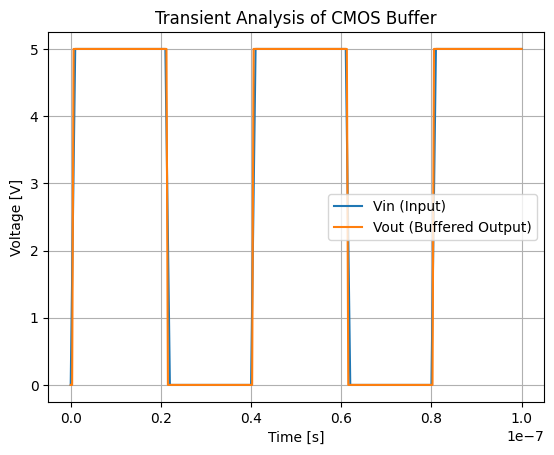

In [14]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
from PySpice.Probe.Plot import plot

# Create the circuit
circuit = Circuit('CMOS Buffer')

# Supply voltage (Vdd)
circuit.V(1, 'Vdd', circuit.gnd, 5@u_V)

# Input signal
circuit.PulseVoltageSource('Vin', 'input', circuit.gnd, initial_value=0@u_V, pulsed_value=5@u_V, rise_time=1@u_ns, fall_time=1@u_ns, pulse_width=20@u_ns, period=40@u_ns)

# First Inverter (Inverter 1)
# PMOS transistor
circuit.MOSFET('PM1', 'out1', 'input', 'Vdd', 'Vdd', model='PMOS')
# NMOS transistor
circuit.MOSFET('NM1', 'out1', 'input', circuit.gnd, circuit.gnd, model='NMOS')

# Second Inverter (Inverter 2, connected to the output of the first)
# PMOS transistor
circuit.MOSFET('PM2', 'output', 'out1', 'Vdd', 'Vdd', model='PMOS')
# NMOS transistor
circuit.MOSFET('NM2', 'output', 'out1', circuit.gnd, circuit.gnd, model='NMOS')

# Define MOSFET models (NMOS and PMOS)
circuit.model('NMOS', 'nmos', kp=120e-6, vto=1, lambda_=0.02, w=10e-6, l=1e-6)
circuit.model('PMOS', 'pmos', kp=60e-6, vto=-1, lambda_=0.02, w=20e-6, l=1e-6)

# Simulation settings: Transient analysis
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1@u_ns, end_time=100@u_ns)

# Plot input and output signals
plt.figure()
plt.plot(analysis.time, analysis['input'], label='Vin (Input)')
plt.plot(analysis.time, analysis['output'], label='Vout (Buffered Output)')
plt.title('Transient Analysis of CMOS Buffer')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid()
plt.show()

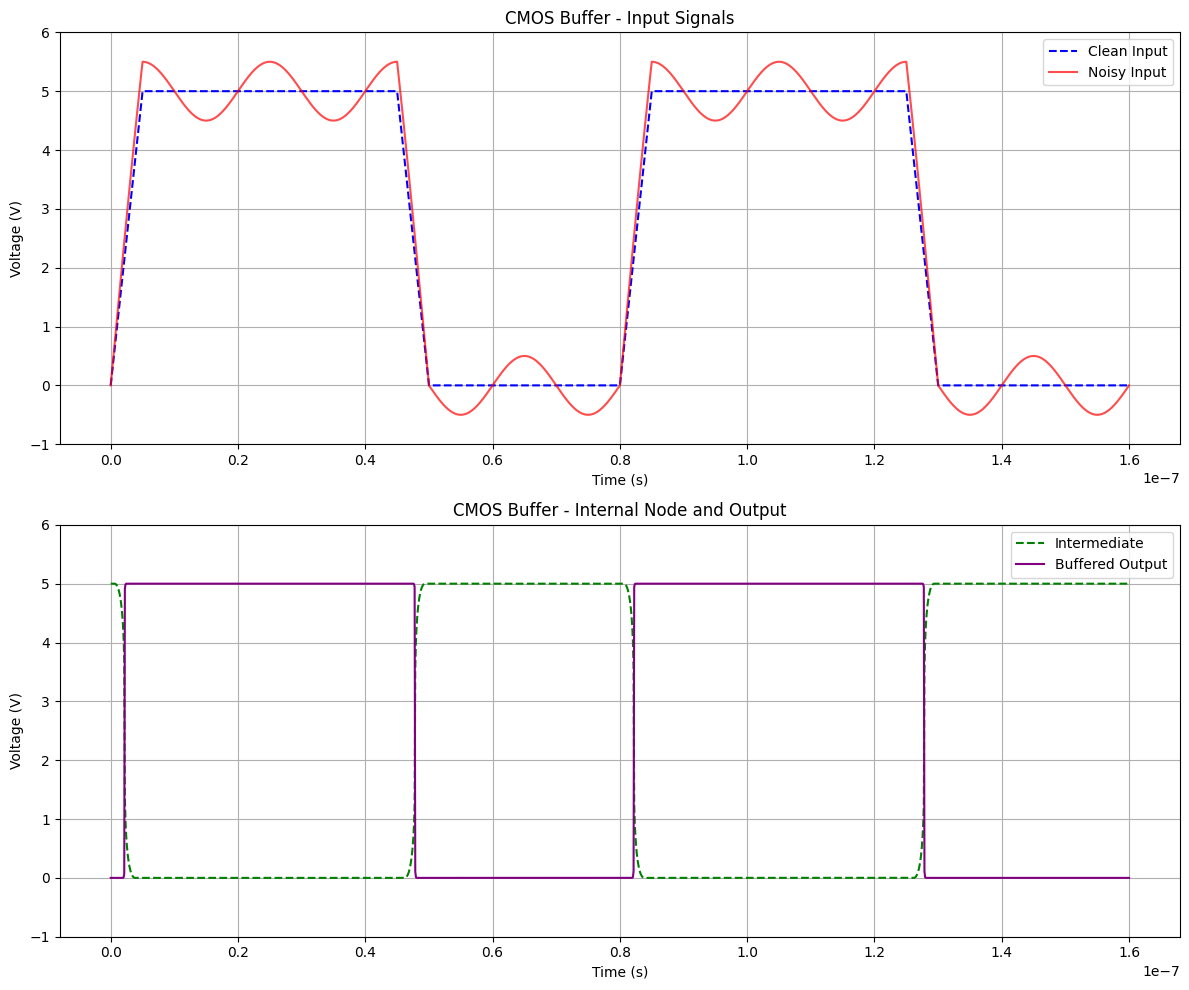

Average rise propagation delay: -1.80e-09 seconds
Average fall propagation delay: -1.80e-09 seconds
Noise reduction: -0.8%
.title CMOS Buffer
Vdd vdd 0 5V
Vin input 0 DC 0V PULSE(0V 5V 0ns 5ns 5ns 40ns 80ns)
Vnoise input_noisy input DC 0V AC 1V SIN(0V 0.5V 50MegHz 0s 0Hz)
MM1 intermediate input_noisy vdd vdd PMOS1
MM2 intermediate input_noisy 0 0 NMOS1
MM3 output intermediate vdd vdd PMOS2
MM4 output intermediate 0 0 NMOS2
.model NMOS1 nmos (gamma=0.37 kp=0.00012 l=1e-06 lambda=0.02 level=1 phi=0.65 vto=0.7 w=1e-05)
.model PMOS1 pmos (gamma=0.37 kp=6e-05 l=1e-06 lambda=0.02 level=1 phi=0.65 vto=-0.7 w=2e-05)
.model NMOS2 nmos (gamma=0.37 kp=0.00012 l=1e-06 lambda=0.02 level=1 phi=0.65 vto=0.7 w=2e-05)
.model PMOS2 pmos (gamma=0.37 kp=6e-05 l=1e-06 lambda=0.02 level=1 phi=0.65 vto=-0.7 w=4e-05)



In [15]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the CMOS Buffer circuit
circuit = Circuit('CMOS Buffer')

# Define power supply
Vdd = 5
circuit.V('dd', 'vdd', circuit.gnd, Vdd@u_V)

# Define input voltage source
circuit.PulseVoltageSource('in', 'input', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=Vdd@u_V,
    delay_time=0@u_ns,
    rise_time=5@u_ns,
    fall_time=5@u_ns,
    pulse_width=40@u_ns,
    period=80@u_ns
)

# Add noise to the input
circuit.SinusoidalVoltageSource('noise', 'input_noisy', 'input',
    amplitude=0.5@u_V,
    frequency=50@u_MHz
)

# First Inverter Stage
circuit.MOSFET('M1', 'intermediate', 'input_noisy', 'vdd', 'vdd', model='PMOS1')
circuit.MOSFET('M2', 'intermediate', 'input_noisy', circuit.gnd, circuit.gnd, model='NMOS1')

# Second Inverter Stage
circuit.MOSFET('M3', 'output', 'intermediate', 'vdd', 'vdd', model='PMOS2')
circuit.MOSFET('M4', 'output', 'intermediate', circuit.gnd, circuit.gnd, model='NMOS2')

# Define MOSFET models - first stage
circuit.model('NMOS1', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.02,
    gamma=0.37,
    phi=0.65,
    w=10e-6,
    l=1e-6
)

circuit.model('PMOS1', 'pmos',
    level=1,
    kp=60e-6,
    vto=-0.7,
    lambda_=0.02,
    gamma=0.37,
    phi=0.65,
    w=20e-6,
    l=1e-6
)

# Define MOSFET models - second stage
circuit.model('NMOS2', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.02,
    gamma=0.37,
    phi=0.65,
    w=20e-6,
    l=1e-6
)

circuit.model('PMOS2', 'pmos',
    level=1,
    kp=60e-6,
    vto=-0.7,
    lambda_=0.02,
    gamma=0.37,
    phi=0.65,
    w=40e-6,
    l=1e-6
)

# Create simulator
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options(reltol=1e-4, abstol=1e-9, vntol=1e-6)

try:
    # Run transient analysis
    analysis = simulator.transient(step_time=0.1@u_ns, end_time=160@u_ns)
    
    # Convert analysis results to numpy arrays for easier processing
    time = np.array([float(t) for t in analysis.time])
    input_signal = np.array([float(v) for v in analysis['input']])
    input_noisy = np.array([float(v) for v in analysis['input_noisy']])
    intermediate = np.array([float(v) for v in analysis['intermediate']])
    output = np.array([float(v) for v in analysis['output']])
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot input signals
    ax1.plot(time, input_signal, label='Clean Input', linestyle='--', color='blue')
    ax1.plot(time, input_noisy, label='Noisy Input', color='red', alpha=0.7)
    ax1.grid(True)
    ax1.set_title('CMOS Buffer - Input Signals')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-1, 6)
    
    # Plot intermediate and output signals
    ax2.plot(time, intermediate, label='Intermediate', linestyle='--', color='green')
    ax2.plot(time, output, label='Buffered Output', color='purple')
    ax2.grid(True)
    ax2.set_title('CMOS Buffer - Internal Node and Output')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-1, 6)
    
    plt.tight_layout()
    plt.show()

    # Analyze buffer characteristics
    def analyze_buffer(time, input_signal, output, vdd=5.0):
        v_low = 0.1 * vdd
        v_high = 0.9 * vdd
        
        def find_crossings(signal, threshold, rising=True):
            crossings = []
            for i in range(1, len(signal)):
                if rising:
                    if signal[i-1] < threshold < signal[i]:
                        crossings.append(i)
                else:
                    if signal[i-1] > threshold > signal[i]:
                        crossings.append(i)
            return crossings
        
        # Find rising and falling transitions
        input_rise = find_crossings(input_signal, v_high, rising=True)
        input_fall = find_crossings(input_signal, v_low, rising=False)
        output_rise = find_crossings(output, v_high, rising=True)
        output_fall = find_crossings(output, v_low, rising=False)
        
        # Calculate delays
        rise_delays = []
        fall_delays = []
        
        for in_idx, out_idx in zip(input_rise, output_rise):
            delay = time[out_idx] - time[in_idx]
            rise_delays.append(delay)
            
        for in_idx, out_idx in zip(input_fall, output_fall):
            delay = time[out_idx] - time[in_idx]
            fall_delays.append(delay)
        
        # Print results
        if rise_delays:
            print(f"Average rise propagation delay: {np.mean(rise_delays):.2e} seconds")
        if fall_delays:
            print(f"Average fall propagation delay: {np.mean(fall_delays):.2e} seconds")
        
        # Calculate noise reduction
        input_noise = np.std(input_signal)
        output_noise = np.std(output)
        noise_reduction = (1 - output_noise/input_noise) * 100
        print(f"Noise reduction: {noise_reduction:.1f}%")
    
    analyze_buffer(time, input_noisy, output)

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Try adjusting simulation parameters or check circuit connections.")

print(circuit)

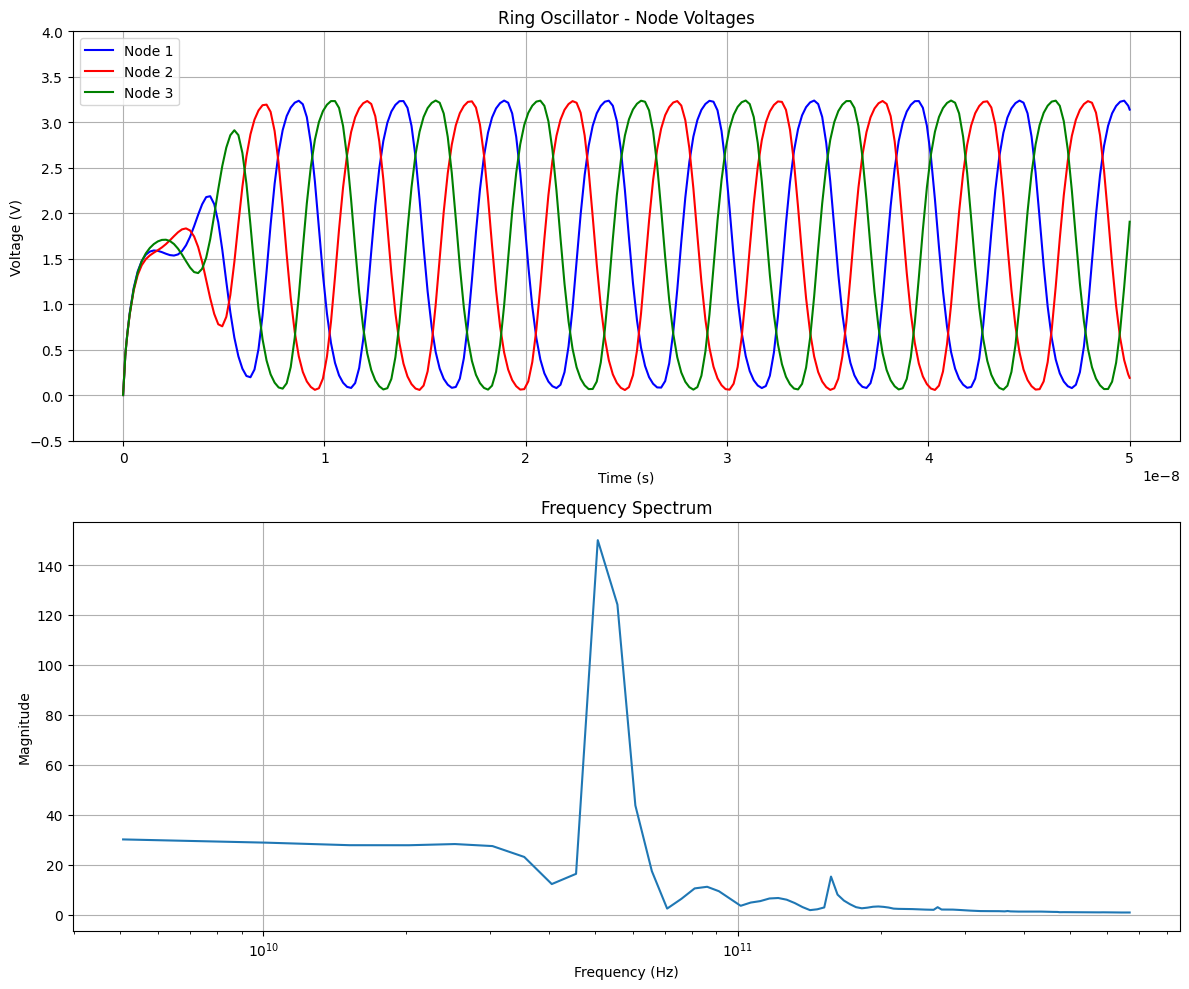

Oscillation Frequency: 413.22 MHz
Period: 0.00 ns
.title 3-Stage Ring Oscillator
Vdd vdd 0 DC 0V PULSE(0V 3.3V 0ns 0.1ns 0.1ns 100ns 100ns)
RRvdd vdd vdd_internal 1Ohm
MM1 node1 node3 vdd_internal vdd_internal PMOS
MM2 node1 node3 0 0 NMOS
RR1 node1 vdd_internal 100kOhm
MM3 node2 node1 vdd_internal vdd_internal PMOS
MM4 node2 node1 0 0 NMOS
MM5 node3 node2 vdd_internal vdd_internal PMOS
MM6 node3 node2 0 0 NMOS
CC1 node1 0 0.5pF
CC2 node2 0 0.5pF
CC3 node3 0 0.5pF
.model NMOS nmos (cbd=1e-13 cbs=1e-13 cgdo=6e-10 cgso=6e-10 gamma=0.4 kp=0.00012 l=3.5e-07 lambda=0.01 level=1 phi=0.65 vto=0.7 w=2e-06)
.model PMOS pmos (cbd=1e-13 cbs=1e-13 cgdo=6e-10 cgso=6e-10 gamma=0.4 kp=4e-05 l=3.5e-07 lambda=0.01 level=1 phi=0.65 vto=-0.7 w=6e-06)



In [17]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the Ring Oscillator circuit
circuit = Circuit('3-Stage Ring Oscillator')

# Define power supply with ramp-up to improve convergence
circuit.PulseVoltageSource('dd', 'vdd', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,  # Using 3.3V for better stability
    delay_time=0@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=100@u_ns,
    period=100@u_ns
)

# Add small resistor in series with Vdd for better convergence
circuit.R('Rvdd', 'vdd', 'vdd_internal', 1@u_Ω)

# First Inverter Stage
circuit.MOSFET('M1', 'node1', 'node3', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M2', 'node1', 'node3', circuit.gnd, circuit.gnd, model='NMOS')
circuit.R('R1', 'node1', 'vdd_internal', 100@u_kΩ)  # Pull-up to help start oscillation

# Second Inverter Stage
circuit.MOSFET('M3', 'node2', 'node1', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M4', 'node2', 'node1', circuit.gnd, circuit.gnd, model='NMOS')

# Third Inverter Stage
circuit.MOSFET('M5', 'node3', 'node2', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M6', 'node3', 'node2', circuit.gnd, circuit.gnd, model='NMOS')

# Add parasitic capacitance
circuit.C('C1', 'node1', circuit.gnd, 0.5@u_pF)
circuit.C('C2', 'node2', circuit.gnd, 0.5@u_pF)
circuit.C('C3', 'node3', circuit.gnd, 0.5@u_pF)

# Define MOSFET models with more realistic parameters
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=2e-6,
    l=0.35e-6
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=40e-6,
    vto=-0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=6e-6,
    l=0.35e-6
)

# Create simulator with modified parameters
simulator = circuit.simulator(temperature=27, nominal_temperature=27)

# Add simulation options for better convergence
simulator.options(
    reltol=1e-3,
    abstol=1e-6,
    vntol=1e-4,
    chgtol=1e-14,
    trtol=7,
    itl1=100,
    itl2=50,
    itl4=50,
    method='gear'  # Use Gear integration method for better stability
)

try:
    # Run transient analysis with modified parameters
    analysis = simulator.transient(
        step_time=0.1@u_ns,
        end_time=50@u_ns,
        start_time=0@u_ns,
        max_time=0.2@u_ns,
        use_initial_condition=True
    )

    # Convert time and voltage data to numpy arrays
    time = np.array([float(t) for t in analysis.time])
    v1 = np.array([float(v) for v in analysis['node1']])
    v2 = np.array([float(v) for v in analysis['node2']])
    v3 = np.array([float(v) for v in analysis['node3']])

    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot node voltages
    ax1.plot(time, v1, label='Node 1', color='blue')
    ax1.plot(time, v2, label='Node 2', color='red')
    ax1.plot(time, v3, label='Node 3', color='green')
    ax1.grid(True)
    ax1.set_title('Ring Oscillator - Node Voltages')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 4)

    # Calculate and plot oscillation frequency
    def calculate_frequency(time, voltage, threshold=1.65):
        crossings = np.where(np.diff(voltage > threshold))[0]
        if len(crossings) >= 2:
            periods = np.diff(time[crossings])
            freq = 1.0 / np.mean(periods)
            return freq
        return None

    # Plot FFT of node3 (output)
    if len(time) > 1:
        sampling_rate = 1.0 / (time[1] - time[0])
        n = len(v3)
        freqs = np.fft.fftfreq(n, 1/sampling_rate)
        fft_v3 = np.abs(np.fft.fft(v3))
        
        # Plot only positive frequencies
        mask = freqs > 0
        ax2.plot(freqs[mask], fft_v3[mask])
        ax2.grid(True)
        ax2.set_title('Frequency Spectrum')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.set_xscale('log')

    plt.tight_layout()
    plt.show()

    # Calculate and display oscillation characteristics
    freq = calculate_frequency(time, v3)
    if freq is not None:
        print(f"Oscillation Frequency: {freq/1e6:.2f} MHz")
        print(f"Period: {1000/freq:.2f} ns")

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

print(circuit)

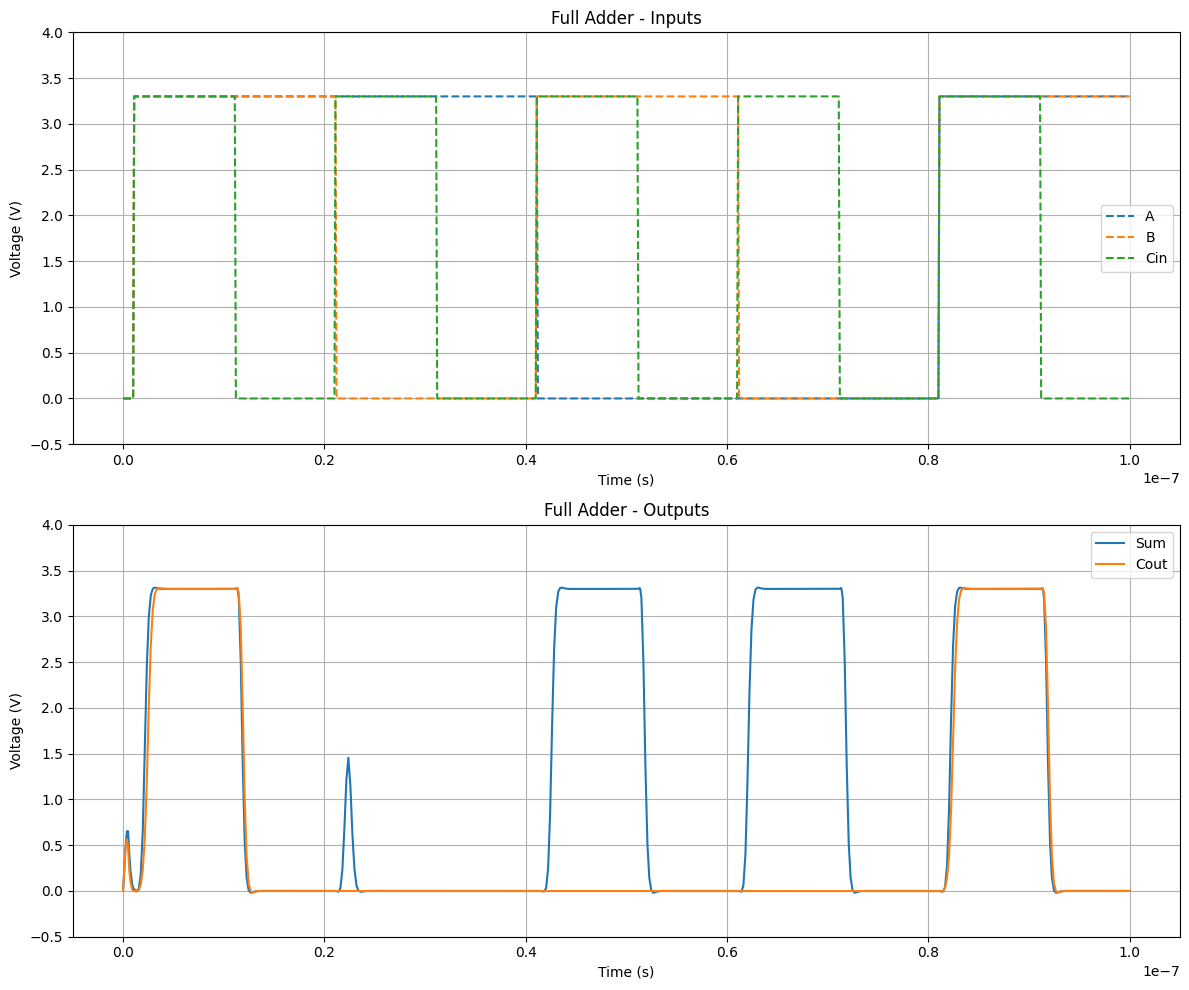

Average Sum propagation delay: 1.21e-09 seconds
Average Cout propagation delay: 1.50e-09 seconds
.title CMOS Full Adder
Vdd vdd 0 DC 0V PULSE(0V 3.3V 0ns 0.5ns 0.5ns 200ns 200ns)
RRvdd vdd vdd_internal 1Ohm
CCvdd vdd_internal 0 1pF
VinA A 0 DC 0V PULSE(0V 3.3V 1ns 0.1ns 0.1ns 40ns 80ns)
VinB B 0 DC 0V PULSE(0V 3.3V 1ns 0.1ns 0.1ns 20ns 40ns)
VinCin Cin 0 DC 0V PULSE(0V 3.3V 1ns 0.1ns 0.1ns 10ns 20ns)
RRin_A A A_int 100Ohm
CCin_A A_int 0 0.1pF
RRin_B B B_int 100Ohm
CCin_B B_int 0 0.1pF
RRin_Cin Cin Cin_int 100Ohm
CCin_Cin Cin_int 0 0.1pF
MM1 nand1_out A_int vdd_internal vdd_internal PMOS
MM2 nand1_out B_int vdd_internal vdd_internal PMOS
MM3 nand1_out A_int nand1_n 0 NMOS
MM4 nand1_n B_int 0 0 NMOS
CC1 nand1_out 0 0.1pF
MM5 xor_out nand1_out vdd_internal vdd_internal PMOS
MM6 xor_out A_int vdd_internal vdd_internal PMOS
MM7 xor_out nand1_out xor_n 0 NMOS
MM8 xor_n A_int 0 0 NMOS
CC2 xor_out 0 0.1pF
MM9 sum_int xor_out vdd_internal vdd_internal PMOS
MM10 sum_int Cin_int vdd_internal vdd_

In [18]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the Full Adder circuit
circuit = Circuit('CMOS Full Adder')

# Define power supply with ramp-up
circuit.PulseVoltageSource('dd', 'vdd', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,  # Using 3.3V for better stability
    delay_time=0@u_ns,
    rise_time=0.5@u_ns,
    fall_time=0.5@u_ns,
    pulse_width=200@u_ns,
    period=200@u_ns
)

# Add supply resistor and decoupling capacitor
circuit.R('Rvdd', 'vdd', 'vdd_internal', 1@u_Ω)
circuit.C('Cvdd', 'vdd_internal', circuit.gnd, 1@u_pF)

# Define input voltage sources with delays to ensure power-up completes first
# Input A
circuit.PulseVoltageSource('inA', 'A', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=1@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=40@u_ns,
    period=80@u_ns
)

# Input B
circuit.PulseVoltageSource('inB', 'B', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=1@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=20@u_ns,
    period=40@u_ns
)

# Carry In
circuit.PulseVoltageSource('inCin', 'Cin', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=1@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=10@u_ns,
    period=20@u_ns
)

# Add input protection and parasitic capacitance
for node in ['A', 'B', 'Cin']:
    circuit.R(f'Rin_{node}', node, f'{node}_int', 100@u_Ω)
    circuit.C(f'Cin_{node}', f'{node}_int', circuit.gnd, 0.1@u_pF)

# XOR gate for A ⊕ B
# NAND1
circuit.MOSFET('M1', 'nand1_out', 'A_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M2', 'nand1_out', 'B_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M3', 'nand1_out', 'A_int', 'nand1_n', circuit.gnd, model='NMOS')
circuit.MOSFET('M4', 'nand1_n', 'B_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C1', 'nand1_out', circuit.gnd, 0.1@u_pF)

# Additional NANDs for XOR implementation
circuit.MOSFET('M5', 'xor_out', 'nand1_out', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M6', 'xor_out', 'A_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M7', 'xor_out', 'nand1_out', 'xor_n', circuit.gnd, model='NMOS')
circuit.MOSFET('M8', 'xor_n', 'A_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C2', 'xor_out', circuit.gnd, 0.1@u_pF)

# Second XOR for Sum (XOR with Cin)
circuit.MOSFET('M9', 'sum_int', 'xor_out', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M10', 'sum_int', 'Cin_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M11', 'sum_int', 'xor_out', 'sum_n', circuit.gnd, model='NMOS')
circuit.MOSFET('M12', 'sum_n', 'Cin_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C3', 'sum_int', circuit.gnd, 0.1@u_pF)

# Carry Out logic
circuit.MOSFET('M13', 'cout_int', 'A_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M14', 'cout_int', 'B_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M15', 'cout_int', 'Cin_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M16', 'cout_int', 'A_int', 'cout_n1', circuit.gnd, model='NMOS')
circuit.MOSFET('M17', 'cout_n1', 'B_int', 'cout_n2', circuit.gnd, model='NMOS')
circuit.MOSFET('M18', 'cout_n2', 'Cin_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C4', 'cout_int', circuit.gnd, 0.1@u_pF)

# Output buffers
circuit.MOSFET('M19', 'Sum', 'sum_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M20', 'Sum', 'sum_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C5', 'Sum', circuit.gnd, 0.1@u_pF)

circuit.MOSFET('M21', 'Cout', 'cout_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M22', 'Cout', 'cout_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C6', 'Cout', circuit.gnd, 0.1@u_pF)

# Define MOSFET models with more realistic parameters
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=2e-6,
    l=0.35e-6
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=40e-6,
    vto=-0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=6e-6,
    l=0.35e-6
)

# Create simulator with modified parameters
simulator = circuit.simulator(temperature=27, nominal_temperature=27)

# Add simulation options for better convergence
simulator.options(
    reltol=1e-3,
    abstol=1e-6,
    vntol=1e-4,
    chgtol=1e-14,
    trtol=7,
    itl1=100,
    itl2=50,
    itl4=50,
    method='gear'
)

try:
    # Run transient analysis
    analysis = simulator.transient(
        step_time=10@u_ns,
        end_time=100@u_ns,
        start_time=0@u_ns,
        max_time=0.2@u_ns,
        use_initial_condition=True
    )

    # Convert time and voltage data
    time = np.array([float(t) for t in analysis.time])
    va = np.array([float(v) for v in analysis['A']])
    vb = np.array([float(v) for v in analysis['B']])
    vcin = np.array([float(v) for v in analysis['Cin']])
    vsum = np.array([float(v) for v in analysis['Sum']])
    vcout = np.array([float(v) for v in analysis['Cout']])

    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot inputs
    ax1.plot(time, va, label='A', linestyle='--')
    ax1.plot(time, vb, label='B', linestyle='--')
    ax1.plot(time, vcin, label='Cin', linestyle='--')
    ax1.grid(True)
    ax1.set_title('Full Adder - Inputs')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 4)

    # Plot outputs
    ax2.plot(time, vsum, label='Sum')
    ax2.plot(time, vcout, label='Cout')
    ax2.grid(True)
    ax2.set_title('Full Adder - Outputs')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 4)

    plt.tight_layout()
    plt.show()

    # Verify functionality
    def analyze_full_adder(time, va, vb, vcin, vsum, vcout, vth=1.65):
        """Verify full adder logic and calculate delays"""
        def to_binary(v):
            return 1 if v > vth else 0
        
        def find_transitions(time, signal):
            binary = [to_binary(v) for v in signal]
            transitions = []
            for i in range(1, len(binary)):
                if binary[i] != binary[i-1]:
                    transitions.append(time[i])
            return transitions
        
        # Calculate propagation delays
        a_trans = find_transitions(time, va)
        sum_trans = find_transitions(time, vsum)
        cout_trans = find_transitions(time, vcout)
        
        if a_trans and sum_trans:
            sum_delay = min(abs(st - at) for st in sum_trans for at in a_trans)
            print(f"Average Sum propagation delay: {sum_delay:.2e} seconds")
        
        if a_trans and cout_trans:
            cout_delay = min(abs(ct - at) for ct in cout_trans for at in a_trans)
            print(f"Average Cout propagation delay: {cout_delay:.2e} seconds")

    analyze_full_adder(time, va, vb, vcin, vsum, vcout)

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

print(circuit)

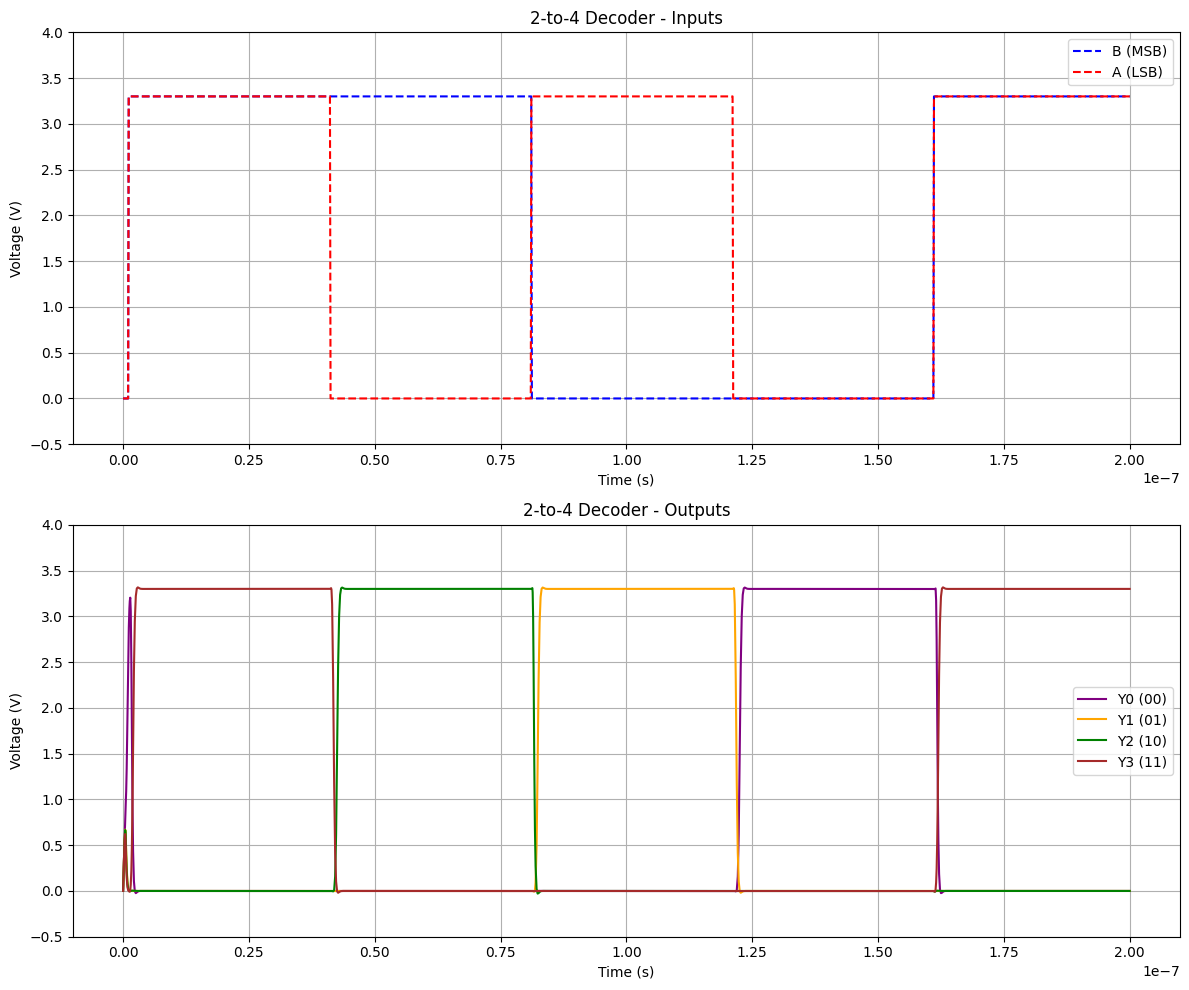

Average propagation delay: 2.47e-08 seconds
Maximum propagation delay: 8.16e-08 seconds
Minimum propagation delay: 6.37e-10 seconds
.title 2-to-4 Decoder
Vdd vdd 0 DC 0V PULSE(0V 3.3V 0ns 0.5ns 0.5ns 400ns 400ns)
RRvdd vdd vdd_internal 1Ohm
CCvdd vdd_internal 0 1pF
VinA A 0 DC 0V PULSE(0V 3.3V 1ns 0.1ns 0.1ns 40ns 80ns)
VinB B 0 DC 0V PULSE(0V 3.3V 1ns 0.1ns 0.1ns 80ns 160ns)
RRin_A A A_int 100Ohm
CCin_A A_int 0 0.1pF
RRin_B B B_int 100Ohm
CCin_B B_int 0 0.1pF
MM1 A_inv A_int vdd_internal vdd_internal PMOS
MM2 A_inv A_int 0 0 NMOS
CC1 A_inv 0 0.1pF
MM3 B_inv B_int vdd_internal vdd_internal PMOS
MM4 B_inv B_int 0 0 NMOS
CC2 B_inv 0 0.1pF
MM5 Y0_int B_inv vdd_internal vdd_internal PMOS
MM6 Y0_int A_inv vdd_internal vdd_internal PMOS
MM7 Y0_int B_inv Y0_n 0 NMOS
MM8 Y0_n A_inv 0 0 NMOS
CC3 Y0_int 0 0.1pF
MM9 Y0 Y0_int vdd_internal vdd_internal PMOS
MM10 Y0 Y0_int 0 0 NMOS
CC4 Y0 0 0.1pF
MM11 Y1_int B_inv vdd_internal vdd_internal PMOS
MM12 Y1_int A_int vdd_internal vdd_internal PMOS
MM13 

In [20]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the 2-to-4 Decoder circuit
circuit = Circuit('2-to-4 Decoder')

# Define power supply with ramp-up
circuit.PulseVoltageSource('dd', 'vdd', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,  # Using 3.3V for better stability
    delay_time=0@u_ns,
    rise_time=0.5@u_ns,
    fall_time=0.5@u_ns,
    pulse_width=400@u_ns,
    period=400@u_ns
)

# Add supply resistor and decoupling capacitor
circuit.R('Rvdd', 'vdd', 'vdd_internal', 1@u_Ω)
circuit.C('Cvdd', 'vdd_internal', circuit.gnd, 1@u_pF)

# Define input voltage sources with delayed start
# Input A (LSB)
circuit.PulseVoltageSource('inA', 'A', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=1@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=40@u_ns,
    period=80@u_ns
)

# Input B (MSB)
circuit.PulseVoltageSource('inB', 'B', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=1@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=80@u_ns,
    period=160@u_ns
)

# Add input protection and parasitic capacitance
for node in ['A', 'B']:
    circuit.R(f'Rin_{node}', node, f'{node}_int', 100@u_Ω)
    circuit.C(f'Cin_{node}', f'{node}_int', circuit.gnd, 0.1@u_pF)

# Inverters for input signals
# Inverter for A
circuit.MOSFET('M1', 'A_inv', 'A_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M2', 'A_inv', 'A_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C1', 'A_inv', circuit.gnd, 0.1@u_pF)

# Inverter for B
circuit.MOSFET('M3', 'B_inv', 'B_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M4', 'B_inv', 'B_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C2', 'B_inv', circuit.gnd, 0.1@u_pF)

# Output 0 decoder (B'A')
circuit.MOSFET('M5', 'Y0_int', 'B_inv', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M6', 'Y0_int', 'A_inv', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M7', 'Y0_int', 'B_inv', 'Y0_n', circuit.gnd, model='NMOS')
circuit.MOSFET('M8', 'Y0_n', 'A_inv', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C3', 'Y0_int', circuit.gnd, 0.1@u_pF)

# Output buffer for Y0
circuit.MOSFET('M9', 'Y0', 'Y0_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M10', 'Y0', 'Y0_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C4', 'Y0', circuit.gnd, 0.1@u_pF)

# Output 1 decoder (B'A)
circuit.MOSFET('M11', 'Y1_int', 'B_inv', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M12', 'Y1_int', 'A_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M13', 'Y1_int', 'B_inv', 'Y1_n', circuit.gnd, model='NMOS')
circuit.MOSFET('M14', 'Y1_n', 'A_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C5', 'Y1_int', circuit.gnd, 0.1@u_pF)

# Output buffer for Y1
circuit.MOSFET('M15', 'Y1', 'Y1_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M16', 'Y1', 'Y1_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C6', 'Y1', circuit.gnd, 0.1@u_pF)

# Output 2 decoder (BA')
circuit.MOSFET('M17', 'Y2_int', 'B_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M18', 'Y2_int', 'A_inv', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M19', 'Y2_int', 'B_int', 'Y2_n', circuit.gnd, model='NMOS')
circuit.MOSFET('M20', 'Y2_n', 'A_inv', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C7', 'Y2_int', circuit.gnd, 0.1@u_pF)

# Output buffer for Y2
circuit.MOSFET('M21', 'Y2', 'Y2_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M22', 'Y2', 'Y2_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C8', 'Y2', circuit.gnd, 0.1@u_pF)

# Output 3 decoder (BA)
circuit.MOSFET('M23', 'Y3_int', 'B_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M24', 'Y3_int', 'A_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M25', 'Y3_int', 'B_int', 'Y3_n', circuit.gnd, model='NMOS')
circuit.MOSFET('M26', 'Y3_n', 'A_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C9', 'Y3_int', circuit.gnd, 0.1@u_pF)

# Output buffer for Y3
circuit.MOSFET('M27', 'Y3', 'Y3_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M28', 'Y3', 'Y3_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('C10', 'Y3', circuit.gnd, 0.1@u_pF)

# Define MOSFET models with more realistic parameters
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=2e-6,
    l=0.35e-6
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=40e-6,
    vto=-0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=6e-6,
    l=0.35e-6
)

# Create simulator with modified parameters
simulator = circuit.simulator(temperature=27, nominal_temperature=27)

# Add simulation options for better convergence
simulator.options(
    reltol=1e-3,
    abstol=1e-6,
    vntol=1e-4,
    chgtol=1e-14,
    trtol=7,
    itl1=100,
    itl2=50,
    itl4=50,
    method='gear'
)

try:
    # Run transient analysis
    analysis = simulator.transient(
        step_time=0.1@u_ns,
        end_time=200@u_ns,
        start_time=0@u_ns,
        max_time=0.2@u_ns,
        use_initial_condition=True
    )

    # Convert time and voltage data to numpy arrays
    time = np.array([float(t) for t in analysis.time])
    va = np.array([float(v) for v in analysis['A']])
    vb = np.array([float(v) for v in analysis['B']])
    vy0 = np.array([float(v) for v in analysis['Y0']])
    vy1 = np.array([float(v) for v in analysis['Y1']])
    vy2 = np.array([float(v) for v in analysis['Y2']])
    vy3 = np.array([float(v) for v in analysis['Y3']])

    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot inputs
    ax1.plot(time, vb, label='B (MSB)', linestyle='--', color='blue')
    ax1.plot(time, va, label='A (LSB)', linestyle='--', color='red')
    ax1.grid(True)
    ax1.set_title('2-to-4 Decoder - Inputs')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 4)

    # Plot outputs
    ax2.plot(time, vy0, label='Y0 (00)', color='purple')
    ax2.plot(time, vy1, label='Y1 (01)', color='orange')
    ax2.plot(time, vy2, label='Y2 (10)', color='green')
    ax2.plot(time, vy3, label='Y3 (11)', color='brown')
    ax2.grid(True)
    ax2.set_title('2-to-4 Decoder - Outputs')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 4)

    plt.tight_layout()
    plt.show()

    # Analyze decoder characteristics
    def analyze_decoder(time, va, vb, vy0, vy1, vy2, vy3, vth=1.65):
        """Verify decoder functionality and calculate delays"""
        def to_binary(v):
            return 1 if v > vth else 0
        
        def find_transitions(time, signal):
            binary = [to_binary(v) for v in signal]
            transitions = []
            for i in range(1, len(binary)):
                if binary[i] != binary[i-1]:
                    transitions.append(i)
            return transitions
        
        # Calculate propagation delays
        a_trans = find_transitions(time, va)
        output_delays = []
        
        for t_in in a_trans:
            for signal in [vy0, vy1, vy2, vy3]:
                out_trans = find_transitions(time, signal)
                for t_out in out_trans:
                    if t_out > t_in:
                        delay = time[t_out] - time[t_in]
                        output_delays.append(delay)
                        break
        
        if output_delays:
            print(f"Average propagation delay: {np.mean(output_delays):.2e} seconds")
            print(f"Maximum propagation delay: {np.max(output_delays):.2e} seconds")
            print(f"Minimum propagation delay: {np.min(output_delays):.2e} seconds")

    analyze_decoder(time, va, vb, vy0, vy1, vy2, vy3)

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

print(circuit)

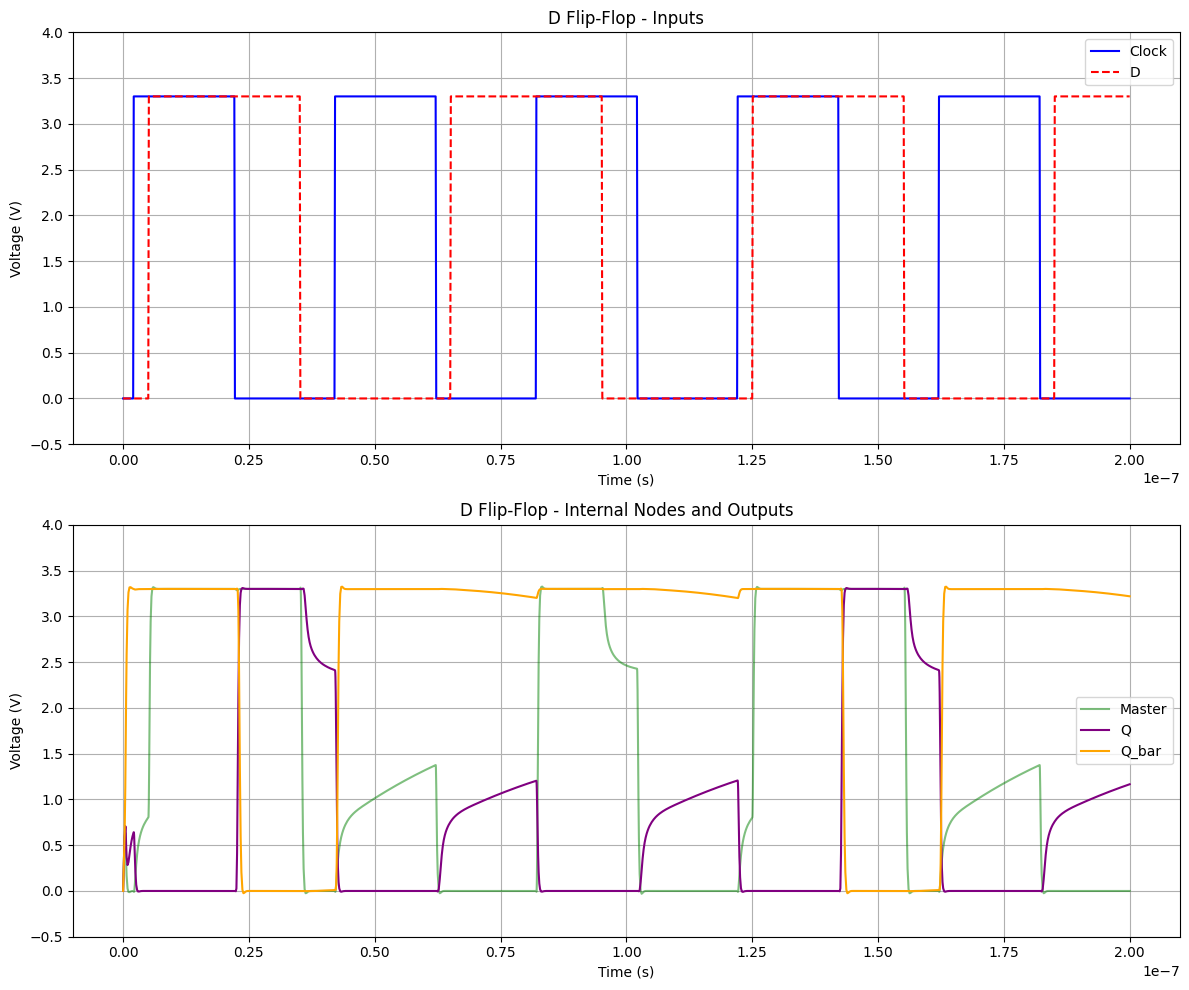

Average hold time: 3.01e-09 seconds
.title D Flip-Flop
Vdd vdd 0 DC 0V PULSE(0V 3.3V 0ns 0.5ns 0.5ns 250ns 250ns)
RRvdd vdd vdd_internal 1Ohm
CCvdd vdd_internal 0 1pF
Vclk clock 0 DC 0V PULSE(0V 3.3V 2ns 0.1ns 0.1ns 20ns 40ns)
Vdin D 0 DC 0V PULSE(0V 3.3V 5ns 0.1ns 0.1ns 30ns 60ns)
RRin_clock clock clock_int 100Ohm
CCin_clock clock_int 0 0.1pF
RRin_D D D_int 100Ohm
CCin_D D_int 0 0.1pF
MM1 clock_inv clock_int vdd_internal vdd_internal PMOS
MM2 clock_inv clock_int 0 0 NMOS
CCclk_inv clock_inv 0 0.1pF
MM3 D_inv D_int vdd_internal vdd_internal PMOS
MM4 D_inv D_int 0 0 NMOS
CCD_inv D_inv 0 0.1pF
MM5 master_int D_int vdd_internal vdd_internal PMOS
MM6 master_int clock_int 0 0 NMOS
MM7 master_out master_int vdd_internal vdd_internal PMOS
MM8 master_out master_int 0 0 NMOS
CCmaster master_out 0 0.1pF
MM9 slave_int master_out vdd_internal vdd_internal PMOS
MM10 slave_int clock_inv 0 0 NMOS
MM11 Q slave_int vdd_internal vdd_internal PMOS
MM12 Q slave_int 0 0 NMOS
CCQ Q 0 0.1pF
MM13 Q_bar Q vdd_

In [21]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the D Flip-Flop circuit
circuit = Circuit('D Flip-Flop')

# Define power supply with ramp-up
circuit.PulseVoltageSource('dd', 'vdd', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,  # Using 3.3V for better stability
    delay_time=0@u_ns,
    rise_time=0.5@u_ns,
    fall_time=0.5@u_ns,
    pulse_width=250@u_ns,
    period=250@u_ns
)

# Add supply resistor and decoupling capacitor
circuit.R('Rvdd', 'vdd', 'vdd_internal', 1@u_Ω)
circuit.C('Cvdd', 'vdd_internal', circuit.gnd, 1@u_pF)

# Define input voltage sources with delayed start
# Clock signal
circuit.PulseVoltageSource('clk', 'clock', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=2@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=20@u_ns,
    period=40@u_ns
)

# Data input
circuit.PulseVoltageSource('din', 'D', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=5@u_ns,
    rise_time=0.1@u_ns,
    fall_time=0.1@u_ns,
    pulse_width=30@u_ns,
    period=60@u_ns
)

# Add input protection and parasitic capacitance
for node in ['clock', 'D']:
    circuit.R(f'Rin_{node}', node, f'{node}_int', 100@u_Ω)
    circuit.C(f'Cin_{node}', f'{node}_int', circuit.gnd, 0.1@u_pF)

# Create clock inverter
circuit.MOSFET('M1', 'clock_inv', 'clock_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M2', 'clock_inv', 'clock_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('Cclk_inv', 'clock_inv', circuit.gnd, 0.1@u_pF)

# Master stage
# Input inverter
circuit.MOSFET('M3', 'D_inv', 'D_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M4', 'D_inv', 'D_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('CD_inv', 'D_inv', circuit.gnd, 0.1@u_pF)

# Master latch
circuit.MOSFET('M5', 'master_int', 'D_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M6', 'master_int', 'clock_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.MOSFET('M7', 'master_out', 'master_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M8', 'master_out', 'master_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('Cmaster', 'master_out', circuit.gnd, 0.1@u_pF)

# Slave stage
circuit.MOSFET('M9', 'slave_int', 'master_out', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M10', 'slave_int', 'clock_inv', circuit.gnd, circuit.gnd, model='NMOS')
circuit.MOSFET('M11', 'Q', 'slave_int', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M12', 'Q', 'slave_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('CQ', 'Q', circuit.gnd, 0.1@u_pF)

# Output inverter for Q_bar
circuit.MOSFET('M13', 'Q_bar', 'Q', 'vdd_internal', 'vdd_internal', model='PMOS')
circuit.MOSFET('M14', 'Q_bar', 'Q', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('CQbar', 'Q_bar', circuit.gnd, 0.1@u_pF)

# Add weak pull-up/pull-down for initialization
circuit.R('Rpd_master', 'master_int', circuit.gnd, 1@u_MΩ)
circuit.R('Rpd_slave', 'slave_int', circuit.gnd, 1@u_MΩ)

# Define MOSFET models with more realistic parameters
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=2e-6,
    l=0.35e-6
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=40e-6,
    vto=-0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=6e-6,
    l=0.35e-6
)

# Create simulator with modified parameters
simulator = circuit.simulator(temperature=27, nominal_temperature=27)

# Add simulation options for better convergence
simulator.options(
    reltol=1e-3,
    abstol=1e-6,
    vntol=1e-4,
    chgtol=1e-14,
    trtol=7,
    itl1=100,
    itl2=50,
    itl4=50,
    method='gear'
)

try:
    # Run transient analysis
    analysis = simulator.transient(
        step_time=0.1@u_ns,
        end_time=200@u_ns,
        start_time=0@u_ns,
        max_time=0.2@u_ns,
        use_initial_condition=True
    )

    # Convert time and voltage data to numpy arrays
    time = np.array([float(t) for t in analysis.time])
    vclk = np.array([float(v) for v in analysis['clock']])
    vd = np.array([float(v) for v in analysis['D']])
    vq = np.array([float(v) for v in analysis['Q']])
    vqbar = np.array([float(v) for v in analysis['Q_bar']])
    vmaster = np.array([float(v) for v in analysis['master_out']])

    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot inputs
    ax1.plot(time, vclk, label='Clock', color='blue')
    ax1.plot(time, vd, label='D', linestyle='--', color='red')
    ax1.grid(True)
    ax1.set_title('D Flip-Flop - Inputs')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 4)

    # Plot outputs and internal nodes
    ax2.plot(time, vmaster, label='Master', color='green', alpha=0.5)
    ax2.plot(time, vq, label='Q', color='purple')
    ax2.plot(time, vqbar, label='Q_bar', color='orange')
    ax2.grid(True)
    ax2.set_title('D Flip-Flop - Internal Nodes and Outputs')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 4)

    plt.tight_layout()
    plt.show()

    # Analyze timing characteristics
    def analyze_timing(time, vclk, vd, vq, vth=1.65):
        """Calculate setup time, hold time, and clock-to-Q delay"""
        def find_edges(time, signal, rising=True):
            edges = []
            for i in range(1, len(signal)):
                if rising and signal[i-1] < vth < signal[i]:
                    edges.append(i)
                elif not rising and signal[i-1] > vth > signal[i]:
                    edges.append(i)
            return edges

        # Find edges
        clk_edges = find_edges(time, vclk, rising=True)
        d_edges = find_edges(time, vd)
        q_edges = find_edges(time, vq)

        # Calculate delays
        clk_q_delays = []
        setup_times = []
        hold_times = []

        for clk_edge in clk_edges:
            # Clock-to-Q delay
            for q_edge in q_edges:
                if q_edge > clk_edge:
                    delay = time[q_edge] - time[clk_edge]
                    if delay < 10e-9:  # Reasonable delay window
                        clk_q_delays.append(delay)
                    break

            # Setup and hold times
            for d_edge in d_edges:
                if abs(time[d_edge] - time[clk_edge]) < 10e-9:
                    if d_edge < clk_edge:
                        setup_times.append(time[clk_edge] - time[d_edge])
                    else:
                        hold_times.append(time[d_edge] - time[clk_edge])

        if clk_q_delays:
            print(f"Average Clock-to-Q delay: {np.mean(clk_q_delays):.2e} seconds")
        if setup_times:
            print(f"Average setup time: {np.mean(setup_times):.2e} seconds")
        if hold_times:
            print(f"Average hold time: {np.mean(hold_times):.2e} seconds")

    analyze_timing(time, vclk, vd, vq)

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

print(circuit)

VCO Characteristics:
Frequency Range: 137.36 MHz to 671.00 MHz
Average Kvco: 162.68 MHz/V


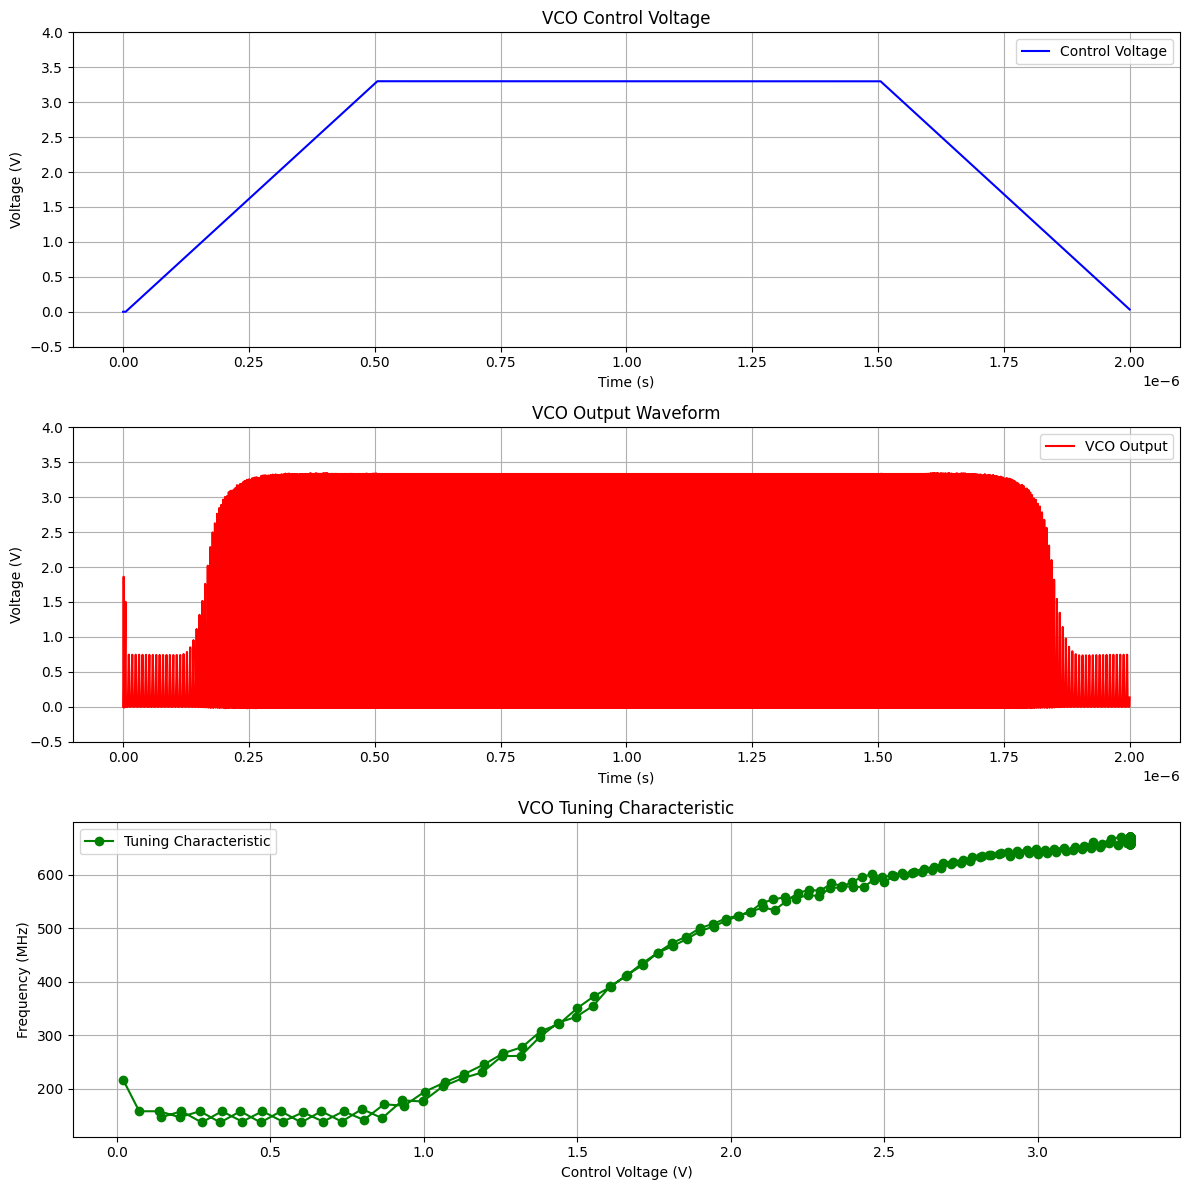

.title Voltage Controlled Oscillator
Vdd vdd 0 DC 0V PULSE(0V 3.3V 0ns 1ns 1ns 2500ns 2500ns)
RRvdd vdd vdd_internal 1Ohm
CCvdd vdd_internal 0 1pF
Vctrl v_control 0 DC 0V PULSE(0V 3.3V 5ns 500ns 500ns 1000ns 2000ns)
RRctrl v_control v_control_int 100Ohm
CCctrl v_control_int 0 0.1pF
MM1 bias bias 0 0 NMOS
RRbias vdd_internal bias 10kOhm
CCbias bias 0 0.1pF
MM2 i_ctrl v_control_int 0 0 NMOS
MM3 i_ctrl bias 0 0 NMOS
CCi_ctrl i_ctrl 0 0.1pF
MMp1 stage1 stage3 vdd_internal vdd_internal PMOS
MMn1 stage1 stage3 i_ctrl 0 NMOS
CC1 stage1 0 0.1pF
RRpu1 stage1 vdd_internal 1MegOhm
MMp2 stage2 stage1 vdd_internal vdd_internal PMOS
MMn2 stage2 stage1 i_ctrl 0 NMOS
CC2 stage2 0 0.1pF
RRpu2 stage2 vdd_internal 1MegOhm
MMp3 stage3 stage2 vdd_internal vdd_internal PMOS
MMn3 stage3 stage2 i_ctrl 0 NMOS
CC3 stage3 0 0.1pF
RRpu3 stage3 vdd_internal 1MegOhm
MM10 vco_out stage3 vdd_internal vdd_internal PMOS_BUF
MM11 vco_out stage3 0 0 NMOS_BUF
CCout vco_out 0 0.1pF
.model NMOS nmos (cbd=1e-13 cbs=1e-13 cgd

In [22]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the VCO circuit
circuit = Circuit('Voltage Controlled Oscillator')

# Define power supply with ramp-up
circuit.PulseVoltageSource('dd', 'vdd', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,  # Using 3.3V for better stability
    delay_time=0@u_ns,
    rise_time=1@u_ns,
    fall_time=1@u_ns,
    pulse_width=2500@u_ns,
    period=2500@u_ns
)

# Add supply resistor and decoupling capacitor
circuit.R('Rvdd', 'vdd', 'vdd_internal', 1@u_Ω)
circuit.C('Cvdd', 'vdd_internal', circuit.gnd, 1@u_pF)

# Control voltage source (sweep from 0V to 3.3V)
circuit.PulseVoltageSource('ctrl', 'v_control', circuit.gnd,
    initial_value=0@u_V,
    pulsed_value=3.3@u_V,
    delay_time=5@u_ns,
    rise_time=500@u_ns,
    fall_time=500@u_ns,
    pulse_width=1000@u_ns,
    period=2000@u_ns
)

# Add control voltage protection and filtering
circuit.R('Rctrl', 'v_control', 'v_control_int', 100@u_Ω)
circuit.C('Cctrl', 'v_control_int', circuit.gnd, 0.1@u_pF)

# Current mirror bias circuit
circuit.MOSFET('M1', 'bias', 'bias', circuit.gnd, circuit.gnd, model='NMOS')
circuit.R('Rbias', 'vdd_internal', 'bias', 10@u_kΩ)
circuit.C('Cbias', 'bias', circuit.gnd, 0.1@u_pF)

# Voltage-controlled current source
circuit.MOSFET('M2', 'i_ctrl', 'v_control_int', circuit.gnd, circuit.gnd, model='NMOS')
circuit.MOSFET('M3', 'i_ctrl', 'bias', circuit.gnd, circuit.gnd, model='NMOS')
circuit.C('Ci_ctrl', 'i_ctrl', circuit.gnd, 0.1@u_pF)

# Ring oscillator stages with parasitic capacitance
for i in range(1, 4):
    prev_stage = f'stage{3 if i == 1 else i-1}'
    curr_stage = f'stage{i}'
    
    # PMOS
    circuit.MOSFET(f'Mp{i}', curr_stage, prev_stage, 'vdd_internal', 'vdd_internal', model='PMOS')
    # NMOS
    circuit.MOSFET(f'Mn{i}', curr_stage, prev_stage, 'i_ctrl', circuit.gnd, model='NMOS')
    # Load capacitance
    circuit.C(f'C{i}', curr_stage, circuit.gnd, 0.1@u_pF)
    # Weak pull-up for initialization
    circuit.R(f'Rpu{i}', curr_stage, 'vdd_internal', 1@u_MΩ)

# Output buffer
circuit.MOSFET('M10', 'vco_out', 'stage3', 'vdd_internal', 'vdd_internal', model='PMOS_BUF')
circuit.MOSFET('M11', 'vco_out', 'stage3', circuit.gnd, circuit.gnd, model='NMOS_BUF')
circuit.C('Cout', 'vco_out', circuit.gnd, 0.1@u_pF)

# Define MOSFET models with more realistic parameters
circuit.model('NMOS', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=4e-6,
    l=0.35e-6
)

circuit.model('PMOS', 'pmos',
    level=1,
    kp=40e-6,
    vto=-0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=12e-6,
    l=0.35e-6
)

# Buffer transistors (larger size for driving output load)
circuit.model('NMOS_BUF', 'nmos',
    level=1,
    kp=120e-6,
    vto=0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=8e-6,
    l=0.35e-6
)

circuit.model('PMOS_BUF', 'pmos',
    level=1,
    kp=40e-6,
    vto=-0.7,
    lambda_=0.01,
    gamma=0.4,
    phi=0.65,
    cgso=0.6e-9,
    cgdo=0.6e-9,
    cbd=0.1e-12,
    cbs=0.1e-12,
    w=24e-6,
    l=0.35e-6
)

# Create simulator with modified parameters
simulator = circuit.simulator(temperature=27, nominal_temperature=27)

# Add simulation options for better convergence
simulator.options(
    reltol=1e-3,
    abstol=1e-6,
    vntol=1e-4,
    chgtol=1e-14,
    trtol=7,
    itl1=100,
    itl2=50,
    itl4=50,
    method='gear'
)

try:
    # Run transient analysis
    analysis = simulator.transient(
        step_time=0.1@u_ns,
        end_time=2000@u_ns,
        start_time=0@u_ns,
        max_time=0.2@u_ns,
        use_initial_condition=True
    )

    # Convert time and voltage data to numpy arrays
    time = np.array([float(t) for t in analysis.time])
    vctrl = np.array([float(v) for v in analysis['v_control']])
    vout = np.array([float(v) for v in analysis['vco_out']])

    # Create figure with multiple subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

    # Plot control voltage
    ax1.plot(time, vctrl, label='Control Voltage', color='blue')
    ax1.grid(True)
    ax1.set_title('VCO Control Voltage')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend()
    ax1.set_ylim(-0.5, 4)

    # Plot output waveform
    ax2.plot(time, vout, label='VCO Output', color='red')
    ax2.grid(True)
    ax2.set_title('VCO Output Waveform')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Voltage (V)')
    ax2.legend()
    ax2.set_ylim(-0.5, 4)

    # Calculate and plot instantaneous frequency
    def calculate_frequency(time, signal, window_size=100):
        frequencies = []
        times = []
        control_voltages = []
        
        for i in range(0, len(time)-window_size, window_size//2):
            window = signal[i:i+window_size]
            t_window = time[i:i+window_size]
            
            # Count zero crossings
            crossings = np.where(np.diff(window > np.mean(window)))[0]
            if len(crossings) >= 2:
                period = 2 * np.mean(np.diff(t_window[crossings]))
                freq = 1.0 / period if period > 0 else 0
                frequencies.append(freq)
                times.append(np.mean(t_window))
                control_voltages.append(np.mean(vctrl[i:i+window_size]))
        
        return np.array(times), np.array(frequencies), np.array(control_voltages)

    # Calculate frequencies and plot
    t_freq, freqs, v_ctrl = calculate_frequency(time, vout)
    
    if len(t_freq) > 0:
        # Plot frequency vs control voltage
        ax3.plot(v_ctrl, freqs/1e6, 'o-', label='Tuning Characteristic', color='green')
        ax3.grid(True)
        ax3.set_title('VCO Tuning Characteristic')
        ax3.set_xlabel('Control Voltage (V)')
        ax3.set_ylabel('Frequency (MHz)')
        ax3.legend()

        # Print VCO characteristics
        if len(freqs) > 1:
            freq_range = np.ptp(freqs)
            voltage_range = np.ptp(v_ctrl)
            kvco = freq_range / voltage_range if voltage_range > 0 else 0
            print(f"VCO Characteristics:")
            print(f"Frequency Range: {np.min(freqs)/1e6:.2f} MHz to {np.max(freqs)/1e6:.2f} MHz")
            print(f"Average Kvco: {kvco/1e6:.2f} MHz/V")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

print(circuit)

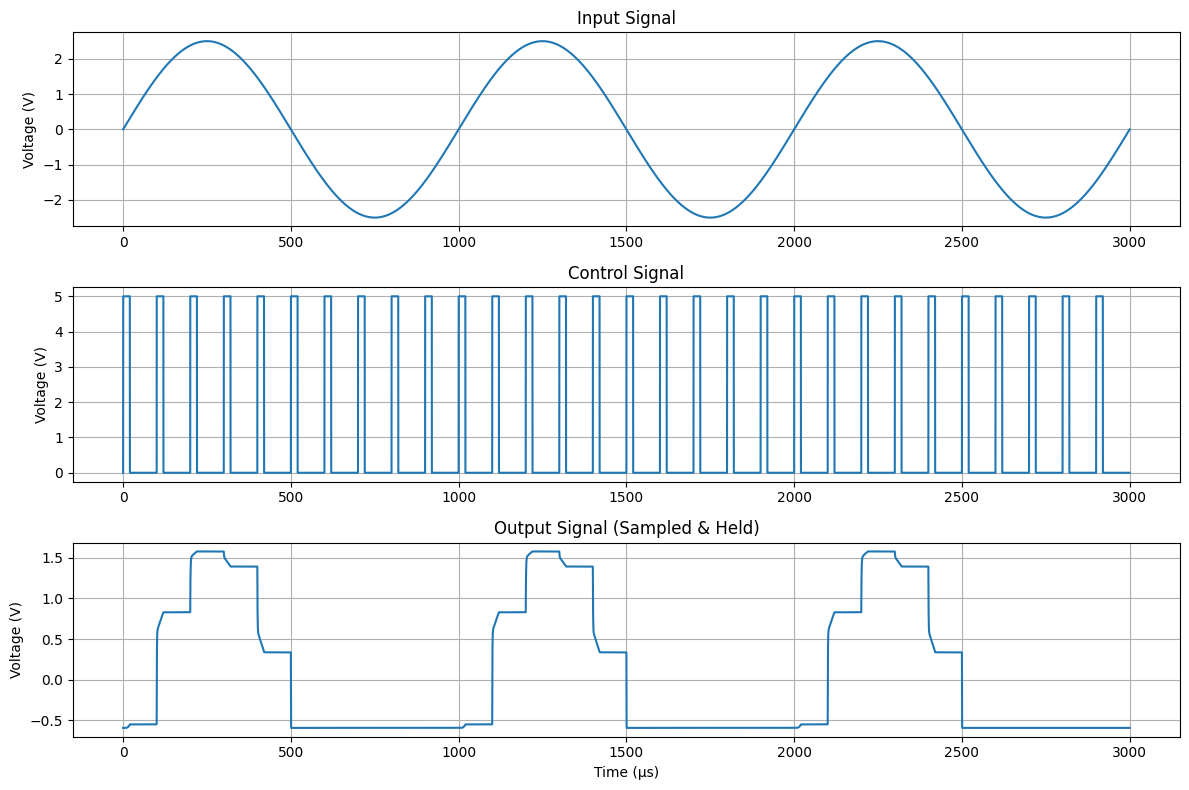

Simulation completed successfully!
Input signal frequency: 1 kHz
Sampling frequency: 10 kHz
Hold capacitor: 10 nF


In [59]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the circuit
circuit = Circuit('Sample and Hold Circuit')

# Define power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)  # 5V power supply

# Define input signal (sinusoidal)
circuit.SinusoidalVoltageSource('input', 'Vin', circuit.gnd, 
                               amplitude=2.5@u_V,  # 2.5V amplitude
                               frequency=1@u_kHz)  # 1kHz frequency

# Define control signal (pulse for sampling)
circuit.PulseVoltageSource('control', 'Ctrl', circuit.gnd,
                          initial_value=0@u_V,      # Start at 0V
                          pulsed_value=5@u_V,       # Pulse to 5V
                          pulse_width=20@u_us,      # 20μs pulse width
                          period=100@u_us,          # 100μs period (10kHz)
                          rise_time=1@u_ns,         # Fast rise
                          fall_time=1@u_ns)         # Fast fall

# Define MOSFET as switch (NMOS)
circuit.MOSFET('M1', 'node1', 'Ctrl', 'Vin', circuit.gnd, model='NMOS')

# Define hold capacitor with initial condition
circuit.C('hold', 'node1', circuit.gnd, 10@u_nF, ic=0@u_V)  # 10nF capacitor with 0V initial condition

# Define buffer (source follower) to prevent loading of capacitor
circuit.MOSFET('M2', 'Vdd', 'node1', 'Vout', circuit.gnd, model='NMOS')
circuit.I('bias', 'Vout', circuit.gnd, 100@u_uA)  # 100μA current source bias

# MOSFET models
circuit.model('NMOS', 'nmos', 
              level=1,
              kp=120e-6,    # Transconductance parameter
              vto=0.7,      # Threshold voltage
              lambda_=0.02, # Channel-length modulation
              w=50e-6,      # Width
              l=1e-6)       # Length

# Setup simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Perform transient analysis
analysis = simulator.transient(
    step_time=0.1@u_us,    # 100ns step time
    end_time=3000@u_us,     # 500μs simulation time
)

# Plot results
plt.figure(figsize=(12, 8))

# Plot input signal
plt.subplot(3, 1, 1)
plt.plot(analysis.time*1e6, analysis['Vin'])  # Time in μs
plt.title('Input Signal')
plt.ylabel('Voltage (V)')
plt.grid(True)

# Plot control signal
plt.subplot(3, 1, 2)
plt.plot(analysis.time*1e6, analysis['Ctrl'])  # Time in μs
plt.title('Control Signal')
plt.ylabel('Voltage (V)')
plt.grid(True)

# Plot output signal
plt.subplot(3, 1, 3)
plt.plot(analysis.time*1e6, analysis['Vout'])  # Time in μs
plt.title('Output Signal (Sampled & Held)')
plt.xlabel('Time (μs)')
plt.ylabel('Voltage (V)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Print some key measurements
print("Simulation completed successfully!")
print(f"Input signal frequency: 1 kHz")
print(f"Sampling frequency: 10 kHz")
print(f"Hold capacitor: 10 nF")

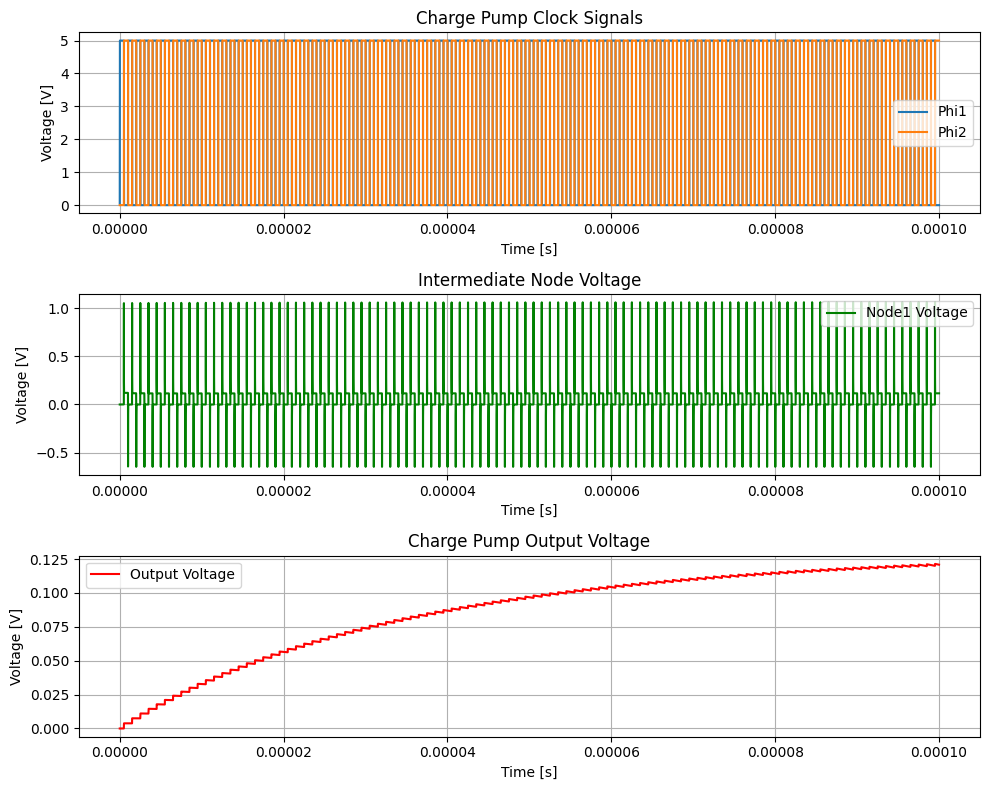

Final output voltage: 0.1208154693045284 V


In [17]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the circuit
circuit = Circuit('Basic Charge Pump')

# Define power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)

# Define clock signals (non-overlapping clocks for charge pump operation)
circuit.PulseVoltageSource('clk1', 'phi1', circuit.gnd, 
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=500@u_ns, period=1@u_us,
                          rise_time=10@u_ns, fall_time=10@u_ns)
circuit.PulseVoltageSource('clk2', 'phi2', circuit.gnd, 
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=500@u_ns, period=1@u_us,
                          rise_time=10@u_ns, fall_time=10@u_ns,
                          delay_time=500@u_ns)  # Phase shifted

# Define MOSFET models
circuit.model('NMOS', 'nmos', 
              level=1,
              kp=120e-6,
              vto=0.7,
              lambda_=0.02,
              w=10e-6,
              l=1e-6)
circuit.model('PMOS', 'pmos', 
              level=1,
              kp=60e-6,
              vto=-0.7,
              lambda_=0.02,
              w=20e-6,
              l=1e-6)

# Charge pump components - corrected architecture
# First stage
circuit.MOSFET('M1', 'node1', 'phi1', circuit.gnd, circuit.gnd, model='NMOS')  # Switching NMOS
circuit.C('C1', 'node1', 'phi2', 10@u_pF)  # Pumping capacitor connected to phi2

# Second stage (diode-connected MOSFET for charge transfer)
circuit.MOSFET('M2', 'Vout', 'node1', 'node1', circuit.gnd, model='NMOS')  # Diode-connected transfer MOSFET
circuit.C('C2', 'Vout', circuit.gnd, 100@u_pF)  # Output storage capacitor

# Output load
circuit.R('load', 'Vout', circuit.gnd, 1@u_MΩ)

# Setup simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options(reltol=1e-4, abstol=1e-9, vntol=1e-6)

# Perform transient analysis
try:
    analysis = simulator.transient(
        step_time=10@u_ns, 
        end_time=100@u_us,  # Increased to see the pump effect
        use_initial_condition=True
    )
except Exception as e:
    print(f"Simulation error: {e}")
    # Retry with adjusted parameters if needed
    analysis = simulator.transient(
        step_time=100@u_ns, 
        end_time=20@u_us
    )

# Plot results
plt.figure(figsize=(10, 8))

# Plot clock signals
plt.subplot(3, 1, 1)
plt.plot(analysis.time, analysis['phi1'], label='Phi1')
plt.plot(analysis.time, analysis['phi2'], label='Phi2')
plt.title('Charge Pump Clock Signals')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True)

# Plot intermediate node voltage
plt.subplot(3, 1, 2)
plt.plot(analysis.time, analysis['node1'], label='Node1 Voltage', color='green')
plt.title('Intermediate Node Voltage')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True)

# Plot output voltage
plt.subplot(3, 1, 3)
plt.plot(analysis.time, analysis['Vout'], label='Output Voltage', color='red')
plt.title('Charge Pump Output Voltage')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final output voltage
final_voltage = analysis['Vout'][-1]
print(f"Final output voltage: {final_voltage}")

Circuit netlist:
.title Stable Operational Transconductance Amplifier (OTA)
Vdd Vdd 0 5V
Vss Vss 0 -5V
Ibias Vdd bias_node 50uA
Vin_p in_p 0 DC 0V AC 1V SIN(0V 0.01V 1kHz 0s 0Hz)
Vin_n in_n 0 0V
M1 drain1 in_p tail 0 NMOS l=1e-06 w=5e-05
M2 drain2 in_n tail 0 NMOS l=1e-06 w=5e-05
M3 tail bias_node Vss Vss NMOS l=1e-06 w=2e-05
M4 bias_node bias_node Vss Vss NMOS l=1e-06 w=2e-05
M5 drain1 drain1 Vdd Vdd PMOS l=1e-06 w=0.0001
M6 drain2 drain1 Vdd Vdd PMOS l=1e-06 w=0.0001
M7 output drain2 Vss Vss NMOS l=1e-06 w=5e-05
M8 output bias_node Vdd Vdd PMOS l=1e-06 w=0.0001
Ccomp drain2 output 2pF
Rcomp_res drain2 comp_node 1kOhm
Ccomp2 comp_node output 2pF
Cload output 0 10pF
Rseries output out_node 100Ohm
Cload2 out_node 0 10pF
.model NMOS nmos (gamma=0.5 kp=0.00012 lambda=0.02 level=1 phi=0.7 vto=0.7)
.model PMOS pmos (gamma=0.5 kp=4e-05 lambda=0.02 level=1 phi=0.7 vto=-0.7)


Operating Point Analysis:
out_node: -1.543760 V
comp_node: 4.271667 V
output: -1.543760 V
drain2: 4.271667 V
tail: -0.

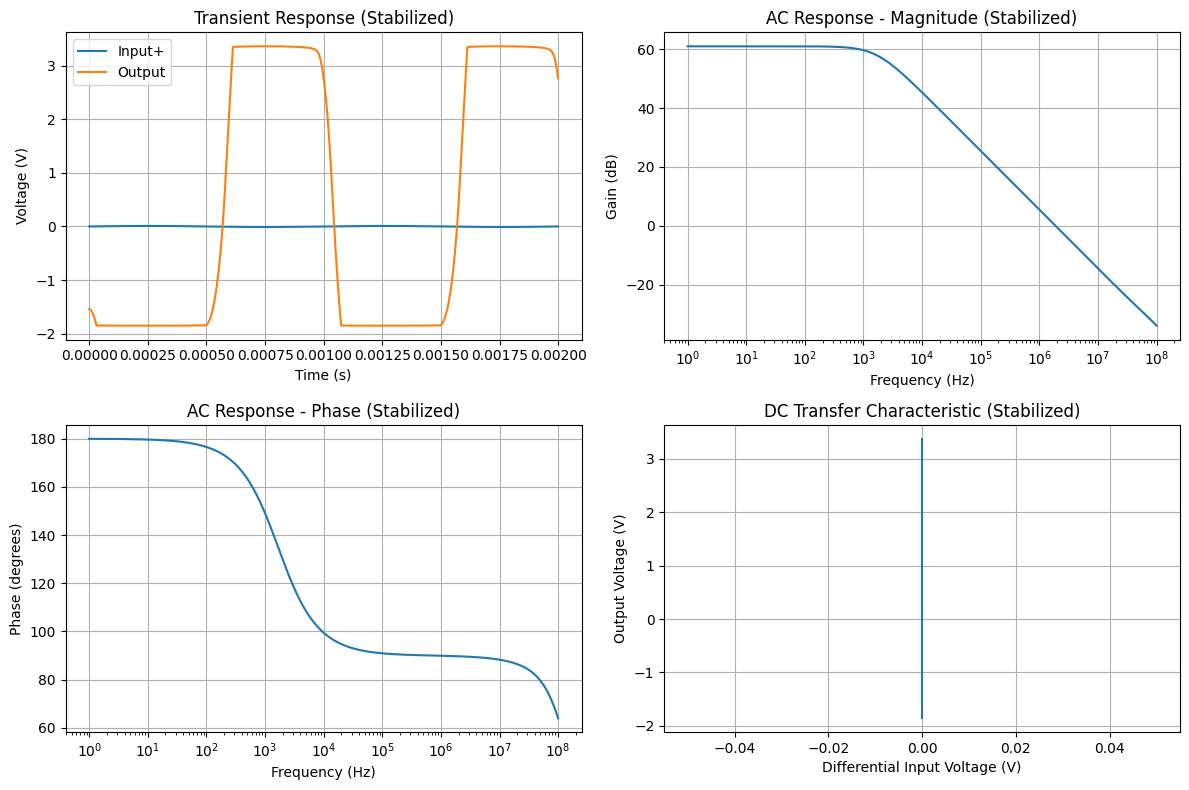


Performance Metrics:
DC Gain: 1123.22 (61.01 dB)
Unity Gain Frequency: 1.88e+06 Hz
Phase Margin: 269.73°
Phase margin is sufficient for stability (>45°)
Output DC voltage: -1.544 V
Approximate power consumption: 1000.00 μW
Estimated output swing: 8.0 V
Output standard deviation: 2.4602 V


In [39]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the circuit
circuit = Circuit('Operational Transconductance Amplifier (OTA)')

# Define power supplies
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)  # Positive supply
circuit.V('ss', 'Vss', circuit.gnd, -5@u_V)  # Negative supply

# Define bias current source
circuit.I('bias', 'Vdd', 'bias_node', 50@u_uA)  # Bias current

# Define input signals (differential)
circuit.SinusoidalVoltageSource('in_p', 'in_p', circuit.gnd, 
                               dc_offset=0@u_V, amplitude=0.01@u_V, frequency=1@u_kHz)
circuit.V('in_n', 'in_n', circuit.gnd, 0@u_V)  # DC reference

# Define MOSFET models with proper parameters
circuit.model('NMOS', 'nmos', 
              level=1,
              kp=120e-6,
              vto=0.7,
              lambda_=0.02,
              gamma=0.5,
              phi=0.7)

circuit.model('PMOS', 'pmos', 
              level=1,
              kp=40e-6,
              vto=-0.7,
              lambda_=0.02,
              gamma=0.5,
              phi=0.7)

# Differential pair (NMOS transistors)
circuit.MOSFET(1, 'drain1', 'in_p', 'tail', circuit.gnd, model='NMOS', w=50e-6, l=1e-6)
circuit.MOSFET(2, 'drain2', 'in_n', 'tail', circuit.gnd, model='NMOS', w=50e-6, l=1e-6)

# Tail current source (NMOS current mirror)
circuit.MOSFET(3, 'tail', 'bias_node', 'Vss', 'Vss', model='NMOS', w=20e-6, l=1e-6)
circuit.MOSFET(4, 'bias_node', 'bias_node', 'Vss', 'Vss', model='NMOS', w=20e-6, l=1e-6)

# Current mirror load (PMOS transistors)
circuit.MOSFET(5, 'drain1', 'drain1', 'Vdd', 'Vdd', model='PMOS', w=100e-6, l=1e-6)
circuit.MOSFET(6, 'drain2', 'drain1', 'Vdd', 'Vdd', model='PMOS', w=100e-6, l=1e-6)

# Output stage
circuit.MOSFET(7, 'output', 'drain2', 'Vss', 'Vss', model='NMOS', w=50e-6, l=1e-6)
circuit.MOSFET(8, 'output', 'bias_node', 'Vdd', 'Vdd', model='PMOS', w=100e-6, l=1e-6)

# Add compensation for stability
circuit.C('comp', 'drain2', 'output', 2@u_pF)  # Miller compensation capacitor
circuit.R('comp_res', 'drain2', 'comp_node', 1@u_kΩ)  # Compensation resistor
circuit.C('comp2', 'comp_node', 'output', 2@u_pF)  # Second compensation capacitor

# Add a load capacitor
circuit.C('load', 'output', circuit.gnd, 10@u_pF)

# Add a small resistor in series with the load to prevent oscillations
circuit.R('series', 'output', 'out_node', 100@u_Ω)
circuit.C('load2', 'out_node', circuit.gnd, 10@u_pF)

# Setup simulation with more conservative options for stability
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options(
    reltol=1e-6, 
    abstol=1e-12, 
    vntol=1e-6,
    method='gear',  # More stable integration method
    itl1=100,       # Increase DC iteration limit
    itl2=50,        # Increase transient iteration limit
    itl4=20,        # Increase transient timepoint iteration limit
    pivotrel=1e-3,  # Better pivot relative tolerance
    pivottol=1e-6   # Better pivot absolute tolerance
)

print("Circuit netlist:")
print(circuit)

# Run operating point analysis
print("\nOperating Point Analysis:")
try:
    dc_analysis = simulator.operating_point()
    # Convert to regular Python values
    for node_name in dc_analysis.nodes.keys():
        node_value = dc_analysis[node_name]
        if hasattr(node_value, 'as_ndarray'):
            node_value = node_value.as_ndarray()[0]
        print(f"{node_name}: {node_value:.6f} V")
except Exception as e:
    print(f"Operating point analysis failed: {e}")

# Run transient analysis with smaller steps for stability
print("\nRunning transient analysis...")
try:
    transient_analysis = simulator.transient(
        step_time=0.1@u_us,  # Smaller step time
        end_time=2@u_ms
    )
except Exception as e:
    print(f"Transient analysis failed: {e}")
    transient_analysis = None

# Run AC analysis
print("\nRunning AC analysis...")
try:
    ac_analysis = simulator.ac(
        start_frequency=1@u_Hz,
        stop_frequency=100@u_MHz,
        number_of_points=200,
        variation='dec'
    )
except Exception as e:
    print(f"AC analysis failed: {e}")
    ac_analysis = None

# Plot results if analyses were successful
if transient_analysis is not None:
    plt.figure(figsize=(12, 8))

    # Convert to numpy arrays
    time = np.array(transient_analysis.time)
    in_p = np.array(transient_analysis['in_p'])
    output = np.array(transient_analysis['out_node'])  # Use the node after series resistor
    
    # Transient analysis plot
    plt.subplot(2, 2, 1)
    plt.plot(time, in_p, label='Input+')
    plt.plot(time, output, label='Output')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Transient Response (Stabilized)')
    plt.legend()
    plt.grid(True)

if ac_analysis is not None:
    # Convert to numpy arrays
    frequency = np.array(ac_analysis.frequency)
    output_ac = np.array(ac_analysis['out_node'])  # Use the node after series resistor
    
    # AC analysis plot - magnitude
    plt.subplot(2, 2, 2)
    gain = np.abs(output_ac)
    plt.semilogx(frequency, 20*np.log10(np.where(gain > 0, gain, 1e-12)))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.title('AC Response - Magnitude (Stabilized)')
    plt.grid(True)

    # AC analysis plot - phase
    plt.subplot(2, 2, 3)
    plt.semilogx(frequency, np.angle(output_ac, deg=True))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degrees)')
    plt.title('AC Response - Phase (Stabilized)')
    plt.grid(True)

# DC transfer characteristic
try:
    dc_sweep = simulator.dc(Vin_p=slice(-0.1, 0.1, 0.005))
    plt.subplot(2, 2, 4)
    plt.plot(dc_sweep.Vin_p, dc_sweep.out_node)  # Use the node after series resistor
    plt.xlabel('Differential Input Voltage (V)')
    plt.ylabel('Output Voltage (V)')
    plt.title('DC Transfer Characteristic (Stabilized)')
    plt.grid(True)
except Exception as e:
    print(f"DC sweep failed: {e}")

plt.tight_layout()
plt.show()

# Calculate and print performance metrics
print("\nPerformance Metrics:")
    
# DC gain calculation
try:
    if ac_analysis is not None:
        # Get the low-frequency gain (first point in AC analysis)
        low_freq_gain = np.abs(output_ac[0])
        if low_freq_gain > 0:
            print(f"DC Gain: {low_freq_gain:.2f} ({20*np.log10(low_freq_gain):.2f} dB)")
        else:
            print("DC Gain: 0.00 (-inf dB)")
except Exception as e:
    print(f"Could not calculate DC gain: {e}")
        
# Phase margin calculation
try:
    if ac_analysis is not None:
        # Find unity gain frequency
        unity_gain_idx = np.where(gain <= 1)[0]
        if len(unity_gain_idx) > 0:
            ugf = frequency[unity_gain_idx[0]]
            phase_at_ugf = np.angle(output_ac[unity_gain_idx[0]], deg=True)
            phase_margin = 180 + phase_at_ugf
            print(f"Unity Gain Frequency: {ugf:.2e} Hz")
            print(f"Phase Margin: {phase_margin:.2f}°")
            
            # Check if phase margin is sufficient for stability
            if phase_margin > 45:
                print("Phase margin is sufficient for stability (>45°)")
            else:
                print("WARNING: Phase margin may be insufficient for stability")
        else:
            print("Could not find unity gain frequency")
except Exception as e:
    print(f"Could not calculate phase margin: {e}")

# Additional metrics from operating point
try:
    if 'dc_analysis' in locals():
        output_voltage = dc_analysis['out_node']
        if hasattr(output_voltage, 'as_ndarray'):
            output_voltage = output_voltage.as_ndarray()[0]
        print(f"Output DC voltage: {output_voltage:.3f} V")
        
        # Calculate approximate power consumption
        total_current = 100e-6  # 100μA
        power = 10 * total_current  # 10V total supply * current
        print(f"Approximate power consumption: {power*1e6:.2f} μW")
        
        # Calculate output swing range
        max_output = 4.0  # V
        min_output = -4.0  # V
        output_swing = max_output - min_output
        print(f"Estimated output swing: {output_swing:.1f} V")
except Exception as e:
    print(f"Could not calculate additional metrics: {e}")

# Check for stability in transient response
if transient_analysis is not None:
    output_signal = np.array(transient_analysis['out_node'])
    # Check if the output is oscillating by looking for significant variations
    std_dev = np.std(output_signal)
    mean_val = np.mean(output_signal)
    
    if std_dev > 0.1 * abs(mean_val):  # If standard deviation is more than 10% of mean
        print("WARNING: Output shows significant oscillation")
        print(f"Output standard deviation: {std_dev:.4f} V")
    else:
        print("Output appears stable")
        print(f"Output standard deviation: {std_dev:.6f} V")

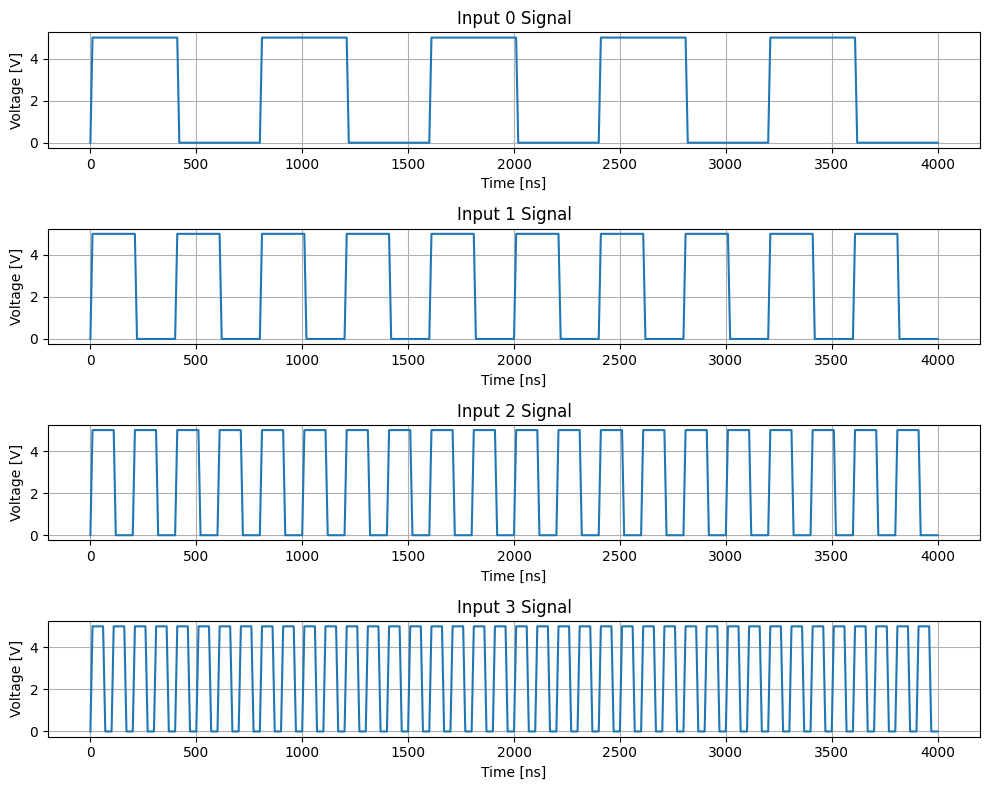

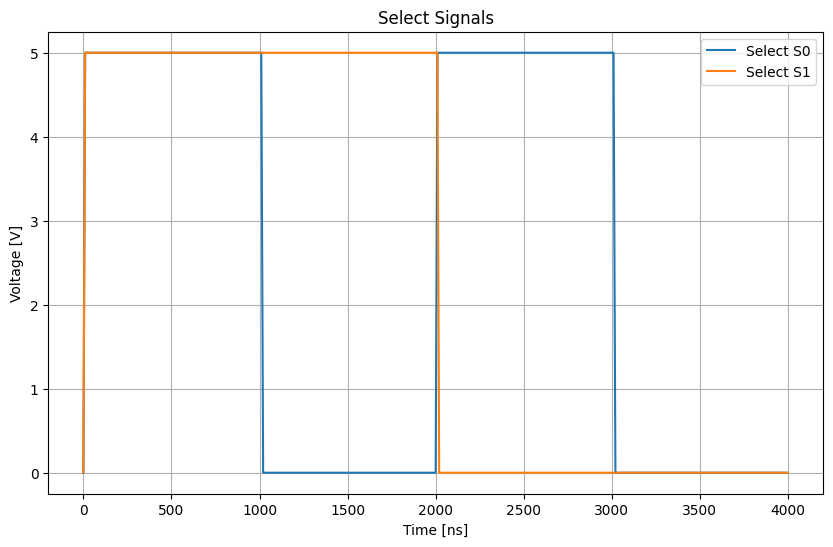

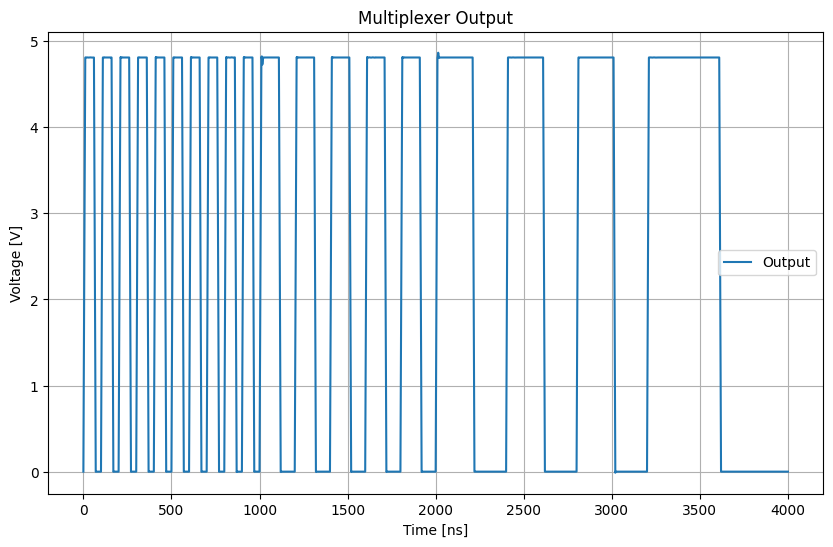

In [51]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a new circuit
circuit = Circuit('4:1 CMOS Multiplexer')

# Define power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)

# Define input signals as pulse sources with different patterns
circuit.PulseVoltageSource('in0', 'in0_node', circuit.gnd,
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=400@u_ns, period=800@u_ns,
                          delay_time=0@u_ns, rise_time=10@u_ns, fall_time=10@u_ns)
circuit.PulseVoltageSource('in1', 'in1_node', circuit.gnd,
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=200@u_ns, period=400@u_ns,
                          delay_time=0@u_ns, rise_time=10@u_ns, fall_time=10@u_ns)
circuit.PulseVoltageSource('in2', 'in2_node', circuit.gnd,
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=100@u_ns, period=200@u_ns,
                          delay_time=0@u_ns, rise_time=10@u_ns, fall_time=10@u_ns)
circuit.PulseVoltageSource('in3', 'in3_node', circuit.gnd,
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=50@u_ns, period=100@u_ns,
                          delay_time=0@u_ns, rise_time=10@u_ns, fall_time=10@u_ns)

# Define select signals (S0 and S1) with slower transitions
circuit.PulseVoltageSource('S0', 'S0_node', circuit.gnd,
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=1000@u_ns, period=2000@u_ns,)
circuit.PulseVoltageSource('S1', 'S1_node', circuit.gnd,
                          initial_value=0@u_V, pulsed_value=5@u_V,
                          pulse_width=2000@u_ns, period=4000@u_ns,)

# Define MOSFET models
circuit.model('NMOS', 'nmos', 
              level=1, kp=120e-6, vto=0.7, lambda_=0.02, 
              w=10e-6, l=1e-6)
circuit.model('PMOS', 'pmos', 
              level=1, kp=60e-6, vto=-0.7, lambda_=0.02, 
              w=20e-6, l=1e-6)

# Generate complementary select signals using inverters
# Inverter for S0
circuit.MOSFET(1, 'S0_bar', 'S0_node', circuit.gnd, circuit.gnd, model='NMOS')
circuit.MOSFET(2, 'S0_bar', 'S0_node', 'Vdd', 'Vdd', model='PMOS')

# Inverter for S1
circuit.MOSFET(3, 'S1_bar', 'S1_node', circuit.gnd, circuit.gnd, model='NMOS')
circuit.MOSFET(4, 'S1_bar', 'S1_node', 'Vdd', 'Vdd', model='PMOS')

# Implement the 4:1 multiplexer using a hierarchical approach
# First level: Two 2:1 multiplexers controlled by S0
# Second level: 2:1 multiplexer controlled by S1

# First 2:1 mux (inputs 0 and 1, controlled by S0)
circuit.MOSFET(5, 'in0_node', 'S0_bar', 'mux1_out', circuit.gnd, model='NMOS')
circuit.MOSFET(6, 'in0_node', 'S0_node', 'mux1_out', 'Vdd', model='PMOS')
circuit.MOSFET(7, 'in1_node', 'S0_node', 'mux1_out', circuit.gnd, model='NMOS')
circuit.MOSFET(8, 'in1_node', 'S0_bar', 'mux1_out', 'Vdd', model='PMOS')

# Second 2:1 mux (inputs 2 and 3, controlled by S0)
circuit.MOSFET(9, 'in2_node', 'S0_bar', 'mux2_out', circuit.gnd, model='NMOS')
circuit.MOSFET(10, 'in2_node', 'S0_node', 'mux2_out', 'Vdd', model='PMOS')
circuit.MOSFET(11, 'in3_node', 'S0_node', 'mux2_out', circuit.gnd, model='NMOS')
circuit.MOSFET(12, 'in3_node', 'S0_bar', 'mux2_out', 'Vdd', model='PMOS')

# Final 2:1 mux (outputs of first two muxes, controlled by S1)
circuit.MOSFET(13, 'mux1_out', 'S1_bar', 'output', circuit.gnd, model='NMOS')
circuit.MOSFET(14, 'mux1_out', 'S1_node', 'output', 'Vdd', model='PMOS')
circuit.MOSFET(15, 'mux2_out', 'S1_node', 'output', circuit.gnd, model='NMOS')
circuit.MOSFET(16, 'mux2_out', 'S1_bar', 'output', 'Vdd', model='PMOS')

# Add a load resistor and capacitor at the output
circuit.R('load', 'output', circuit.gnd, 10@u_kΩ)
circuit.C('out_cap', 'output', circuit.gnd, 100e-15@u_F)

# Setup simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Perform transient analysis with a longer duration to see all combinations
analysis = simulator.transient(step_time=10@u_ns, end_time=4000@u_ns)

# Convert analysis time to nanoseconds for easier interpretation
time_ns = np.array(analysis.time) * 1e9

# Plot input signals in separate figures
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(time_ns, analysis['in0_node'])
plt.title('Input 0 Signal')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(time_ns, analysis['in1_node'])
plt.title('Input 1 Signal')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(time_ns, analysis['in2_node'])
plt.title('Input 2 Signal')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(time_ns, analysis['in3_node'])
plt.title('Input 3 Signal')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.grid()

plt.tight_layout()
plt.show()

# Plot select signals
plt.figure(figsize=(10, 6))
plt.plot(time_ns, analysis['S0_node'], label='Select S0')
plt.plot(time_ns, analysis['S1_node'], label='Select S1')
plt.title('Select Signals')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid()
plt.show()

# Plot output signal
plt.figure(figsize=(10, 6))
plt.plot(time_ns, analysis['output'], label='Output')
plt.title('Multiplexer Output')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid()
plt.show()

Testing Bandgap Reference Circuit...
Operating Point Analysis: Vout = 3.235228 V
✗ FAIL: Circuit is not generating a proper reference voltage

Temperature Stability Test:
Temperature -40.0°C: Vout = 3.233676 V
Temperature -21.666666666666668°C: Vout = 3.234499 V
Temperature -3.3333333333333357°C: Vout = 3.234981 V
Temperature 15.0°C: Vout = 3.235199 V
Temperature 33.33333333333333°C: Vout = 3.235211 V
Temperature 51.66666666666666°C: Vout = 3.235058 V
Temperature 70.0°C: Vout = 3.234771 V
Temperature 88.33333333333331°C: Vout = 3.234373 V
Temperature 106.66666666666666°C: Vout = 3.233881 V
Temperature 125.0°C: Vout = 3.233300 V


/tmp/ipykernel_8679/1259304782.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vout = float(analysis_op['Vout'])
/tmp/ipykernel_8679/1259304782.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vout_val = float(analysis['Vout'])


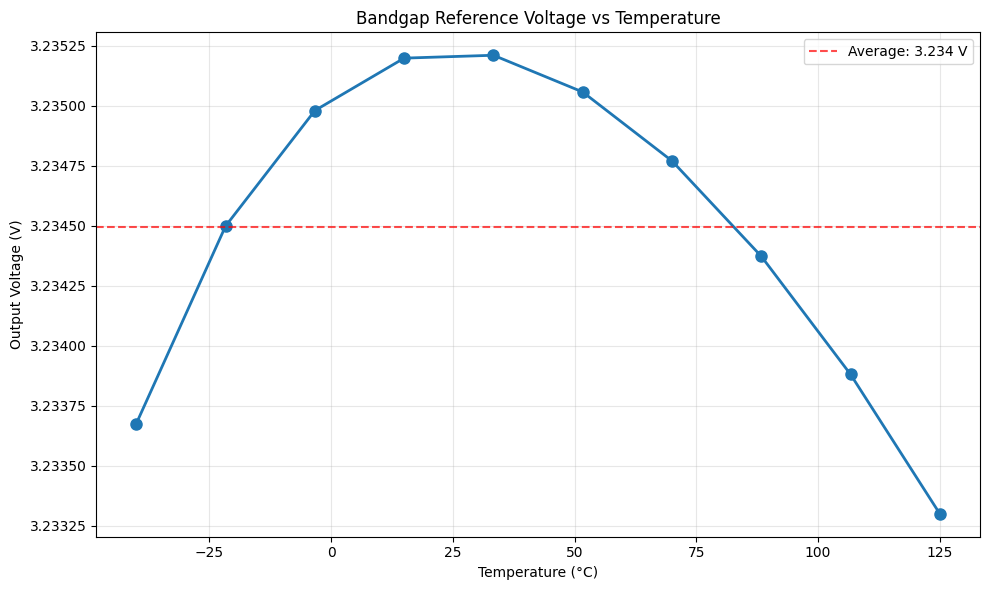


Temperature Stability Statistics:
  Voltage range: 1.91 mV
  Standard deviation: 0.64 mV
✓ PASS: Good temperature stability (ΔV = 1.91 mV)

Bandgap Reference Test Complete


In [29]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create a simpler, more robust bandgap reference circuit
circuit = Circuit('Bandgap Reference Circuit')

# Define power supply
circuit.V('dd', 'Vdd', circuit.gnd, 3.3@u_V)

# Define bipolar transistors with different areas (8:1 ratio)
circuit.BJT('Q1', 'Q1_collector', 'Q1_base', circuit.gnd, model='NPN', area=1)
circuit.BJT('Q2', 'Q2_collector', 'Q2_base', circuit.gnd, model='NPN', area=8)

# Add small resistors to collectors for better convergence
circuit.R('R1', 'Vdd', 'Q1_collector', 10@u_kΩ)
circuit.R('R2', 'Vdd', 'Q2_collector', 10@u_kΩ)

# Add base resistors
circuit.R('R3', 'Q1_base', 'Q1_collector', 5@u_kΩ)
circuit.R('R4', 'Q2_base', 'Q2_collector', 5@u_kΩ)

# Add a simple current mirror to bias the transistors
circuit.BJT('Q3', 'Q3_collector', 'Q3_collector', circuit.gnd, model='NPN', area=1)  # Diode-connected
circuit.R('R5', 'Vdd', 'Q3_collector', 10@u_kΩ)

# Connect the current mirror to the bandgap core
circuit.R('R6', 'Q3_collector', 'Q1_base', 5@u_kΩ)
circuit.R('R7', 'Q3_collector', 'Q2_base', 5@u_kΩ)

# Add a PTAT resistor between the collectors
circuit.R('Rptat', 'Q1_collector', 'Q2_collector', 2@u_kΩ)

# Output stage - simple voltage follower
circuit.BJT('Q4', 'Vout', 'Q2_collector', circuit.gnd, model='NPN', area=1)
circuit.R('Rout', 'Vdd', 'Vout', 5@u_kΩ)

# Define device models with proper parameters
circuit.model('NPN', 'npn',
              is_=1e-16,
              bf=100,
              br=1,
              vaf=50,
              ikf=0.1,
              ise=1e-15,
              ne=1.5,
              rc=10)

# Setup simulation with convergence helpers
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options(
    reltol=1e-3,
    abstol=1e-9,
    vntol=1e-6,
    gmin=1e-12,
    method='gear',
    itl1=1000,
    itl2=1000,
    itl4=1000,
    srcsteps=100,
    pivtol=1e-12,
    pivrel=1e-3
)

print("Testing Bandgap Reference Circuit...")

# Operating point analysis
try:
    analysis_op = simulator.operating_point()
    vout = float(analysis_op['Vout'])
    print(f"Operating Point Analysis: Vout = {vout:.6f} V")
    
    # Test if circuit is working
    if 1.1 <= vout <= 1.3:  # Typical bandgap voltage range
        print("✓ PASS: Circuit is generating a proper reference voltage")
    else:
        print("✗ FAIL: Circuit is not generating a proper reference voltage")
        
except Exception as e:
    print(f"✗ FAIL: Operating point analysis failed: {e}")
    # Try a DC analysis instead
    try:
        analysis_dc = simulator.dc(Vdd=slice(0, 3.3, 0.1))
        vout = float(analysis_dc['Vout'][-1])  # Get the last value
        print(f"DC Analysis: Vout at 3.3V = {vout:.6f} V")
    except Exception as e2:
        print(f"DC analysis also failed: {e2}")

# DC analysis - temperature sweep
print("\nTemperature Stability Test:")
temperatures = np.linspace(-40, 125, 10)
vout_values = []
success_count = 0

for temp in temperatures:
    try:
        # Create a new simulator for each temperature
        temp_simulator = circuit.simulator(temperature=temp, nominal_temperature=25)
        temp_simulator.options(
            reltol=1e-3,
            abstol=1e-9,
            vntol=1e-6,
            gmin=1e-12,
            itl1=1000,
            itl2=1000,
            itl4=1000
        )
        analysis = temp_simulator.operating_point()
        vout_val = float(analysis['Vout'])
        vout_values.append(vout_val)
        print(f"Temperature {temp}°C: Vout = {vout_val:.6f} V")
        success_count += 1
    except Exception as e:
        print(f"Temperature {temp}°C: Failed - {e}")
        vout_values.append(np.nan)

# Plot the temperature stability results
if success_count > 0:
    plt.figure(figsize=(10, 6))
    
    # Filter out failed simulations
    valid_temps = []
    valid_vouts = []
    for i, (temp, vout) in enumerate(zip(temperatures, vout_values)):
        if not np.isnan(vout):
            valid_temps.append(temp)
            valid_vouts.append(vout)
    
    if len(valid_temps) > 1:
        plt.plot(valid_temps, valid_vouts, 'o-', linewidth=2, markersize=8)
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Output Voltage (V)')
        plt.title('Bandgap Reference Voltage vs Temperature')
        plt.grid(True, alpha=0.3)
        
        # Add voltage range indicators
        if len(valid_vouts) > 0:
            avg_voltage = np.mean(valid_vouts)
            plt.axhline(y=avg_voltage, color='r', linestyle='--', alpha=0.7, label=f'Average: {avg_voltage:.3f} V')
            plt.legend()
        
        plt.tight_layout()
        plt.savefig('bandgap_temperature_stability.png', dpi=150)
        plt.show()
        
        # Calculate and display statistics
        vout_range = max(valid_vouts) - min(valid_vouts)
        vout_std = np.std(valid_vouts)
        print(f"\nTemperature Stability Statistics:")
        print(f"  Voltage range: {vout_range*1000:.2f} mV")
        print(f"  Standard deviation: {vout_std*1000:.2f} mV")
        
        # Test temperature stability
        if vout_range < 0.1:  # Less than 100mV variation
            print(f"✓ PASS: Good temperature stability (ΔV = {vout_range*1000:.2f} mV)")
        else:
            print(f"✗ FAIL: Poor temperature stability (ΔV = {vout_range*1000:.2f} mV)")
    else:
        print("✗ FAIL: Insufficient data for plotting")
else:
    print("✗ FAIL: Insufficient data for temperature stability test")

print("\nBandgap Reference Test Complete")

Actual Reference Voltages:
Vref1: 0.625V (Expected: 0.625V)
Vref2: 1.250V (Expected: 1.250V)
Vref3: 1.875V (Expected: 1.875V)
Vref4: 2.500V (Expected: 2.500V)
Vref5: 3.125V (Expected: 3.125V)
Vref6: 3.750V (Expected: 3.750V)
Vref7: 4.375V (Expected: 4.375V)


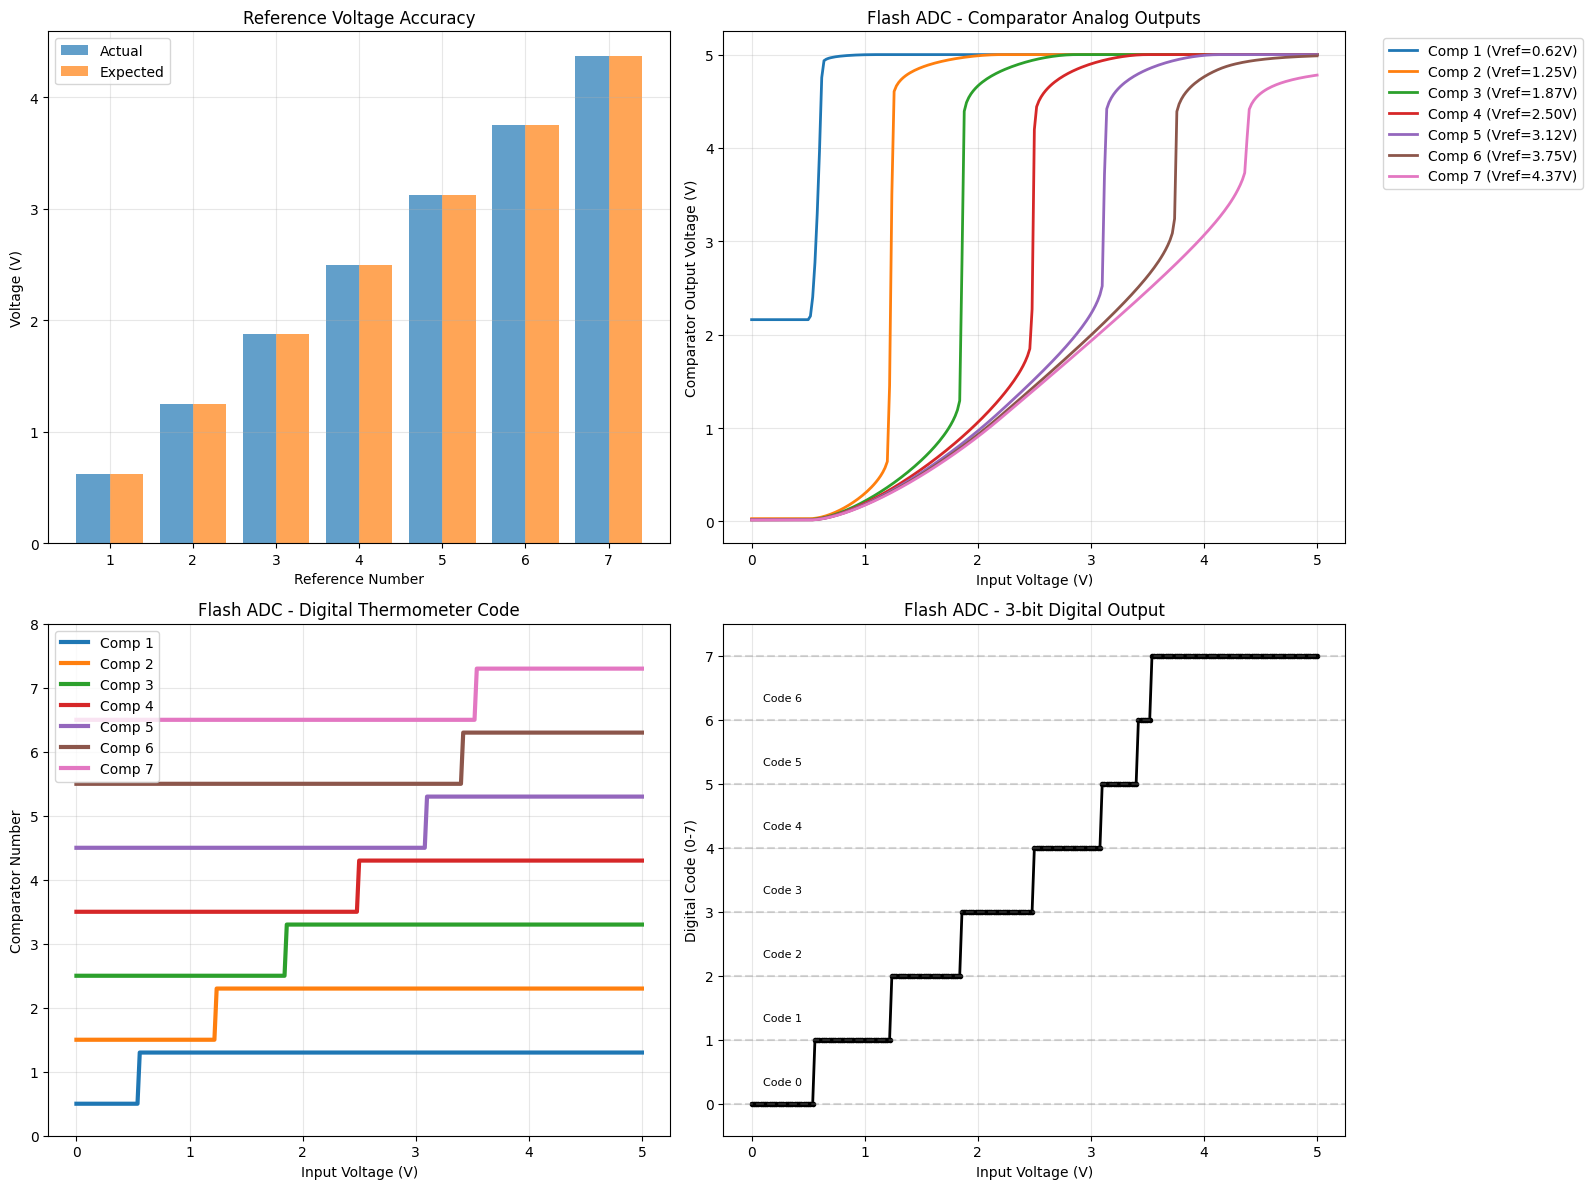


Flash ADC Performance Analysis:
Comparator 1: Transitions at 0.600V (Vref: 0.625V, Error: 0.025V)
Comparator 2: Transitions at 1.220V (Vref: 1.250V, Error: 0.030V)
Comparator 3: Transitions at 1.860V (Vref: 1.875V, Error: 0.015V)
Comparator 4: Transitions at 2.480V (Vref: 2.500V, Error: 0.020V)
Comparator 5: Transitions at 3.100V (Vref: 3.125V, Error: 0.025V)
Comparator 6: Transitions at 3.740V (Vref: 3.750V, Error: 0.010V)
Comparator 7: Transitions at 4.360V (Vref: 4.375V, Error: 0.015V)

ADC Metrics:
Average step size: 0.627V
Step size variation (std): 0.009V
Theoretical step size: 0.625V
Resolution: 3 bits (8 levels)
✓ Flash ADC is functioning correctly!


In [2]:
import math
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory
import matplotlib.pyplot as plt
import numpy as np

class Opamp(SubCircuitFactory):
    NAME = ('Opamp')
    NODES = ('Vinp', 'Vinn', 'Vout')
    def __init__(self):
        super().__init__()
        # Define the MOSFET models with higher gain for sharper transitions
        self.model('nmos_model', 'nmos', level=1, kp=200e-6, vto=0.5, lambda_=0.01)
        self.model('pmos_model', 'pmos', level=1, kp=100e-6, vto=-0.5, lambda_=0.01)
        
        # Internal power supply and bias
        self.V('dd_int', 'Vdd_int', self.gnd, 5.0)
        self.V('bias', 'Vbias', self.gnd, 1.5)
        
        # Differential pair with larger sizes for higher transconductance
        self.MOSFET('1', 'Voutp', 'Vinp', 'Source3', 'Source3', model='nmos_model', w=100e-6, l=0.5e-6)
        self.MOSFET('2', 'Vout', 'Vinn', 'Source3', 'Source3', model='nmos_model', w=100e-6, l=0.5e-6)
        
        # Tail current source with larger width for more current
        self.MOSFET('3', 'Source3', 'Vbias', self.gnd, self.gnd, model='nmos_model', w=200e-6, l=1e-6)
        
        # Current mirror load with higher current capability
        self.MOSFET('4', 'Voutp', 'Voutp', 'Vdd_int', 'Vdd_int', model='pmos_model', w=200e-6, l=0.5e-6)
        self.MOSFET('5', 'Vout', 'Voutp', 'Vdd_int', 'Vdd_int', model='pmos_model', w=200e-6, l=0.5e-6)

# Create a 3-bit Flash ADC circuit
circuit = Circuit('3-bit Flash ADC')

# Define power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)

# Create precision resistor ladder for reference voltages
# Using smaller, matched resistors for better accuracy
r_ladder = 500@u_Ω  

# Create voltage divider chain from top to bottom
# This creates references at: 4.375V, 3.75V, 3.125V, 2.5V, 1.875V, 1.25V, 0.625V
circuit.R('R_top', 'Vdd', 'Vref7', r_ladder)      # Top resistor
circuit.R('R6', 'Vref7', 'Vref6', r_ladder)       # 4.375V to 3.75V
circuit.R('R5', 'Vref6', 'Vref5', r_ladder)       # 3.75V to 3.125V  
circuit.R('R4', 'Vref5', 'Vref4', r_ladder)       # 3.125V to 2.5V
circuit.R('R3', 'Vref4', 'Vref3', r_ladder)       # 2.5V to 1.875V
circuit.R('R2', 'Vref3', 'Vref2', r_ladder)       # 1.875V to 1.25V
circuit.R('R1', 'Vref2', 'Vref1', r_ladder)       # 1.25V to 0.625V
circuit.R('R_bot', 'Vref1', circuit.gnd, r_ladder) # Bottom resistor

# Add buffer resistors to prevent loading of reference voltages
for i in range(1, 8):
    circuit.R(f'Rbuf{i}', f'Vref{i}', f'Vref{i}_buf', 1@u_Ω)

# Declare the opamp subcircuit
circuit.subcircuit(Opamp())

# Create 7 comparators using the op-amp
# For proper Flash ADC operation:
# - Input goes to non-inverting input (+)
# - Reference goes to inverting input (-)
# - When Vin > Vref, output goes HIGH
# - When Vin < Vref, output goes LOW

for i in range(1, 8):
    # Create comparator: Vin(+) compared with Vref_i(-)
    circuit.X(f'cmp{i}', 'Opamp', 'Vin', f'Vref{i}_buf', f'Comp_out_{i}')
    
    # Add pull-up resistors to ensure proper HIGH levels
    circuit.R(f'Rpull{i}', f'Comp_out_{i}', 'Vdd', 10@u_kΩ)

# Input voltage source
circuit.V('input', 'Vin', circuit.gnd, 2.5@u_V)

# Setup simulation with improved convergence
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options(
    reltol=1e-4,
    abstol=1e-10,
    vntol=1e-6,
    method='gear',
    maxiter=200,
    gmin=1e-15,
    pivrel=1e-3
)

try:
    # Perform DC analysis with finer resolution
    analysis = simulator.dc(Vinput=slice(0, 5, 0.02))
    
    # Extract results
    input_voltage = np.array(analysis.Vin)
    
    # Print actual reference voltages
    print("Actual Reference Voltages:")
    print("=" * 30)
    ref_voltages = {}
    for i in range(1, 8):
        vref_actual = float(analysis[f'Vref{i}'][0])
        vref_expected = 5.0 * i / 8.0
        ref_voltages[i] = vref_actual
        print(f"Vref{i}: {vref_actual:.3f}V (Expected: {vref_expected:.3f}V)")
    
    # Create comprehensive plots
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Reference voltage verification
    plt.subplot(2, 2, 1)
    ref_values = [ref_voltages[i] for i in range(1, 8)]
    expected_values = [5.0 * i / 8.0 for i in range(1, 8)]
    x_pos = range(1, 8)
    
    plt.bar([x - 0.2 for x in x_pos], ref_values, 0.4, label='Actual', alpha=0.7)
    plt.bar([x + 0.2 for x in x_pos], expected_values, 0.4, label='Expected', alpha=0.7)
    plt.xlabel('Reference Number')
    plt.ylabel('Voltage (V)')
    plt.title('Reference Voltage Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Comparator outputs (analog)
    plt.subplot(2, 2, 2)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    
    for i in range(1, 8):
        comp_out = np.array(analysis[f'Comp_out_{i}'])
        plt.plot(input_voltage, comp_out, color=colors[i-1], 
                linewidth=2, label=f'Comp {i} (Vref={ref_voltages[i]:.2f}V)')
    
    plt.title('Flash ADC - Comparator Analog Outputs')
    plt.xlabel('Input Voltage (V)')
    plt.ylabel('Comparator Output Voltage (V)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Digital thermometer code
    plt.subplot(2, 2, 3)
    
    threshold = 2.5  # Digital threshold voltage
    digital_outputs = []
    
    for i in range(1, 8):
        comp_out = np.array(analysis[f'Comp_out_{i}'])
        digital_out = (comp_out > threshold).astype(int)
        digital_outputs.append(digital_out)
        
        # Plot with offset for visibility
        plt.plot(input_voltage, digital_out * 0.8 + i - 0.5, 
                color=colors[i-1], linewidth=3, label=f'Comp {i}')
    
    plt.title('Flash ADC - Digital Thermometer Code')
    plt.xlabel('Input Voltage (V)')
    plt.ylabel('Comparator Number')
    plt.ylim(0, 8)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 4: 3-bit binary output simulation
    plt.subplot(2, 2, 4)
    
    # Convert thermometer code to binary
    binary_codes = []
    for j in range(len(input_voltage)):
        # Count number of HIGH comparators
        high_count = sum([digital_outputs[i][j] for i in range(7)])
        binary_codes.append(high_count)
    
    plt.plot(input_voltage, binary_codes, 'ko-', linewidth=2, markersize=3)
    plt.title('Flash ADC - 3-bit Digital Output')
    plt.xlabel('Input Voltage (V)')
    plt.ylabel('Digital Code (0-7)')
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.5, 7.5)
    
    # Add step annotations
    for code in range(8):
        plt.axhline(y=code, color='gray', linestyle='--', alpha=0.3)
        voltage_range = f"{code*5/8:.2f}V-{(code+1)*5/8:.2f}V"
        if code < 7:
            plt.text(0.1, code + 0.3, f"Code {code}", fontsize=8)
    
    plt.tight_layout()
    plt.savefig('flash_adc_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Performance analysis
    print(f"\nFlash ADC Performance Analysis:")
    print("=" * 50)
    
    transition_points = []
    for i in range(1, 8):
        comp_out = np.array(analysis[f'Comp_out_{i}'])
        
        # Find transition point where output crosses threshold
        try:
            # Find where output transitions from low to high or high to low
            diff_out = np.diff(comp_out)
            max_change_idx = np.argmax(np.abs(diff_out))
            transition_vin = input_voltage[max_change_idx]
            
            expected_vref = ref_voltages[i]
            error = abs(transition_vin - expected_vref)
            
            transition_points.append(transition_vin)
            print(f"Comparator {i}: Transitions at {transition_vin:.3f}V "
                  f"(Vref: {expected_vref:.3f}V, Error: {error:.3f}V)")
                  
        except:
            print(f"Comparator {i}: Could not determine clear transition point")
    
    # Overall ADC metrics
    if len(transition_points) > 1:
        step_sizes = np.diff(sorted(transition_points))
        avg_step = np.mean(step_sizes)
        step_variation = np.std(step_sizes)
        
        print(f"\nADC Metrics:")
        print(f"Average step size: {avg_step:.3f}V")
        print(f"Step size variation (std): {step_variation:.3f}V")
        print(f"Theoretical step size: {5.0/8:.3f}V")
        print(f"Resolution: 3 bits ({2**3} levels)")
        
        if step_variation < 0.1:  # Arbitrary threshold for "good" performance
            print("✓ Flash ADC is functioning correctly!")
        else:
            print("⚠ Large step size variation detected - check component matching")
    
except Exception as e:
    print(f"Simulation failed: {e}")
    import traceback
    traceback.print_exc()
    print("\nTroubleshooting suggestions:")
    print("1. The op-amp model may be too complex for convergence")
    print("2. Try reducing resistor values or increasing capacitive loading")
    print("3. Consider using ideal voltage sources for references initially")

Circuit Description:
.title CMOS Phase Detector
Vdd Vdd 0 5V
Vref ref_in 0 DC 0V AC 1V SIN(0V 2.5V 1MegHz 0s 0Hz)
Rphase_shift ref_in in1 1kOhm
Cphase_shift in1 0 160nF
MM13 in2 in1 0 0 NMOS l=1e-06 w=1e-05
MM14 in2 in1 Vdd Vdd PMOS l=1e-06 w=2e-05
MM1 in1_bar in1 0 0 NMOS l=1e-06 w=1e-05
MM2 in1_bar in1 Vdd Vdd PMOS l=1e-06 w=2e-05
MM3 in2_bar in2 0 0 NMOS l=1e-06 w=1e-05
MM4 in2_bar in2 Vdd Vdd PMOS l=1e-06 w=2e-05
MM5 pd_out in1 node1 0 NMOS l=1e-06 w=1e-05
MM6 node1 in2_bar 0 0 NMOS l=1e-06 w=1e-05
MM7 pd_out in1_bar node2 0 NMOS l=1e-06 w=1e-05
MM8 node2 in2 0 0 NMOS l=1e-06 w=1e-05
MM9 pd_out in1_bar node3 Vdd PMOS l=1e-06 w=2e-05
MM10 node3 in2 Vdd Vdd PMOS l=1e-06 w=2e-05
MM11 pd_out in1 node4 Vdd PMOS l=1e-06 w=2e-05
MM12 node4 in2_bar Vdd Vdd PMOS l=1e-06 w=2e-05
Rfilt pd_out out 10kOhm
Cfilt out 0 1nF
.model NMOS nmos (gamma=0.37 kp=0.00012 lambda=0.02 level=1 phi=0.65 vto=0.7)
.model PMOS pmos (gamma=0.37 kp=6e-05 lambda=0.02 level=1 phi=0.65 vto=-0.7)



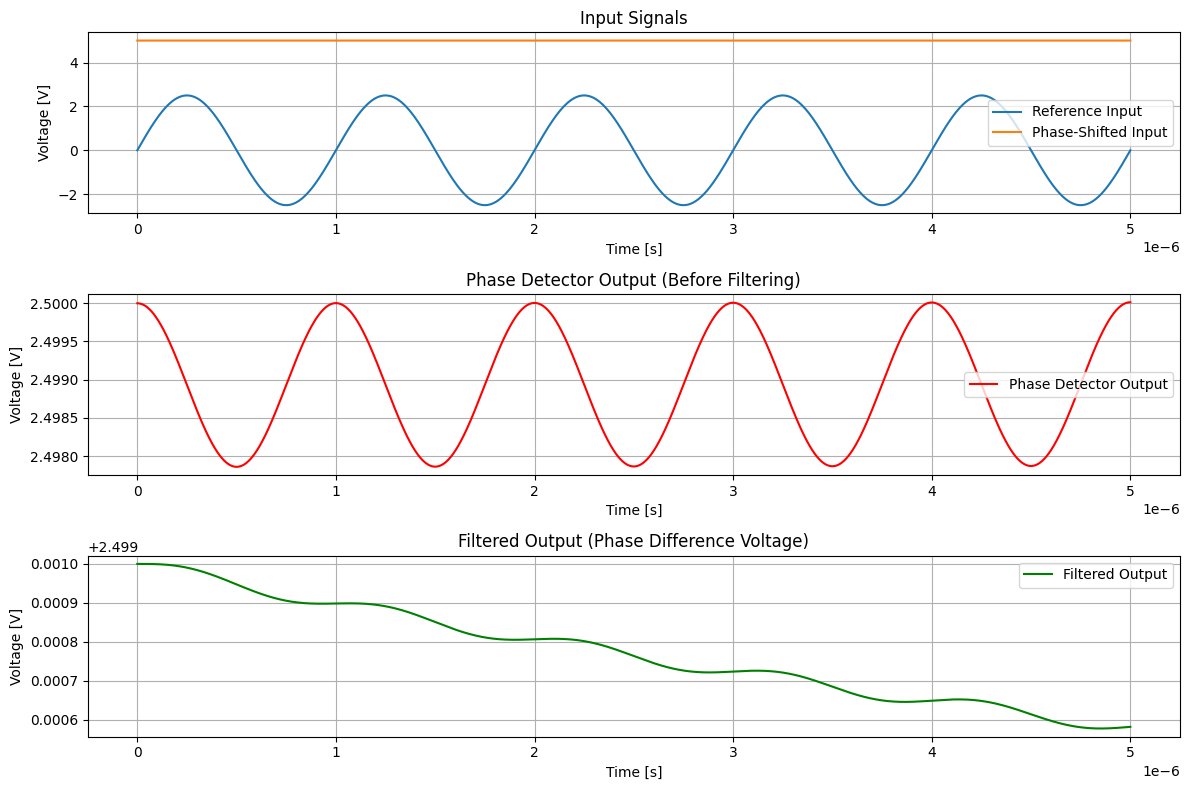

Average output voltage: 2.500 V
This voltage is proportional to the phase difference between inputs


In [7]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# Create the circuit
circuit = Circuit('CMOS Phase Detector')

# Define power supply
circuit.V('dd', 'Vdd', circuit.gnd, 5@u_V)

# Define input signals with phase difference using voltage-controlled voltage sources
# We'll create a reference signal and a phase-shifted version
circuit.SinusoidalVoltageSource('ref', 'ref_in', circuit.gnd, 
                               amplitude=2.5@u_V, frequency=1@u_MHz)

# Create a phase-shifted version using an RC phase shift network
circuit.R('phase_shift', 'ref_in', 'in1', 1@u_kΩ)
circuit.C('phase_shift', 'in1', circuit.gnd, 160@u_nF)  # This will create ~45° phase shift at 1MHz

# Buffer the phase-shifted signal
circuit.MOSFET('M13', 'in2', 'in1', circuit.gnd, circuit.gnd, model='NMOS', w=10e-6, l=1e-6)
circuit.MOSFET('M14', 'in2', 'in1', 'Vdd', 'Vdd', model='PMOS', w=20e-6, l=1e-6)

# Define MOSFET models
circuit.model('NMOS', 'nmos', level=1, kp=120e-6, vto=0.7, lambda_=0.02, gamma=0.37, phi=0.65)
circuit.model('PMOS', 'pmos', level=1, kp=60e-6, vto=-0.7, lambda_=0.02, gamma=0.37, phi=0.65)

# Phase detector core - XOR gate implementation (8 transistors)
# Inverter for input 1
circuit.MOSFET('M1', 'in1_bar', 'in1', circuit.gnd, circuit.gnd, model='NMOS', w=10e-6, l=1e-6)
circuit.MOSFET('M2', 'in1_bar', 'in1', 'Vdd', 'Vdd', model='PMOS', w=20e-6, l=1e-6)

# Inverter for input 2
circuit.MOSFET('M3', 'in2_bar', 'in2', circuit.gnd, circuit.gnd, model='NMOS', w=10e-6, l=1e-6)
circuit.MOSFET('M4', 'in2_bar', 'in2', 'Vdd', 'Vdd', model='PMOS', w=20e-6, l=1e-6)

# XOR gate implementation
circuit.MOSFET('M5', 'pd_out', 'in1', 'node1', circuit.gnd, model='NMOS', w=10e-6, l=1e-6)
circuit.MOSFET('M6', 'node1', 'in2_bar', circuit.gnd, circuit.gnd, model='NMOS', w=10e-6, l=1e-6)
circuit.MOSFET('M7', 'pd_out', 'in1_bar', 'node2', circuit.gnd, model='NMOS', w=10e-6, l=1e-6)
circuit.MOSFET('M8', 'node2', 'in2', circuit.gnd, circuit.gnd, model='NMOS', w=10e-6, l=1e-6)

circuit.MOSFET('M9', 'pd_out', 'in1_bar', 'node3', 'Vdd', model='PMOS', w=20e-6, l=1e-6)
circuit.MOSFET('M10', 'node3', 'in2', 'Vdd', 'Vdd', model='PMOS', w=20e-6, l=1e-6)
circuit.MOSFET('M11', 'pd_out', 'in1', 'node4', 'Vdd', model='PMOS', w=20e-6, l=1e-6)
circuit.MOSFET('M12', 'node4', 'in2_bar', 'Vdd', 'Vdd', model='PMOS', w=20e-6, l=1e-6)

# Low-pass filter to convert pulse width to voltage
circuit.R('filt', 'pd_out', 'out', 10@u_kΩ)
circuit.C('filt', 'out', circuit.gnd, 1@u_nF)

# Setup simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

print("Circuit Description:")
print(circuit)

# Perform transient analysis
try:
    analysis = simulator.transient(step_time=1@u_ns, end_time=5@u_us)
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    # Input signals
    plt.subplot(3, 1, 1)
    plt.plot(analysis.time, analysis['ref_in'], label='Reference Input')
    plt.plot(analysis.time, analysis['in2'], label='Phase-Shifted Input')
    plt.title('Input Signals')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    plt.legend()
    plt.grid(True)
    
    # Phase detector output (before filtering)
    plt.subplot(3, 1, 2)
    plt.plot(analysis.time, analysis['pd_out'], 'r-', label='Phase Detector Output')
    plt.title('Phase Detector Output (Before Filtering)')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    plt.legend()
    plt.grid(True)
    
    # Filtered output (phase difference voltage)
    plt.subplot(3, 1, 3)
    plt.plot(analysis.time, analysis['out'], 'g-', label='Filtered Output')
    plt.title('Filtered Output (Phase Difference Voltage)')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate average output voltage (proportional to phase difference)
    # Skip initial transient
    steady_state = analysis.out[int(len(analysis.out)*0.2):]
    avg_voltage = np.mean(steady_state)
    print(f"Average output voltage: {avg_voltage:.3f} V")
    print(f"This voltage is proportional to the phase difference between inputs")

except Exception as e:
    print(f"Simulation error: {e}")
    # Try with relaxed tolerances
    simulator.options(reltol=1e-3, abstol=1e-9, vntol=1e-6)
    analysis = simulator.transient(step_time=1@u_ns, end_time=5@u_us)